In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import time

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
data = []
import os
from PIL import Image
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data.append(np.asarray(Image.open(os.path.join(dirname, filename)).resize((100,100))))
data = np.array(data)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animefacedataset/images/1947_2001.jpg
/kaggle/input/animefacedataset/images/38275_2012.jpg
/kaggle/input/animefacedataset/images/37262_2012.jpg
/kaggle/input/animefacedataset/images/51543_2015.jpg
/kaggle/input/animefacedataset/images/49788_2015.jpg
/kaggle/input/animefacedataset/images/55978_2017.jpg
/kaggle/input/animefacedataset/images/36003_2011.jpg
/kaggle/input/animefacedataset/images/18133_2007.jpg
/kaggle/input/animefacedataset/images/32720_2011.jpg
/kaggle/input/animefacedataset/images/5148_2003.jpg
/kaggle/input/animefacedataset/images/18655_2007.jpg
/kaggle/input/animefacedataset/images/59074_2018.jpg
/kaggle/input/animefacedataset/images/13611_2006.jpg
/kaggle/input/animefacedataset/images/46286_2014.jpg
/kaggle/input/animefacedataset/images/40928_2013.jpg
/kaggle/input/animefacedataset/images/27160_2009.jpg
/kaggle/input/animefacedataset/images/36801_2012.jpg
/kaggle/input/animefacedataset/images/26258_2009.jpg
/kaggle/input/animefacedataset/images/239_2000.j

/kaggle/input/animefacedataset/images/52631_2016.jpg
/kaggle/input/animefacedataset/images/25443_2009.jpg
/kaggle/input/animefacedataset/images/57514_2017.jpg
/kaggle/input/animefacedataset/images/60316_2018.jpg
/kaggle/input/animefacedataset/images/4426_2003.jpg
/kaggle/input/animefacedataset/images/60638_2018.jpg
/kaggle/input/animefacedataset/images/59114_2018.jpg
/kaggle/input/animefacedataset/images/50924_2015.jpg
/kaggle/input/animefacedataset/images/49013_2015.jpg
/kaggle/input/animefacedataset/images/60726_2018.jpg
/kaggle/input/animefacedataset/images/36983_2012.jpg
/kaggle/input/animefacedataset/images/60584_2018.jpg
/kaggle/input/animefacedataset/images/6544_2003.jpg
/kaggle/input/animefacedataset/images/5135_2003.jpg
/kaggle/input/animefacedataset/images/30241_2010.jpg
/kaggle/input/animefacedataset/images/59999_2018.jpg
/kaggle/input/animefacedataset/images/9498_2004.jpg
/kaggle/input/animefacedataset/images/10154_2004.jpg
/kaggle/input/animefacedataset/images/33094_2011.j

/kaggle/input/animefacedataset/images/54241_2016.jpg
/kaggle/input/animefacedataset/images/61841_2018.jpg
/kaggle/input/animefacedataset/images/50453_2015.jpg
/kaggle/input/animefacedataset/images/38719_2012.jpg
/kaggle/input/animefacedataset/images/35840_2011.jpg
/kaggle/input/animefacedataset/images/62898_2019.jpg
/kaggle/input/animefacedataset/images/6275_2003.jpg
/kaggle/input/animefacedataset/images/3875_2002.jpg
/kaggle/input/animefacedataset/images/41287_2013.jpg
/kaggle/input/animefacedataset/images/29152_2010.jpg
/kaggle/input/animefacedataset/images/20989_2008.jpg
/kaggle/input/animefacedataset/images/49223_2015.jpg
/kaggle/input/animefacedataset/images/19998_2007.jpg
/kaggle/input/animefacedataset/images/52217_2015.jpg
/kaggle/input/animefacedataset/images/35209_2011.jpg
/kaggle/input/animefacedataset/images/2735_2002.jpg
/kaggle/input/animefacedataset/images/27258_2009.jpg
/kaggle/input/animefacedataset/images/35143_2011.jpg
/kaggle/input/animefacedataset/images/31486_2010.

/kaggle/input/animefacedataset/images/57448_2017.jpg
/kaggle/input/animefacedataset/images/24749_2009.jpg
/kaggle/input/animefacedataset/images/4470_2003.jpg
/kaggle/input/animefacedataset/images/41280_2013.jpg
/kaggle/input/animefacedataset/images/54790_2016.jpg
/kaggle/input/animefacedataset/images/43216_2013.jpg
/kaggle/input/animefacedataset/images/57329_2017.jpg
/kaggle/input/animefacedataset/images/35384_2011.jpg
/kaggle/input/animefacedataset/images/24438_2009.jpg
/kaggle/input/animefacedataset/images/12813_2005.jpg
/kaggle/input/animefacedataset/images/59746_2018.jpg
/kaggle/input/animefacedataset/images/28585_2010.jpg
/kaggle/input/animefacedataset/images/59126_2018.jpg
/kaggle/input/animefacedataset/images/54128_2016.jpg
/kaggle/input/animefacedataset/images/47774_2014.jpg
/kaggle/input/animefacedataset/images/32578_2011.jpg
/kaggle/input/animefacedataset/images/37028_2012.jpg
/kaggle/input/animefacedataset/images/8904_2004.jpg
/kaggle/input/animefacedataset/images/23357_2008

/kaggle/input/animefacedataset/images/41694_2013.jpg
/kaggle/input/animefacedataset/images/45586_2014.jpg
/kaggle/input/animefacedataset/images/27329_2009.jpg
/kaggle/input/animefacedataset/images/61800_2018.jpg
/kaggle/input/animefacedataset/images/25811_2009.jpg
/kaggle/input/animefacedataset/images/49583_2015.jpg
/kaggle/input/animefacedataset/images/39370_2012.jpg
/kaggle/input/animefacedataset/images/17227_2007.jpg
/kaggle/input/animefacedataset/images/43590_2013.jpg
/kaggle/input/animefacedataset/images/58584_2017.jpg
/kaggle/input/animefacedataset/images/33098_2011.jpg
/kaggle/input/animefacedataset/images/46567_2014.jpg
/kaggle/input/animefacedataset/images/16363_2006.jpg
/kaggle/input/animefacedataset/images/46579_2014.jpg
/kaggle/input/animefacedataset/images/35845_2011.jpg
/kaggle/input/animefacedataset/images/3703_2002.jpg
/kaggle/input/animefacedataset/images/56593_2017.jpg
/kaggle/input/animefacedataset/images/30066_2010.jpg
/kaggle/input/animefacedataset/images/56556_201

/kaggle/input/animefacedataset/images/5704_2003.jpg
/kaggle/input/animefacedataset/images/2497_2002.jpg
/kaggle/input/animefacedataset/images/4937_2003.jpg
/kaggle/input/animefacedataset/images/4242_2002.jpg
/kaggle/input/animefacedataset/images/6538_2003.jpg
/kaggle/input/animefacedataset/images/17358_2007.jpg
/kaggle/input/animefacedataset/images/59821_2018.jpg
/kaggle/input/animefacedataset/images/11269_2005.jpg
/kaggle/input/animefacedataset/images/61601_2018.jpg
/kaggle/input/animefacedataset/images/35635_2011.jpg
/kaggle/input/animefacedataset/images/7671_2004.jpg
/kaggle/input/animefacedataset/images/20902_2008.jpg
/kaggle/input/animefacedataset/images/24553_2009.jpg
/kaggle/input/animefacedataset/images/47275_2014.jpg
/kaggle/input/animefacedataset/images/43130_2013.jpg
/kaggle/input/animefacedataset/images/15703_2006.jpg
/kaggle/input/animefacedataset/images/37880_2012.jpg
/kaggle/input/animefacedataset/images/17_2000.jpg
/kaggle/input/animefacedataset/images/58662_2017.jpg
/k

/kaggle/input/animefacedataset/images/11584_2005.jpg
/kaggle/input/animefacedataset/images/12136_2005.jpg
/kaggle/input/animefacedataset/images/26104_2009.jpg
/kaggle/input/animefacedataset/images/30343_2010.jpg
/kaggle/input/animefacedataset/images/19438_2007.jpg
/kaggle/input/animefacedataset/images/19000_2007.jpg
/kaggle/input/animefacedataset/images/22104_2008.jpg
/kaggle/input/animefacedataset/images/48726_2014.jpg
/kaggle/input/animefacedataset/images/30789_2010.jpg
/kaggle/input/animefacedataset/images/17442_2007.jpg
/kaggle/input/animefacedataset/images/44063_2013.jpg
/kaggle/input/animefacedataset/images/42174_2013.jpg
/kaggle/input/animefacedataset/images/12165_2005.jpg
/kaggle/input/animefacedataset/images/62513_2019.jpg
/kaggle/input/animefacedataset/images/4112_2002.jpg
/kaggle/input/animefacedataset/images/35271_2011.jpg
/kaggle/input/animefacedataset/images/49_2000.jpg
/kaggle/input/animefacedataset/images/43864_2013.jpg
/kaggle/input/animefacedataset/images/45804_2014.j

/kaggle/input/animefacedataset/images/59947_2018.jpg
/kaggle/input/animefacedataset/images/32813_2011.jpg
/kaggle/input/animefacedataset/images/7342_2004.jpg
/kaggle/input/animefacedataset/images/32491_2011.jpg
/kaggle/input/animefacedataset/images/25006_2009.jpg
/kaggle/input/animefacedataset/images/39167_2012.jpg
/kaggle/input/animefacedataset/images/54216_2016.jpg
/kaggle/input/animefacedataset/images/54687_2016.jpg
/kaggle/input/animefacedataset/images/61101_2018.jpg
/kaggle/input/animefacedataset/images/9810_2004.jpg
/kaggle/input/animefacedataset/images/48900_2014.jpg
/kaggle/input/animefacedataset/images/49076_2015.jpg
/kaggle/input/animefacedataset/images/15871_2006.jpg
/kaggle/input/animefacedataset/images/37838_2012.jpg
/kaggle/input/animefacedataset/images/14988_2006.jpg
/kaggle/input/animefacedataset/images/18662_2007.jpg
/kaggle/input/animefacedataset/images/23688_2008.jpg
/kaggle/input/animefacedataset/images/13182_2005.jpg
/kaggle/input/animefacedataset/images/32537_2011

/kaggle/input/animefacedataset/images/2818_2002.jpg
/kaggle/input/animefacedataset/images/15639_2006.jpg
/kaggle/input/animefacedataset/images/59011_2018.jpg
/kaggle/input/animefacedataset/images/50878_2015.jpg
/kaggle/input/animefacedataset/images/32418_2011.jpg
/kaggle/input/animefacedataset/images/33169_2011.jpg
/kaggle/input/animefacedataset/images/26430_2009.jpg
/kaggle/input/animefacedataset/images/15105_2006.jpg
/kaggle/input/animefacedataset/images/61913_2019.jpg
/kaggle/input/animefacedataset/images/24245_2008.jpg
/kaggle/input/animefacedataset/images/21153_2008.jpg
/kaggle/input/animefacedataset/images/17449_2007.jpg
/kaggle/input/animefacedataset/images/61026_2018.jpg
/kaggle/input/animefacedataset/images/43200_2013.jpg
/kaggle/input/animefacedataset/images/31910_2010.jpg
/kaggle/input/animefacedataset/images/9169_2004.jpg
/kaggle/input/animefacedataset/images/21907_2008.jpg
/kaggle/input/animefacedataset/images/22047_2008.jpg
/kaggle/input/animefacedataset/images/9655_2004.

/kaggle/input/animefacedataset/images/46921_2014.jpg
/kaggle/input/animefacedataset/images/60929_2018.jpg
/kaggle/input/animefacedataset/images/15728_2006.jpg
/kaggle/input/animefacedataset/images/50049_2015.jpg
/kaggle/input/animefacedataset/images/32424_2011.jpg
/kaggle/input/animefacedataset/images/21617_2008.jpg
/kaggle/input/animefacedataset/images/55576_2016.jpg
/kaggle/input/animefacedataset/images/21394_2008.jpg
/kaggle/input/animefacedataset/images/50023_2015.jpg
/kaggle/input/animefacedataset/images/35979_2011.jpg
/kaggle/input/animefacedataset/images/58416_2017.jpg
/kaggle/input/animefacedataset/images/62347_2019.jpg
/kaggle/input/animefacedataset/images/49256_2015.jpg
/kaggle/input/animefacedataset/images/40624_2013.jpg
/kaggle/input/animefacedataset/images/63144_2019.jpg
/kaggle/input/animefacedataset/images/36644_2012.jpg
/kaggle/input/animefacedataset/images/47117_2014.jpg
/kaggle/input/animefacedataset/images/27299_2009.jpg
/kaggle/input/animefacedataset/images/46003_20

/kaggle/input/animefacedataset/images/16638_2006.jpg
/kaggle/input/animefacedataset/images/13246_2005.jpg
/kaggle/input/animefacedataset/images/22072_2008.jpg
/kaggle/input/animefacedataset/images/5602_2003.jpg
/kaggle/input/animefacedataset/images/39109_2012.jpg
/kaggle/input/animefacedataset/images/46840_2014.jpg
/kaggle/input/animefacedataset/images/11136_2005.jpg
/kaggle/input/animefacedataset/images/42061_2013.jpg
/kaggle/input/animefacedataset/images/51070_2015.jpg
/kaggle/input/animefacedataset/images/13232_2005.jpg
/kaggle/input/animefacedataset/images/9779_2004.jpg
/kaggle/input/animefacedataset/images/51963_2015.jpg
/kaggle/input/animefacedataset/images/1260_2001.jpg
/kaggle/input/animefacedataset/images/36414_2012.jpg
/kaggle/input/animefacedataset/images/49094_2015.jpg
/kaggle/input/animefacedataset/images/4228_2002.jpg
/kaggle/input/animefacedataset/images/13643_2006.jpg
/kaggle/input/animefacedataset/images/16007_2006.jpg
/kaggle/input/animefacedataset/images/33313_2011.j

/kaggle/input/animefacedataset/images/53628_2016.jpg
/kaggle/input/animefacedataset/images/23918_2008.jpg
/kaggle/input/animefacedataset/images/24304_2008.jpg
/kaggle/input/animefacedataset/images/9267_2004.jpg
/kaggle/input/animefacedataset/images/60779_2018.jpg
/kaggle/input/animefacedataset/images/35711_2011.jpg
/kaggle/input/animefacedataset/images/34170_2011.jpg
/kaggle/input/animefacedataset/images/54384_2016.jpg
/kaggle/input/animefacedataset/images/27282_2009.jpg
/kaggle/input/animefacedataset/images/41332_2013.jpg
/kaggle/input/animefacedataset/images/58500_2017.jpg
/kaggle/input/animefacedataset/images/4508_2003.jpg
/kaggle/input/animefacedataset/images/39251_2012.jpg
/kaggle/input/animefacedataset/images/1968_2001.jpg
/kaggle/input/animefacedataset/images/51676_2015.jpg
/kaggle/input/animefacedataset/images/6957_2003.jpg
/kaggle/input/animefacedataset/images/19389_2007.jpg
/kaggle/input/animefacedataset/images/29373_2010.jpg
/kaggle/input/animefacedataset/images/227_2000.jpg

/kaggle/input/animefacedataset/images/8315_2004.jpg
/kaggle/input/animefacedataset/images/57720_2017.jpg
/kaggle/input/animefacedataset/images/21357_2008.jpg
/kaggle/input/animefacedataset/images/36073_2011.jpg
/kaggle/input/animefacedataset/images/51104_2015.jpg
/kaggle/input/animefacedataset/images/36012_2011.jpg
/kaggle/input/animefacedataset/images/17253_2007.jpg
/kaggle/input/animefacedataset/images/26018_2009.jpg
/kaggle/input/animefacedataset/images/25632_2009.jpg
/kaggle/input/animefacedataset/images/13561_2006.jpg
/kaggle/input/animefacedataset/images/34935_2011.jpg
/kaggle/input/animefacedataset/images/20777_2008.jpg
/kaggle/input/animefacedataset/images/46892_2014.jpg
/kaggle/input/animefacedataset/images/8591_2004.jpg
/kaggle/input/animefacedataset/images/58772_2017.jpg
/kaggle/input/animefacedataset/images/8844_2004.jpg
/kaggle/input/animefacedataset/images/33875_2011.jpg
/kaggle/input/animefacedataset/images/53749_2016.jpg
/kaggle/input/animefacedataset/images/10844_2005.

/kaggle/input/animefacedataset/images/28827_2010.jpg
/kaggle/input/animefacedataset/images/1728_2001.jpg
/kaggle/input/animefacedataset/images/58360_2017.jpg
/kaggle/input/animefacedataset/images/18321_2007.jpg
/kaggle/input/animefacedataset/images/17876_2007.jpg
/kaggle/input/animefacedataset/images/58405_2017.jpg
/kaggle/input/animefacedataset/images/36329_2012.jpg
/kaggle/input/animefacedataset/images/54899_2016.jpg
/kaggle/input/animefacedataset/images/5604_2003.jpg
/kaggle/input/animefacedataset/images/43769_2013.jpg
/kaggle/input/animefacedataset/images/19376_2007.jpg
/kaggle/input/animefacedataset/images/21340_2008.jpg
/kaggle/input/animefacedataset/images/32078_2010.jpg
/kaggle/input/animefacedataset/images/36088_2011.jpg
/kaggle/input/animefacedataset/images/34165_2011.jpg
/kaggle/input/animefacedataset/images/2146_2001.jpg
/kaggle/input/animefacedataset/images/31291_2010.jpg
/kaggle/input/animefacedataset/images/16938_2007.jpg
/kaggle/input/animefacedataset/images/54994_2016.

/kaggle/input/animefacedataset/images/2227_2001.jpg
/kaggle/input/animefacedataset/images/3427_2002.jpg
/kaggle/input/animefacedataset/images/873_2000.jpg
/kaggle/input/animefacedataset/images/60262_2018.jpg
/kaggle/input/animefacedataset/images/54328_2016.jpg
/kaggle/input/animefacedataset/images/7708_2004.jpg
/kaggle/input/animefacedataset/images/14981_2006.jpg
/kaggle/input/animefacedataset/images/48226_2014.jpg
/kaggle/input/animefacedataset/images/38062_2012.jpg
/kaggle/input/animefacedataset/images/37277_2012.jpg
/kaggle/input/animefacedataset/images/38945_2012.jpg
/kaggle/input/animefacedataset/images/27343_2009.jpg
/kaggle/input/animefacedataset/images/51502_2015.jpg
/kaggle/input/animefacedataset/images/8443_2004.jpg
/kaggle/input/animefacedataset/images/51374_2015.jpg
/kaggle/input/animefacedataset/images/37948_2012.jpg
/kaggle/input/animefacedataset/images/29098_2010.jpg
/kaggle/input/animefacedataset/images/50037_2015.jpg
/kaggle/input/animefacedataset/images/41883_2013.jpg

/kaggle/input/animefacedataset/images/2707_2002.jpg
/kaggle/input/animefacedataset/images/22727_2008.jpg
/kaggle/input/animefacedataset/images/24938_2009.jpg
/kaggle/input/animefacedataset/images/26327_2009.jpg
/kaggle/input/animefacedataset/images/2191_2001.jpg
/kaggle/input/animefacedataset/images/28871_2010.jpg
/kaggle/input/animefacedataset/images/30337_2010.jpg
/kaggle/input/animefacedataset/images/44500_2013.jpg
/kaggle/input/animefacedataset/images/21993_2008.jpg
/kaggle/input/animefacedataset/images/8606_2004.jpg
/kaggle/input/animefacedataset/images/44071_2013.jpg
/kaggle/input/animefacedataset/images/40821_2013.jpg
/kaggle/input/animefacedataset/images/48208_2014.jpg
/kaggle/input/animefacedataset/images/20643_2008.jpg
/kaggle/input/animefacedataset/images/57856_2017.jpg
/kaggle/input/animefacedataset/images/26294_2009.jpg
/kaggle/input/animefacedataset/images/31357_2010.jpg
/kaggle/input/animefacedataset/images/39564_2012.jpg
/kaggle/input/animefacedataset/images/21500_2008.

/kaggle/input/animefacedataset/images/9967_2004.jpg
/kaggle/input/animefacedataset/images/29699_2010.jpg
/kaggle/input/animefacedataset/images/17353_2007.jpg
/kaggle/input/animefacedataset/images/14273_2006.jpg
/kaggle/input/animefacedataset/images/58642_2017.jpg
/kaggle/input/animefacedataset/images/51448_2015.jpg
/kaggle/input/animefacedataset/images/23161_2008.jpg
/kaggle/input/animefacedataset/images/4484_2003.jpg
/kaggle/input/animefacedataset/images/30331_2010.jpg
/kaggle/input/animefacedataset/images/4846_2003.jpg
/kaggle/input/animefacedataset/images/33038_2011.jpg
/kaggle/input/animefacedataset/images/23761_2008.jpg
/kaggle/input/animefacedataset/images/33752_2011.jpg
/kaggle/input/animefacedataset/images/54578_2016.jpg
/kaggle/input/animefacedataset/images/34761_2011.jpg
/kaggle/input/animefacedataset/images/44701_2013.jpg
/kaggle/input/animefacedataset/images/62955_2019.jpg
/kaggle/input/animefacedataset/images/36889_2012.jpg
/kaggle/input/animefacedataset/images/9334_2004.j

/kaggle/input/animefacedataset/images/53954_2016.jpg
/kaggle/input/animefacedataset/images/7233_2004.jpg
/kaggle/input/animefacedataset/images/8810_2004.jpg
/kaggle/input/animefacedataset/images/737_2000.jpg
/kaggle/input/animefacedataset/images/19740_2007.jpg
/kaggle/input/animefacedataset/images/25517_2009.jpg
/kaggle/input/animefacedataset/images/29246_2010.jpg
/kaggle/input/animefacedataset/images/17435_2007.jpg
/kaggle/input/animefacedataset/images/60435_2018.jpg
/kaggle/input/animefacedataset/images/27958_2009.jpg
/kaggle/input/animefacedataset/images/26051_2009.jpg
/kaggle/input/animefacedataset/images/16453_2006.jpg
/kaggle/input/animefacedataset/images/56339_2017.jpg
/kaggle/input/animefacedataset/images/38312_2012.jpg
/kaggle/input/animefacedataset/images/20548_2008.jpg
/kaggle/input/animefacedataset/images/37943_2012.jpg
/kaggle/input/animefacedataset/images/4207_2002.jpg
/kaggle/input/animefacedataset/images/61694_2018.jpg
/kaggle/input/animefacedataset/images/18186_2007.jp

/kaggle/input/animefacedataset/images/49202_2015.jpg
/kaggle/input/animefacedataset/images/16736_2007.jpg
/kaggle/input/animefacedataset/images/9650_2004.jpg
/kaggle/input/animefacedataset/images/59385_2018.jpg
/kaggle/input/animefacedataset/images/33372_2011.jpg
/kaggle/input/animefacedataset/images/28711_2010.jpg
/kaggle/input/animefacedataset/images/49032_2015.jpg
/kaggle/input/animefacedataset/images/46699_2014.jpg
/kaggle/input/animefacedataset/images/2929_2002.jpg
/kaggle/input/animefacedataset/images/57757_2017.jpg
/kaggle/input/animefacedataset/images/36578_2012.jpg
/kaggle/input/animefacedataset/images/54125_2016.jpg
/kaggle/input/animefacedataset/images/46948_2014.jpg
/kaggle/input/animefacedataset/images/58622_2017.jpg
/kaggle/input/animefacedataset/images/29344_2010.jpg
/kaggle/input/animefacedataset/images/25270_2009.jpg
/kaggle/input/animefacedataset/images/17466_2007.jpg
/kaggle/input/animefacedataset/images/33550_2011.jpg
/kaggle/input/animefacedataset/images/32482_2011

/kaggle/input/animefacedataset/images/61745_2018.jpg
/kaggle/input/animefacedataset/images/13705_2006.jpg
/kaggle/input/animefacedataset/images/39694_2012.jpg
/kaggle/input/animefacedataset/images/40643_2013.jpg
/kaggle/input/animefacedataset/images/26634_2009.jpg
/kaggle/input/animefacedataset/images/27469_2009.jpg
/kaggle/input/animefacedataset/images/62017_2019.jpg
/kaggle/input/animefacedataset/images/17128_2007.jpg
/kaggle/input/animefacedataset/images/11323_2005.jpg
/kaggle/input/animefacedataset/images/29299_2010.jpg
/kaggle/input/animefacedataset/images/6584_2003.jpg
/kaggle/input/animefacedataset/images/3721_2002.jpg
/kaggle/input/animefacedataset/images/32485_2011.jpg
/kaggle/input/animefacedataset/images/39931_2012.jpg
/kaggle/input/animefacedataset/images/57588_2017.jpg
/kaggle/input/animefacedataset/images/38411_2012.jpg
/kaggle/input/animefacedataset/images/20841_2008.jpg
/kaggle/input/animefacedataset/images/29574_2010.jpg
/kaggle/input/animefacedataset/images/19309_2007

/kaggle/input/animefacedataset/images/30243_2010.jpg
/kaggle/input/animefacedataset/images/8854_2004.jpg
/kaggle/input/animefacedataset/images/4206_2002.jpg
/kaggle/input/animefacedataset/images/21947_2008.jpg
/kaggle/input/animefacedataset/images/24290_2008.jpg
/kaggle/input/animefacedataset/images/32046_2010.jpg
/kaggle/input/animefacedataset/images/5724_2003.jpg
/kaggle/input/animefacedataset/images/60762_2018.jpg
/kaggle/input/animefacedataset/images/17231_2007.jpg
/kaggle/input/animefacedataset/images/51662_2015.jpg
/kaggle/input/animefacedataset/images/53456_2016.jpg
/kaggle/input/animefacedataset/images/59841_2018.jpg
/kaggle/input/animefacedataset/images/16164_2006.jpg
/kaggle/input/animefacedataset/images/17029_2007.jpg
/kaggle/input/animefacedataset/images/51449_2015.jpg
/kaggle/input/animefacedataset/images/44414_2013.jpg
/kaggle/input/animefacedataset/images/63325_2019.jpg
/kaggle/input/animefacedataset/images/45654_2014.jpg
/kaggle/input/animefacedataset/images/57428_2017.

/kaggle/input/animefacedataset/images/49190_2015.jpg
/kaggle/input/animefacedataset/images/19848_2007.jpg
/kaggle/input/animefacedataset/images/37197_2012.jpg
/kaggle/input/animefacedataset/images/8264_2004.jpg
/kaggle/input/animefacedataset/images/3695_2002.jpg
/kaggle/input/animefacedataset/images/63014_2019.jpg
/kaggle/input/animefacedataset/images/17081_2007.jpg
/kaggle/input/animefacedataset/images/15420_2006.jpg
/kaggle/input/animefacedataset/images/24616_2009.jpg
/kaggle/input/animefacedataset/images/9452_2004.jpg
/kaggle/input/animefacedataset/images/21848_2008.jpg
/kaggle/input/animefacedataset/images/39253_2012.jpg
/kaggle/input/animefacedataset/images/25116_2009.jpg
/kaggle/input/animefacedataset/images/35647_2011.jpg
/kaggle/input/animefacedataset/images/7630_2004.jpg
/kaggle/input/animefacedataset/images/19186_2007.jpg
/kaggle/input/animefacedataset/images/8516_2004.jpg
/kaggle/input/animefacedataset/images/32281_2011.jpg
/kaggle/input/animefacedataset/images/13516_2006.jp

/kaggle/input/animefacedataset/images/26112_2009.jpg
/kaggle/input/animefacedataset/images/38601_2012.jpg
/kaggle/input/animefacedataset/images/3818_2002.jpg
/kaggle/input/animefacedataset/images/49326_2015.jpg
/kaggle/input/animefacedataset/images/35677_2011.jpg
/kaggle/input/animefacedataset/images/41728_2013.jpg
/kaggle/input/animefacedataset/images/48295_2014.jpg
/kaggle/input/animefacedataset/images/49867_2015.jpg
/kaggle/input/animefacedataset/images/52442_2015.jpg
/kaggle/input/animefacedataset/images/55469_2016.jpg
/kaggle/input/animefacedataset/images/3796_2002.jpg
/kaggle/input/animefacedataset/images/52651_2016.jpg
/kaggle/input/animefacedataset/images/44767_2013.jpg
/kaggle/input/animefacedataset/images/34990_2011.jpg
/kaggle/input/animefacedataset/images/12227_2005.jpg
/kaggle/input/animefacedataset/images/35419_2011.jpg
/kaggle/input/animefacedataset/images/933_2000.jpg
/kaggle/input/animefacedataset/images/53868_2016.jpg
/kaggle/input/animefacedataset/images/10091_2004.j

/kaggle/input/animefacedataset/images/34104_2011.jpg
/kaggle/input/animefacedataset/images/22123_2008.jpg
/kaggle/input/animefacedataset/images/5981_2003.jpg
/kaggle/input/animefacedataset/images/13249_2005.jpg
/kaggle/input/animefacedataset/images/32900_2011.jpg
/kaggle/input/animefacedataset/images/47805_2014.jpg
/kaggle/input/animefacedataset/images/9122_2004.jpg
/kaggle/input/animefacedataset/images/18407_2007.jpg
/kaggle/input/animefacedataset/images/35598_2011.jpg
/kaggle/input/animefacedataset/images/41859_2013.jpg
/kaggle/input/animefacedataset/images/54728_2016.jpg
/kaggle/input/animefacedataset/images/36494_2012.jpg
/kaggle/input/animefacedataset/images/7864_2004.jpg
/kaggle/input/animefacedataset/images/6926_2003.jpg
/kaggle/input/animefacedataset/images/23095_2008.jpg
/kaggle/input/animefacedataset/images/36275_2011.jpg
/kaggle/input/animefacedataset/images/39192_2012.jpg
/kaggle/input/animefacedataset/images/17125_2007.jpg
/kaggle/input/animefacedataset/images/9194_2004.jp

/kaggle/input/animefacedataset/images/15137_2006.jpg
/kaggle/input/animefacedataset/images/44108_2013.jpg
/kaggle/input/animefacedataset/images/50300_2015.jpg
/kaggle/input/animefacedataset/images/25316_2009.jpg
/kaggle/input/animefacedataset/images/53466_2016.jpg
/kaggle/input/animefacedataset/images/53819_2016.jpg
/kaggle/input/animefacedataset/images/51348_2015.jpg
/kaggle/input/animefacedataset/images/54749_2016.jpg
/kaggle/input/animefacedataset/images/28262_2009.jpg
/kaggle/input/animefacedataset/images/52046_2015.jpg
/kaggle/input/animefacedataset/images/48017_2014.jpg
/kaggle/input/animefacedataset/images/2700_2002.jpg
/kaggle/input/animefacedataset/images/62208_2019.jpg
/kaggle/input/animefacedataset/images/59896_2018.jpg
/kaggle/input/animefacedataset/images/32800_2011.jpg
/kaggle/input/animefacedataset/images/12348_2005.jpg
/kaggle/input/animefacedataset/images/46914_2014.jpg
/kaggle/input/animefacedataset/images/17953_2007.jpg
/kaggle/input/animefacedataset/images/32968_201

/kaggle/input/animefacedataset/images/511_2000.jpg
/kaggle/input/animefacedataset/images/30856_2010.jpg
/kaggle/input/animefacedataset/images/43397_2013.jpg
/kaggle/input/animefacedataset/images/9759_2004.jpg
/kaggle/input/animefacedataset/images/4612_2003.jpg
/kaggle/input/animefacedataset/images/9667_2004.jpg
/kaggle/input/animefacedataset/images/15571_2006.jpg
/kaggle/input/animefacedataset/images/13593_2006.jpg
/kaggle/input/animefacedataset/images/24932_2009.jpg
/kaggle/input/animefacedataset/images/10193_2004.jpg
/kaggle/input/animefacedataset/images/60213_2018.jpg
/kaggle/input/animefacedataset/images/14485_2006.jpg
/kaggle/input/animefacedataset/images/2108_2001.jpg
/kaggle/input/animefacedataset/images/26481_2009.jpg
/kaggle/input/animefacedataset/images/2309_2001.jpg
/kaggle/input/animefacedataset/images/326_2000.jpg
/kaggle/input/animefacedataset/images/21099_2008.jpg
/kaggle/input/animefacedataset/images/14804_2006.jpg
/kaggle/input/animefacedataset/images/26925_2009.jpg
/k

/kaggle/input/animefacedataset/images/19251_2007.jpg
/kaggle/input/animefacedataset/images/34662_2011.jpg
/kaggle/input/animefacedataset/images/20576_2008.jpg
/kaggle/input/animefacedataset/images/2862_2002.jpg
/kaggle/input/animefacedataset/images/61944_2019.jpg
/kaggle/input/animefacedataset/images/56408_2017.jpg
/kaggle/input/animefacedataset/images/24566_2009.jpg
/kaggle/input/animefacedataset/images/54064_2016.jpg
/kaggle/input/animefacedataset/images/46170_2014.jpg
/kaggle/input/animefacedataset/images/53203_2016.jpg
/kaggle/input/animefacedataset/images/18242_2007.jpg
/kaggle/input/animefacedataset/images/39976_2012.jpg
/kaggle/input/animefacedataset/images/49859_2015.jpg
/kaggle/input/animefacedataset/images/38594_2012.jpg
/kaggle/input/animefacedataset/images/16460_2006.jpg
/kaggle/input/animefacedataset/images/7070_2003.jpg
/kaggle/input/animefacedataset/images/25563_2009.jpg
/kaggle/input/animefacedataset/images/51400_2015.jpg
/kaggle/input/animefacedataset/images/35334_2011

/kaggle/input/animefacedataset/images/60095_2018.jpg
/kaggle/input/animefacedataset/images/58015_2017.jpg
/kaggle/input/animefacedataset/images/43927_2013.jpg
/kaggle/input/animefacedataset/images/34122_2011.jpg
/kaggle/input/animefacedataset/images/39419_2012.jpg
/kaggle/input/animefacedataset/images/6081_2003.jpg
/kaggle/input/animefacedataset/images/62415_2019.jpg
/kaggle/input/animefacedataset/images/55669_2016.jpg
/kaggle/input/animefacedataset/images/25149_2009.jpg
/kaggle/input/animefacedataset/images/33714_2011.jpg
/kaggle/input/animefacedataset/images/21608_2008.jpg
/kaggle/input/animefacedataset/images/14115_2006.jpg
/kaggle/input/animefacedataset/images/5324_2003.jpg
/kaggle/input/animefacedataset/images/25740_2009.jpg
/kaggle/input/animefacedataset/images/38960_2012.jpg
/kaggle/input/animefacedataset/images/182_2000.jpg
/kaggle/input/animefacedataset/images/19830_2007.jpg
/kaggle/input/animefacedataset/images/51572_2015.jpg
/kaggle/input/animefacedataset/images/18320_2007.j

/kaggle/input/animefacedataset/images/3015_2002.jpg
/kaggle/input/animefacedataset/images/61493_2018.jpg
/kaggle/input/animefacedataset/images/902_2000.jpg
/kaggle/input/animefacedataset/images/34879_2011.jpg
/kaggle/input/animefacedataset/images/58725_2017.jpg
/kaggle/input/animefacedataset/images/6067_2003.jpg
/kaggle/input/animefacedataset/images/3761_2002.jpg
/kaggle/input/animefacedataset/images/58520_2017.jpg
/kaggle/input/animefacedataset/images/57667_2017.jpg
/kaggle/input/animefacedataset/images/43639_2013.jpg
/kaggle/input/animefacedataset/images/51872_2015.jpg
/kaggle/input/animefacedataset/images/23878_2008.jpg
/kaggle/input/animefacedataset/images/50274_2015.jpg
/kaggle/input/animefacedataset/images/35036_2011.jpg
/kaggle/input/animefacedataset/images/31460_2010.jpg
/kaggle/input/animefacedataset/images/24735_2009.jpg
/kaggle/input/animefacedataset/images/60428_2018.jpg
/kaggle/input/animefacedataset/images/26073_2009.jpg
/kaggle/input/animefacedataset/images/49216_2015.jp

/kaggle/input/animefacedataset/images/6166_2003.jpg
/kaggle/input/animefacedataset/images/47466_2014.jpg
/kaggle/input/animefacedataset/images/49840_2015.jpg
/kaggle/input/animefacedataset/images/60263_2018.jpg
/kaggle/input/animefacedataset/images/62574_2019.jpg
/kaggle/input/animefacedataset/images/47478_2014.jpg
/kaggle/input/animefacedataset/images/15901_2006.jpg
/kaggle/input/animefacedataset/images/19491_2007.jpg
/kaggle/input/animefacedataset/images/25297_2009.jpg
/kaggle/input/animefacedataset/images/16135_2006.jpg
/kaggle/input/animefacedataset/images/13042_2005.jpg
/kaggle/input/animefacedataset/images/52784_2016.jpg
/kaggle/input/animefacedataset/images/27100_2009.jpg
/kaggle/input/animefacedataset/images/29869_2010.jpg
/kaggle/input/animefacedataset/images/9518_2004.jpg
/kaggle/input/animefacedataset/images/31884_2010.jpg
/kaggle/input/animefacedataset/images/12381_2005.jpg
/kaggle/input/animefacedataset/images/40915_2013.jpg
/kaggle/input/animefacedataset/images/57170_2017

/kaggle/input/animefacedataset/images/31142_2010.jpg
/kaggle/input/animefacedataset/images/61664_2018.jpg
/kaggle/input/animefacedataset/images/41427_2013.jpg
/kaggle/input/animefacedataset/images/13628_2006.jpg
/kaggle/input/animefacedataset/images/55065_2016.jpg
/kaggle/input/animefacedataset/images/49334_2015.jpg
/kaggle/input/animefacedataset/images/18318_2007.jpg
/kaggle/input/animefacedataset/images/7969_2004.jpg
/kaggle/input/animefacedataset/images/8734_2004.jpg
/kaggle/input/animefacedataset/images/17111_2007.jpg
/kaggle/input/animefacedataset/images/51415_2015.jpg
/kaggle/input/animefacedataset/images/51012_2015.jpg
/kaggle/input/animefacedataset/images/27464_2009.jpg
/kaggle/input/animefacedataset/images/32066_2010.jpg
/kaggle/input/animefacedataset/images/27114_2009.jpg
/kaggle/input/animefacedataset/images/30325_2010.jpg
/kaggle/input/animefacedataset/images/27566_2009.jpg
/kaggle/input/animefacedataset/images/59397_2018.jpg
/kaggle/input/animefacedataset/images/24165_2008

/kaggle/input/animefacedataset/images/5166_2003.jpg
/kaggle/input/animefacedataset/images/10649_2005.jpg
/kaggle/input/animefacedataset/images/22985_2008.jpg
/kaggle/input/animefacedataset/images/3727_2002.jpg
/kaggle/input/animefacedataset/images/6872_2003.jpg
/kaggle/input/animefacedataset/images/16620_2006.jpg
/kaggle/input/animefacedataset/images/59654_2018.jpg
/kaggle/input/animefacedataset/images/3174_2002.jpg
/kaggle/input/animefacedataset/images/18994_2007.jpg
/kaggle/input/animefacedataset/images/1402_2001.jpg
/kaggle/input/animefacedataset/images/57695_2017.jpg
/kaggle/input/animefacedataset/images/3269_2002.jpg
/kaggle/input/animefacedataset/images/32126_2010.jpg
/kaggle/input/animefacedataset/images/47944_2014.jpg
/kaggle/input/animefacedataset/images/56948_2017.jpg
/kaggle/input/animefacedataset/images/8088_2004.jpg
/kaggle/input/animefacedataset/images/56065_2017.jpg
/kaggle/input/animefacedataset/images/16321_2006.jpg
/kaggle/input/animefacedataset/images/54348_2016.jpg


/kaggle/input/animefacedataset/images/4415_2003.jpg
/kaggle/input/animefacedataset/images/8347_2004.jpg
/kaggle/input/animefacedataset/images/19248_2007.jpg
/kaggle/input/animefacedataset/images/27326_2009.jpg
/kaggle/input/animefacedataset/images/909_2000.jpg
/kaggle/input/animefacedataset/images/42980_2013.jpg
/kaggle/input/animefacedataset/images/19817_2007.jpg
/kaggle/input/animefacedataset/images/54090_2016.jpg
/kaggle/input/animefacedataset/images/61650_2018.jpg
/kaggle/input/animefacedataset/images/36104_2011.jpg
/kaggle/input/animefacedataset/images/30295_2010.jpg
/kaggle/input/animefacedataset/images/50061_2015.jpg
/kaggle/input/animefacedataset/images/24389_2008.jpg
/kaggle/input/animefacedataset/images/2928_2002.jpg
/kaggle/input/animefacedataset/images/54942_2016.jpg
/kaggle/input/animefacedataset/images/44779_2013.jpg
/kaggle/input/animefacedataset/images/26338_2009.jpg
/kaggle/input/animefacedataset/images/42463_2013.jpg
/kaggle/input/animefacedataset/images/42616_2013.jp

/kaggle/input/animefacedataset/images/55347_2016.jpg
/kaggle/input/animefacedataset/images/58771_2017.jpg
/kaggle/input/animefacedataset/images/9891_2004.jpg
/kaggle/input/animefacedataset/images/9262_2004.jpg
/kaggle/input/animefacedataset/images/33529_2011.jpg
/kaggle/input/animefacedataset/images/45219_2014.jpg
/kaggle/input/animefacedataset/images/32618_2011.jpg
/kaggle/input/animefacedataset/images/61517_2018.jpg
/kaggle/input/animefacedataset/images/2931_2002.jpg
/kaggle/input/animefacedataset/images/3043_2002.jpg
/kaggle/input/animefacedataset/images/13376_2005.jpg
/kaggle/input/animefacedataset/images/2937_2002.jpg
/kaggle/input/animefacedataset/images/40468_2012.jpg
/kaggle/input/animefacedataset/images/41177_2013.jpg
/kaggle/input/animefacedataset/images/16410_2006.jpg
/kaggle/input/animefacedataset/images/12264_2005.jpg
/kaggle/input/animefacedataset/images/48821_2014.jpg
/kaggle/input/animefacedataset/images/54587_2016.jpg
/kaggle/input/animefacedataset/images/43887_2013.jp

/kaggle/input/animefacedataset/images/41235_2013.jpg
/kaggle/input/animefacedataset/images/47647_2014.jpg
/kaggle/input/animefacedataset/images/53033_2016.jpg
/kaggle/input/animefacedataset/images/32663_2011.jpg
/kaggle/input/animefacedataset/images/60839_2018.jpg
/kaggle/input/animefacedataset/images/51308_2015.jpg
/kaggle/input/animefacedataset/images/46684_2014.jpg
/kaggle/input/animefacedataset/images/2523_2002.jpg
/kaggle/input/animefacedataset/images/1121_2001.jpg
/kaggle/input/animefacedataset/images/5823_2003.jpg
/kaggle/input/animefacedataset/images/58462_2017.jpg
/kaggle/input/animefacedataset/images/50044_2015.jpg
/kaggle/input/animefacedataset/images/51727_2015.jpg
/kaggle/input/animefacedataset/images/59809_2018.jpg
/kaggle/input/animefacedataset/images/41254_2013.jpg
/kaggle/input/animefacedataset/images/51718_2015.jpg
/kaggle/input/animefacedataset/images/50004_2015.jpg
/kaggle/input/animefacedataset/images/11907_2005.jpg
/kaggle/input/animefacedataset/images/17424_2007.

/kaggle/input/animefacedataset/images/10653_2005.jpg
/kaggle/input/animefacedataset/images/62362_2019.jpg
/kaggle/input/animefacedataset/images/43337_2013.jpg
/kaggle/input/animefacedataset/images/22758_2008.jpg
/kaggle/input/animefacedataset/images/848_2000.jpg
/kaggle/input/animefacedataset/images/28701_2010.jpg
/kaggle/input/animefacedataset/images/62698_2019.jpg
/kaggle/input/animefacedataset/images/37054_2012.jpg
/kaggle/input/animefacedataset/images/47217_2014.jpg
/kaggle/input/animefacedataset/images/14500_2006.jpg
/kaggle/input/animefacedataset/images/53193_2016.jpg
/kaggle/input/animefacedataset/images/12700_2005.jpg
/kaggle/input/animefacedataset/images/13736_2006.jpg
/kaggle/input/animefacedataset/images/33741_2011.jpg
/kaggle/input/animefacedataset/images/55547_2016.jpg
/kaggle/input/animefacedataset/images/56539_2017.jpg
/kaggle/input/animefacedataset/images/43278_2013.jpg
/kaggle/input/animefacedataset/images/59437_2018.jpg
/kaggle/input/animefacedataset/images/55188_2016

/kaggle/input/animefacedataset/images/36781_2012.jpg
/kaggle/input/animefacedataset/images/29988_2010.jpg
/kaggle/input/animefacedataset/images/56201_2017.jpg
/kaggle/input/animefacedataset/images/17579_2007.jpg
/kaggle/input/animefacedataset/images/17901_2007.jpg
/kaggle/input/animefacedataset/images/20303_2007.jpg
/kaggle/input/animefacedataset/images/33289_2011.jpg
/kaggle/input/animefacedataset/images/36802_2012.jpg
/kaggle/input/animefacedataset/images/27726_2009.jpg
/kaggle/input/animefacedataset/images/41776_2013.jpg
/kaggle/input/animefacedataset/images/27217_2009.jpg
/kaggle/input/animefacedataset/images/53950_2016.jpg
/kaggle/input/animefacedataset/images/52804_2016.jpg
/kaggle/input/animefacedataset/images/57425_2017.jpg
/kaggle/input/animefacedataset/images/50857_2015.jpg
/kaggle/input/animefacedataset/images/36424_2012.jpg
/kaggle/input/animefacedataset/images/43247_2013.jpg
/kaggle/input/animefacedataset/images/18388_2007.jpg
/kaggle/input/animefacedataset/images/34863_20

/kaggle/input/animefacedataset/images/29727_2010.jpg
/kaggle/input/animefacedataset/images/1804_2001.jpg
/kaggle/input/animefacedataset/images/62157_2019.jpg
/kaggle/input/animefacedataset/images/7662_2004.jpg
/kaggle/input/animefacedataset/images/9472_2004.jpg
/kaggle/input/animefacedataset/images/22952_2008.jpg
/kaggle/input/animefacedataset/images/35515_2011.jpg
/kaggle/input/animefacedataset/images/5170_2003.jpg
/kaggle/input/animefacedataset/images/53830_2016.jpg
/kaggle/input/animefacedataset/images/58218_2017.jpg
/kaggle/input/animefacedataset/images/22606_2008.jpg
/kaggle/input/animefacedataset/images/53875_2016.jpg
/kaggle/input/animefacedataset/images/18090_2007.jpg
/kaggle/input/animefacedataset/images/47303_2014.jpg
/kaggle/input/animefacedataset/images/48507_2014.jpg
/kaggle/input/animefacedataset/images/21740_2008.jpg
/kaggle/input/animefacedataset/images/32647_2011.jpg
/kaggle/input/animefacedataset/images/17691_2007.jpg
/kaggle/input/animefacedataset/images/14155_2006.j

/kaggle/input/animefacedataset/images/10289_2004.jpg
/kaggle/input/animefacedataset/images/4828_2003.jpg
/kaggle/input/animefacedataset/images/21261_2008.jpg
/kaggle/input/animefacedataset/images/4751_2003.jpg
/kaggle/input/animefacedataset/images/55677_2016.jpg
/kaggle/input/animefacedataset/images/27999_2009.jpg
/kaggle/input/animefacedataset/images/26531_2009.jpg
/kaggle/input/animefacedataset/images/8540_2004.jpg
/kaggle/input/animefacedataset/images/14202_2006.jpg
/kaggle/input/animefacedataset/images/61452_2018.jpg
/kaggle/input/animefacedataset/images/44176_2013.jpg
/kaggle/input/animefacedataset/images/26722_2009.jpg
/kaggle/input/animefacedataset/images/45647_2014.jpg
/kaggle/input/animefacedataset/images/5757_2003.jpg
/kaggle/input/animefacedataset/images/35519_2011.jpg
/kaggle/input/animefacedataset/images/44045_2013.jpg
/kaggle/input/animefacedataset/images/51240_2015.jpg
/kaggle/input/animefacedataset/images/38266_2012.jpg
/kaggle/input/animefacedataset/images/42433_2013.j

/kaggle/input/animefacedataset/images/1155_2001.jpg
/kaggle/input/animefacedataset/images/57625_2017.jpg
/kaggle/input/animefacedataset/images/47123_2014.jpg
/kaggle/input/animefacedataset/images/4494_2003.jpg
/kaggle/input/animefacedataset/images/33927_2011.jpg
/kaggle/input/animefacedataset/images/34897_2011.jpg
/kaggle/input/animefacedataset/images/12972_2005.jpg
/kaggle/input/animefacedataset/images/9479_2004.jpg
/kaggle/input/animefacedataset/images/57023_2017.jpg
/kaggle/input/animefacedataset/images/50462_2015.jpg
/kaggle/input/animefacedataset/images/38261_2012.jpg
/kaggle/input/animefacedataset/images/39411_2012.jpg
/kaggle/input/animefacedataset/images/21430_2008.jpg
/kaggle/input/animefacedataset/images/63004_2019.jpg
/kaggle/input/animefacedataset/images/11212_2005.jpg
/kaggle/input/animefacedataset/images/16706_2006.jpg
/kaggle/input/animefacedataset/images/34252_2011.jpg
/kaggle/input/animefacedataset/images/12495_2005.jpg
/kaggle/input/animefacedataset/images/32970_2011.

/kaggle/input/animefacedataset/images/54481_2016.jpg
/kaggle/input/animefacedataset/images/11379_2005.jpg
/kaggle/input/animefacedataset/images/38016_2012.jpg
/kaggle/input/animefacedataset/images/48940_2014.jpg
/kaggle/input/animefacedataset/images/30554_2010.jpg
/kaggle/input/animefacedataset/images/57998_2017.jpg
/kaggle/input/animefacedataset/images/11611_2005.jpg
/kaggle/input/animefacedataset/images/7765_2004.jpg
/kaggle/input/animefacedataset/images/15746_2006.jpg
/kaggle/input/animefacedataset/images/26463_2009.jpg
/kaggle/input/animefacedataset/images/20098_2007.jpg
/kaggle/input/animefacedataset/images/17355_2007.jpg
/kaggle/input/animefacedataset/images/15918_2006.jpg
/kaggle/input/animefacedataset/images/5528_2003.jpg
/kaggle/input/animefacedataset/images/51273_2015.jpg
/kaggle/input/animefacedataset/images/57601_2017.jpg
/kaggle/input/animefacedataset/images/21380_2008.jpg
/kaggle/input/animefacedataset/images/3253_2002.jpg
/kaggle/input/animefacedataset/images/355_2000.jp

/kaggle/input/animefacedataset/images/53406_2016.jpg
/kaggle/input/animefacedataset/images/16509_2006.jpg
/kaggle/input/animefacedataset/images/50568_2015.jpg
/kaggle/input/animefacedataset/images/50504_2015.jpg
/kaggle/input/animefacedataset/images/56808_2017.jpg
/kaggle/input/animefacedataset/images/20573_2008.jpg
/kaggle/input/animefacedataset/images/40012_2012.jpg
/kaggle/input/animefacedataset/images/27085_2009.jpg
/kaggle/input/animefacedataset/images/63300_2019.jpg
/kaggle/input/animefacedataset/images/20512_2007.jpg
/kaggle/input/animefacedataset/images/59058_2018.jpg
/kaggle/input/animefacedataset/images/5440_2003.jpg
/kaggle/input/animefacedataset/images/29894_2010.jpg
/kaggle/input/animefacedataset/images/16154_2006.jpg
/kaggle/input/animefacedataset/images/37055_2012.jpg
/kaggle/input/animefacedataset/images/22871_2008.jpg
/kaggle/input/animefacedataset/images/60990_2018.jpg
/kaggle/input/animefacedataset/images/28370_2010.jpg
/kaggle/input/animefacedataset/images/38808_201

/kaggle/input/animefacedataset/images/12249_2005.jpg
/kaggle/input/animefacedataset/images/59630_2018.jpg
/kaggle/input/animefacedataset/images/1128_2001.jpg
/kaggle/input/animefacedataset/images/27713_2009.jpg
/kaggle/input/animefacedataset/images/55405_2016.jpg
/kaggle/input/animefacedataset/images/15293_2006.jpg
/kaggle/input/animefacedataset/images/16594_2006.jpg
/kaggle/input/animefacedataset/images/9358_2004.jpg
/kaggle/input/animefacedataset/images/7047_2003.jpg
/kaggle/input/animefacedataset/images/53027_2016.jpg
/kaggle/input/animefacedataset/images/6130_2003.jpg
/kaggle/input/animefacedataset/images/33107_2011.jpg
/kaggle/input/animefacedataset/images/10261_2004.jpg
/kaggle/input/animefacedataset/images/31745_2010.jpg
/kaggle/input/animefacedataset/images/1073_2001.jpg
/kaggle/input/animefacedataset/images/12323_2005.jpg
/kaggle/input/animefacedataset/images/16049_2006.jpg
/kaggle/input/animefacedataset/images/9643_2004.jpg
/kaggle/input/animefacedataset/images/574_2000.jpg
/

/kaggle/input/animefacedataset/images/47834_2014.jpg
/kaggle/input/animefacedataset/images/14680_2006.jpg
/kaggle/input/animefacedataset/images/43452_2013.jpg
/kaggle/input/animefacedataset/images/12960_2005.jpg
/kaggle/input/animefacedataset/images/32752_2011.jpg
/kaggle/input/animefacedataset/images/56344_2017.jpg
/kaggle/input/animefacedataset/images/55878_2017.jpg
/kaggle/input/animefacedataset/images/35591_2011.jpg
/kaggle/input/animefacedataset/images/6862_2003.jpg
/kaggle/input/animefacedataset/images/15857_2006.jpg
/kaggle/input/animefacedataset/images/3309_2002.jpg
/kaggle/input/animefacedataset/images/53976_2016.jpg
/kaggle/input/animefacedataset/images/35740_2011.jpg
/kaggle/input/animefacedataset/images/597_2000.jpg
/kaggle/input/animefacedataset/images/3902_2002.jpg
/kaggle/input/animefacedataset/images/3410_2002.jpg
/kaggle/input/animefacedataset/images/44353_2013.jpg
/kaggle/input/animefacedataset/images/33757_2011.jpg
/kaggle/input/animefacedataset/images/16763_2007.jpg

/kaggle/input/animefacedataset/images/36046_2011.jpg
/kaggle/input/animefacedataset/images/6523_2003.jpg
/kaggle/input/animefacedataset/images/24432_2008.jpg
/kaggle/input/animefacedataset/images/3946_2002.jpg
/kaggle/input/animefacedataset/images/47605_2014.jpg
/kaggle/input/animefacedataset/images/51314_2015.jpg
/kaggle/input/animefacedataset/images/1835_2001.jpg
/kaggle/input/animefacedataset/images/22428_2008.jpg
/kaggle/input/animefacedataset/images/22812_2008.jpg
/kaggle/input/animefacedataset/images/39409_2012.jpg
/kaggle/input/animefacedataset/images/12300_2005.jpg
/kaggle/input/animefacedataset/images/46548_2014.jpg
/kaggle/input/animefacedataset/images/36013_2011.jpg
/kaggle/input/animefacedataset/images/56589_2017.jpg
/kaggle/input/animefacedataset/images/26713_2009.jpg
/kaggle/input/animefacedataset/images/37729_2012.jpg
/kaggle/input/animefacedataset/images/4021_2002.jpg
/kaggle/input/animefacedataset/images/54374_2016.jpg
/kaggle/input/animefacedataset/images/37419_2012.j

/kaggle/input/animefacedataset/images/4355_2003.jpg
/kaggle/input/animefacedataset/images/39692_2012.jpg
/kaggle/input/animefacedataset/images/15545_2006.jpg
/kaggle/input/animefacedataset/images/14499_2006.jpg
/kaggle/input/animefacedataset/images/3029_2002.jpg
/kaggle/input/animefacedataset/images/29252_2010.jpg
/kaggle/input/animefacedataset/images/987_2000.jpg
/kaggle/input/animefacedataset/images/32675_2011.jpg
/kaggle/input/animefacedataset/images/12530_2005.jpg
/kaggle/input/animefacedataset/images/26091_2009.jpg
/kaggle/input/animefacedataset/images/63495_2019.jpg
/kaggle/input/animefacedataset/images/16170_2006.jpg
/kaggle/input/animefacedataset/images/55707_2016.jpg
/kaggle/input/animefacedataset/images/46528_2014.jpg
/kaggle/input/animefacedataset/images/41259_2013.jpg
/kaggle/input/animefacedataset/images/18236_2007.jpg
/kaggle/input/animefacedataset/images/46237_2014.jpg
/kaggle/input/animefacedataset/images/40514_2012.jpg
/kaggle/input/animefacedataset/images/7054_2003.jp

/kaggle/input/animefacedataset/images/25498_2009.jpg
/kaggle/input/animefacedataset/images/57288_2017.jpg
/kaggle/input/animefacedataset/images/12939_2005.jpg
/kaggle/input/animefacedataset/images/528_2000.jpg
/kaggle/input/animefacedataset/images/36682_2012.jpg
/kaggle/input/animefacedataset/images/5852_2003.jpg
/kaggle/input/animefacedataset/images/1648_2001.jpg
/kaggle/input/animefacedataset/images/62058_2019.jpg
/kaggle/input/animefacedataset/images/17274_2007.jpg
/kaggle/input/animefacedataset/images/41400_2013.jpg
/kaggle/input/animefacedataset/images/18064_2007.jpg
/kaggle/input/animefacedataset/images/56208_2017.jpg
/kaggle/input/animefacedataset/images/35742_2011.jpg
/kaggle/input/animefacedataset/images/55688_2016.jpg
/kaggle/input/animefacedataset/images/57404_2017.jpg
/kaggle/input/animefacedataset/images/5037_2003.jpg
/kaggle/input/animefacedataset/images/38763_2012.jpg
/kaggle/input/animefacedataset/images/27262_2009.jpg
/kaggle/input/animefacedataset/images/14145_2006.jp

/kaggle/input/animefacedataset/images/12773_2005.jpg
/kaggle/input/animefacedataset/images/29374_2010.jpg
/kaggle/input/animefacedataset/images/25381_2009.jpg
/kaggle/input/animefacedataset/images/51233_2015.jpg
/kaggle/input/animefacedataset/images/37466_2012.jpg
/kaggle/input/animefacedataset/images/37095_2012.jpg
/kaggle/input/animefacedataset/images/38100_2012.jpg
/kaggle/input/animefacedataset/images/40865_2013.jpg
/kaggle/input/animefacedataset/images/33073_2011.jpg
/kaggle/input/animefacedataset/images/13601_2006.jpg
/kaggle/input/animefacedataset/images/3337_2002.jpg
/kaggle/input/animefacedataset/images/7825_2004.jpg
/kaggle/input/animefacedataset/images/61731_2018.jpg
/kaggle/input/animefacedataset/images/28988_2010.jpg
/kaggle/input/animefacedataset/images/50602_2015.jpg
/kaggle/input/animefacedataset/images/14465_2006.jpg
/kaggle/input/animefacedataset/images/52789_2016.jpg
/kaggle/input/animefacedataset/images/30152_2010.jpg
/kaggle/input/animefacedataset/images/3705_2002.

/kaggle/input/animefacedataset/images/41472_2013.jpg
/kaggle/input/animefacedataset/images/38428_2012.jpg
/kaggle/input/animefacedataset/images/26237_2009.jpg
/kaggle/input/animefacedataset/images/22719_2008.jpg
/kaggle/input/animefacedataset/images/13758_2006.jpg
/kaggle/input/animefacedataset/images/61132_2018.jpg
/kaggle/input/animefacedataset/images/48956_2014.jpg
/kaggle/input/animefacedataset/images/14347_2006.jpg
/kaggle/input/animefacedataset/images/21592_2008.jpg
/kaggle/input/animefacedataset/images/51459_2015.jpg
/kaggle/input/animefacedataset/images/32413_2011.jpg
/kaggle/input/animefacedataset/images/6630_2003.jpg
/kaggle/input/animefacedataset/images/12827_2005.jpg
/kaggle/input/animefacedataset/images/33021_2011.jpg
/kaggle/input/animefacedataset/images/2247_2001.jpg
/kaggle/input/animefacedataset/images/26320_2009.jpg
/kaggle/input/animefacedataset/images/26302_2009.jpg
/kaggle/input/animefacedataset/images/23299_2008.jpg
/kaggle/input/animefacedataset/images/26121_2009

/kaggle/input/animefacedataset/images/2388_2001.jpg
/kaggle/input/animefacedataset/images/1161_2001.jpg
/kaggle/input/animefacedataset/images/33819_2011.jpg
/kaggle/input/animefacedataset/images/7213_2004.jpg
/kaggle/input/animefacedataset/images/25397_2009.jpg
/kaggle/input/animefacedataset/images/7348_2004.jpg
/kaggle/input/animefacedataset/images/45614_2014.jpg
/kaggle/input/animefacedataset/images/8622_2004.jpg
/kaggle/input/animefacedataset/images/90_2000.jpg
/kaggle/input/animefacedataset/images/45414_2014.jpg
/kaggle/input/animefacedataset/images/4690_2003.jpg
/kaggle/input/animefacedataset/images/59608_2018.jpg
/kaggle/input/animefacedataset/images/55992_2017.jpg
/kaggle/input/animefacedataset/images/60685_2018.jpg
/kaggle/input/animefacedataset/images/61158_2018.jpg
/kaggle/input/animefacedataset/images/30007_2010.jpg
/kaggle/input/animefacedataset/images/56689_2017.jpg
/kaggle/input/animefacedataset/images/25592_2009.jpg
/kaggle/input/animefacedataset/images/46466_2014.jpg
/k

/kaggle/input/animefacedataset/images/15702_2006.jpg
/kaggle/input/animefacedataset/images/19191_2007.jpg
/kaggle/input/animefacedataset/images/62421_2019.jpg
/kaggle/input/animefacedataset/images/46962_2014.jpg
/kaggle/input/animefacedataset/images/24069_2008.jpg
/kaggle/input/animefacedataset/images/33546_2011.jpg
/kaggle/input/animefacedataset/images/10224_2004.jpg
/kaggle/input/animefacedataset/images/25588_2009.jpg
/kaggle/input/animefacedataset/images/31253_2010.jpg
/kaggle/input/animefacedataset/images/41369_2013.jpg
/kaggle/input/animefacedataset/images/58202_2017.jpg
/kaggle/input/animefacedataset/images/20377_2007.jpg
/kaggle/input/animefacedataset/images/47657_2014.jpg
/kaggle/input/animefacedataset/images/33067_2011.jpg
/kaggle/input/animefacedataset/images/4233_2002.jpg
/kaggle/input/animefacedataset/images/10328_2004.jpg
/kaggle/input/animefacedataset/images/12885_2005.jpg
/kaggle/input/animefacedataset/images/23143_2008.jpg
/kaggle/input/animefacedataset/images/5754_2003

/kaggle/input/animefacedataset/images/36162_2011.jpg
/kaggle/input/animefacedataset/images/18566_2007.jpg
/kaggle/input/animefacedataset/images/33735_2011.jpg
/kaggle/input/animefacedataset/images/60630_2018.jpg
/kaggle/input/animefacedataset/images/38288_2012.jpg
/kaggle/input/animefacedataset/images/57732_2017.jpg
/kaggle/input/animefacedataset/images/11553_2005.jpg
/kaggle/input/animefacedataset/images/21825_2008.jpg
/kaggle/input/animefacedataset/images/56107_2017.jpg
/kaggle/input/animefacedataset/images/63167_2019.jpg
/kaggle/input/animefacedataset/images/52026_2015.jpg
/kaggle/input/animefacedataset/images/61090_2018.jpg
/kaggle/input/animefacedataset/images/6500_2003.jpg
/kaggle/input/animefacedataset/images/44296_2013.jpg
/kaggle/input/animefacedataset/images/6709_2003.jpg
/kaggle/input/animefacedataset/images/48688_2014.jpg
/kaggle/input/animefacedataset/images/59479_2018.jpg
/kaggle/input/animefacedataset/images/59318_2018.jpg
/kaggle/input/animefacedataset/images/6384_2003.

/kaggle/input/animefacedataset/images/45811_2014.jpg
/kaggle/input/animefacedataset/images/14745_2006.jpg
/kaggle/input/animefacedataset/images/41622_2013.jpg
/kaggle/input/animefacedataset/images/11086_2005.jpg
/kaggle/input/animefacedataset/images/17475_2007.jpg
/kaggle/input/animefacedataset/images/9261_2004.jpg
/kaggle/input/animefacedataset/images/8461_2004.jpg
/kaggle/input/animefacedataset/images/44446_2013.jpg
/kaggle/input/animefacedataset/images/43163_2013.jpg
/kaggle/input/animefacedataset/images/44759_2013.jpg
/kaggle/input/animefacedataset/images/5923_2003.jpg
/kaggle/input/animefacedataset/images/25862_2009.jpg
/kaggle/input/animefacedataset/images/7515_2004.jpg
/kaggle/input/animefacedataset/images/39895_2012.jpg
/kaggle/input/animefacedataset/images/41556_2013.jpg
/kaggle/input/animefacedataset/images/5152_2003.jpg
/kaggle/input/animefacedataset/images/6215_2003.jpg
/kaggle/input/animefacedataset/images/8672_2004.jpg
/kaggle/input/animefacedataset/images/39433_2012.jpg


/kaggle/input/animefacedataset/images/36232_2011.jpg
/kaggle/input/animefacedataset/images/30760_2010.jpg
/kaggle/input/animefacedataset/images/7273_2004.jpg
/kaggle/input/animefacedataset/images/59964_2018.jpg
/kaggle/input/animefacedataset/images/9153_2004.jpg
/kaggle/input/animefacedataset/images/277_2000.jpg
/kaggle/input/animefacedataset/images/35597_2011.jpg
/kaggle/input/animefacedataset/images/42774_2013.jpg
/kaggle/input/animefacedataset/images/45016_2014.jpg
/kaggle/input/animefacedataset/images/14468_2006.jpg
/kaggle/input/animefacedataset/images/49555_2015.jpg
/kaggle/input/animefacedataset/images/6777_2003.jpg
/kaggle/input/animefacedataset/images/52053_2015.jpg
/kaggle/input/animefacedataset/images/7435_2004.jpg
/kaggle/input/animefacedataset/images/530_2000.jpg
/kaggle/input/animefacedataset/images/13800_2006.jpg
/kaggle/input/animefacedataset/images/22296_2008.jpg
/kaggle/input/animefacedataset/images/13702_2006.jpg
/kaggle/input/animefacedataset/images/9947_2004.jpg
/k

/kaggle/input/animefacedataset/images/30133_2010.jpg
/kaggle/input/animefacedataset/images/57228_2017.jpg
/kaggle/input/animefacedataset/images/2258_2001.jpg
/kaggle/input/animefacedataset/images/989_2000.jpg
/kaggle/input/animefacedataset/images/47999_2014.jpg
/kaggle/input/animefacedataset/images/53600_2016.jpg
/kaggle/input/animefacedataset/images/564_2000.jpg
/kaggle/input/animefacedataset/images/1365_2001.jpg
/kaggle/input/animefacedataset/images/23827_2008.jpg
/kaggle/input/animefacedataset/images/55518_2016.jpg
/kaggle/input/animefacedataset/images/51761_2015.jpg
/kaggle/input/animefacedataset/images/24657_2009.jpg
/kaggle/input/animefacedataset/images/18542_2007.jpg
/kaggle/input/animefacedataset/images/44808_2013.jpg
/kaggle/input/animefacedataset/images/24277_2008.jpg
/kaggle/input/animefacedataset/images/32406_2011.jpg
/kaggle/input/animefacedataset/images/57050_2017.jpg
/kaggle/input/animefacedataset/images/39140_2012.jpg
/kaggle/input/animefacedataset/images/47214_2014.jpg

/kaggle/input/animefacedataset/images/44831_2013.jpg
/kaggle/input/animefacedataset/images/24031_2008.jpg
/kaggle/input/animefacedataset/images/18605_2007.jpg
/kaggle/input/animefacedataset/images/57044_2017.jpg
/kaggle/input/animefacedataset/images/5583_2003.jpg
/kaggle/input/animefacedataset/images/38549_2012.jpg
/kaggle/input/animefacedataset/images/41357_2013.jpg
/kaggle/input/animefacedataset/images/276_2000.jpg
/kaggle/input/animefacedataset/images/14354_2006.jpg
/kaggle/input/animefacedataset/images/21924_2008.jpg
/kaggle/input/animefacedataset/images/54642_2016.jpg
/kaggle/input/animefacedataset/images/3885_2002.jpg
/kaggle/input/animefacedataset/images/2265_2001.jpg
/kaggle/input/animefacedataset/images/34407_2011.jpg
/kaggle/input/animefacedataset/images/35864_2011.jpg
/kaggle/input/animefacedataset/images/32884_2011.jpg
/kaggle/input/animefacedataset/images/50376_2015.jpg
/kaggle/input/animefacedataset/images/20093_2007.jpg
/kaggle/input/animefacedataset/images/18299_2007.jp

/kaggle/input/animefacedataset/images/60973_2018.jpg
/kaggle/input/animefacedataset/images/40999_2013.jpg
/kaggle/input/animefacedataset/images/33318_2011.jpg
/kaggle/input/animefacedataset/images/31787_2010.jpg
/kaggle/input/animefacedataset/images/37861_2012.jpg
/kaggle/input/animefacedataset/images/61771_2018.jpg
/kaggle/input/animefacedataset/images/19480_2007.jpg
/kaggle/input/animefacedataset/images/23720_2008.jpg
/kaggle/input/animefacedataset/images/25158_2009.jpg
/kaggle/input/animefacedataset/images/38653_2012.jpg
/kaggle/input/animefacedataset/images/40708_2013.jpg
/kaggle/input/animefacedataset/images/26997_2009.jpg
/kaggle/input/animefacedataset/images/46769_2014.jpg
/kaggle/input/animefacedataset/images/29955_2010.jpg
/kaggle/input/animefacedataset/images/55115_2016.jpg
/kaggle/input/animefacedataset/images/6341_2003.jpg
/kaggle/input/animefacedataset/images/45025_2014.jpg
/kaggle/input/animefacedataset/images/33800_2011.jpg
/kaggle/input/animefacedataset/images/37138_201

/kaggle/input/animefacedataset/images/1826_2001.jpg
/kaggle/input/animefacedataset/images/11964_2005.jpg
/kaggle/input/animefacedataset/images/6565_2003.jpg
/kaggle/input/animefacedataset/images/37592_2012.jpg
/kaggle/input/animefacedataset/images/18117_2007.jpg
/kaggle/input/animefacedataset/images/23601_2008.jpg
/kaggle/input/animefacedataset/images/12542_2005.jpg
/kaggle/input/animefacedataset/images/30129_2010.jpg
/kaggle/input/animefacedataset/images/19113_2007.jpg
/kaggle/input/animefacedataset/images/37901_2012.jpg
/kaggle/input/animefacedataset/images/1725_2001.jpg
/kaggle/input/animefacedataset/images/42290_2013.jpg
/kaggle/input/animefacedataset/images/28087_2009.jpg
/kaggle/input/animefacedataset/images/13019_2005.jpg
/kaggle/input/animefacedataset/images/33960_2011.jpg
/kaggle/input/animefacedataset/images/29021_2010.jpg
/kaggle/input/animefacedataset/images/23179_2008.jpg
/kaggle/input/animefacedataset/images/9585_2004.jpg
/kaggle/input/animefacedataset/images/46133_2014.j

/kaggle/input/animefacedataset/images/15195_2006.jpg
/kaggle/input/animefacedataset/images/59171_2018.jpg
/kaggle/input/animefacedataset/images/59527_2018.jpg
/kaggle/input/animefacedataset/images/38990_2012.jpg
/kaggle/input/animefacedataset/images/58130_2017.jpg
/kaggle/input/animefacedataset/images/20172_2007.jpg
/kaggle/input/animefacedataset/images/46295_2014.jpg
/kaggle/input/animefacedataset/images/10987_2005.jpg
/kaggle/input/animefacedataset/images/33072_2011.jpg
/kaggle/input/animefacedataset/images/55137_2016.jpg
/kaggle/input/animefacedataset/images/29514_2010.jpg
/kaggle/input/animefacedataset/images/29403_2010.jpg
/kaggle/input/animefacedataset/images/22583_2008.jpg
/kaggle/input/animefacedataset/images/9526_2004.jpg
/kaggle/input/animefacedataset/images/30883_2010.jpg
/kaggle/input/animefacedataset/images/41014_2013.jpg
/kaggle/input/animefacedataset/images/49642_2015.jpg
/kaggle/input/animefacedataset/images/34416_2011.jpg
/kaggle/input/animefacedataset/images/23522_200

/kaggle/input/animefacedataset/images/63254_2019.jpg
/kaggle/input/animefacedataset/images/27133_2009.jpg
/kaggle/input/animefacedataset/images/9679_2004.jpg
/kaggle/input/animefacedataset/images/29950_2010.jpg
/kaggle/input/animefacedataset/images/15587_2006.jpg
/kaggle/input/animefacedataset/images/24317_2008.jpg
/kaggle/input/animefacedataset/images/42967_2013.jpg
/kaggle/input/animefacedataset/images/51985_2015.jpg
/kaggle/input/animefacedataset/images/27993_2009.jpg
/kaggle/input/animefacedataset/images/17743_2007.jpg
/kaggle/input/animefacedataset/images/47748_2014.jpg
/kaggle/input/animefacedataset/images/60509_2018.jpg
/kaggle/input/animefacedataset/images/48080_2014.jpg
/kaggle/input/animefacedataset/images/22359_2008.jpg
/kaggle/input/animefacedataset/images/2999_2002.jpg
/kaggle/input/animefacedataset/images/61794_2018.jpg
/kaggle/input/animefacedataset/images/16275_2006.jpg
/kaggle/input/animefacedataset/images/52618_2016.jpg
/kaggle/input/animefacedataset/images/56771_2017

/kaggle/input/animefacedataset/images/15809_2006.jpg
/kaggle/input/animefacedataset/images/51879_2015.jpg
/kaggle/input/animefacedataset/images/50141_2015.jpg
/kaggle/input/animefacedataset/images/23443_2008.jpg
/kaggle/input/animefacedataset/images/59331_2018.jpg
/kaggle/input/animefacedataset/images/18411_2007.jpg
/kaggle/input/animefacedataset/images/22593_2008.jpg
/kaggle/input/animefacedataset/images/4121_2002.jpg
/kaggle/input/animefacedataset/images/51517_2015.jpg
/kaggle/input/animefacedataset/images/53598_2016.jpg
/kaggle/input/animefacedataset/images/62711_2019.jpg
/kaggle/input/animefacedataset/images/19612_2007.jpg
/kaggle/input/animefacedataset/images/31256_2010.jpg
/kaggle/input/animefacedataset/images/24265_2008.jpg
/kaggle/input/animefacedataset/images/44205_2013.jpg
/kaggle/input/animefacedataset/images/50076_2015.jpg
/kaggle/input/animefacedataset/images/39198_2012.jpg
/kaggle/input/animefacedataset/images/41609_2013.jpg
/kaggle/input/animefacedataset/images/25879_200

/kaggle/input/animefacedataset/images/45354_2014.jpg
/kaggle/input/animefacedataset/images/27247_2009.jpg
/kaggle/input/animefacedataset/images/44154_2013.jpg
/kaggle/input/animefacedataset/images/27750_2009.jpg
/kaggle/input/animefacedataset/images/42887_2013.jpg
/kaggle/input/animefacedataset/images/44657_2013.jpg
/kaggle/input/animefacedataset/images/3126_2002.jpg
/kaggle/input/animefacedataset/images/15292_2006.jpg
/kaggle/input/animefacedataset/images/34140_2011.jpg
/kaggle/input/animefacedataset/images/41667_2013.jpg
/kaggle/input/animefacedataset/images/16764_2007.jpg
/kaggle/input/animefacedataset/images/48366_2014.jpg
/kaggle/input/animefacedataset/images/19768_2007.jpg
/kaggle/input/animefacedataset/images/63219_2019.jpg
/kaggle/input/animefacedataset/images/21583_2008.jpg
/kaggle/input/animefacedataset/images/36931_2012.jpg
/kaggle/input/animefacedataset/images/28331_2010.jpg
/kaggle/input/animefacedataset/images/41982_2013.jpg
/kaggle/input/animefacedataset/images/52712_201

/kaggle/input/animefacedataset/images/15750_2006.jpg
/kaggle/input/animefacedataset/images/58796_2017.jpg
/kaggle/input/animefacedataset/images/50679_2015.jpg
/kaggle/input/animefacedataset/images/42094_2013.jpg
/kaggle/input/animefacedataset/images/61035_2018.jpg
/kaggle/input/animefacedataset/images/23874_2008.jpg
/kaggle/input/animefacedataset/images/3840_2002.jpg
/kaggle/input/animefacedataset/images/3189_2002.jpg
/kaggle/input/animefacedataset/images/28837_2010.jpg
/kaggle/input/animefacedataset/images/48613_2014.jpg
/kaggle/input/animefacedataset/images/25142_2009.jpg
/kaggle/input/animefacedataset/images/32296_2011.jpg
/kaggle/input/animefacedataset/images/1348_2001.jpg
/kaggle/input/animefacedataset/images/47679_2014.jpg
/kaggle/input/animefacedataset/images/46810_2014.jpg
/kaggle/input/animefacedataset/images/5747_2003.jpg
/kaggle/input/animefacedataset/images/50615_2015.jpg
/kaggle/input/animefacedataset/images/31251_2010.jpg
/kaggle/input/animefacedataset/images/26011_2009.j

/kaggle/input/animefacedataset/images/4001_2002.jpg
/kaggle/input/animefacedataset/images/9033_2004.jpg
/kaggle/input/animefacedataset/images/30046_2010.jpg
/kaggle/input/animefacedataset/images/39515_2012.jpg
/kaggle/input/animefacedataset/images/33201_2011.jpg
/kaggle/input/animefacedataset/images/55637_2016.jpg
/kaggle/input/animefacedataset/images/29822_2010.jpg
/kaggle/input/animefacedataset/images/56441_2017.jpg
/kaggle/input/animefacedataset/images/12904_2005.jpg
/kaggle/input/animefacedataset/images/35800_2011.jpg
/kaggle/input/animefacedataset/images/27694_2009.jpg
/kaggle/input/animefacedataset/images/45976_2014.jpg
/kaggle/input/animefacedataset/images/25798_2009.jpg
/kaggle/input/animefacedataset/images/61635_2018.jpg
/kaggle/input/animefacedataset/images/15492_2006.jpg
/kaggle/input/animefacedataset/images/54363_2016.jpg
/kaggle/input/animefacedataset/images/961_2000.jpg
/kaggle/input/animefacedataset/images/44942_2014.jpg
/kaggle/input/animefacedataset/images/49431_2015.j

/kaggle/input/animefacedataset/images/58129_2017.jpg
/kaggle/input/animefacedataset/images/61242_2018.jpg
/kaggle/input/animefacedataset/images/44834_2013.jpg
/kaggle/input/animefacedataset/images/23963_2008.jpg
/kaggle/input/animefacedataset/images/52228_2015.jpg
/kaggle/input/animefacedataset/images/8633_2004.jpg
/kaggle/input/animefacedataset/images/11294_2005.jpg
/kaggle/input/animefacedataset/images/39680_2012.jpg
/kaggle/input/animefacedataset/images/37724_2012.jpg
/kaggle/input/animefacedataset/images/17505_2007.jpg
/kaggle/input/animefacedataset/images/33690_2011.jpg
/kaggle/input/animefacedataset/images/13923_2006.jpg
/kaggle/input/animefacedataset/images/52152_2015.jpg
/kaggle/input/animefacedataset/images/59963_2018.jpg
/kaggle/input/animefacedataset/images/40560_2012.jpg
/kaggle/input/animefacedataset/images/28714_2010.jpg
/kaggle/input/animefacedataset/images/35394_2011.jpg
/kaggle/input/animefacedataset/images/27572_2009.jpg
/kaggle/input/animefacedataset/images/30166_201

/kaggle/input/animefacedataset/images/60740_2018.jpg
/kaggle/input/animefacedataset/images/31603_2010.jpg
/kaggle/input/animefacedataset/images/33056_2011.jpg
/kaggle/input/animefacedataset/images/58902_2018.jpg
/kaggle/input/animefacedataset/images/56922_2017.jpg
/kaggle/input/animefacedataset/images/34391_2011.jpg
/kaggle/input/animefacedataset/images/16334_2006.jpg
/kaggle/input/animefacedataset/images/39941_2012.jpg
/kaggle/input/animefacedataset/images/28252_2009.jpg
/kaggle/input/animefacedataset/images/22539_2008.jpg
/kaggle/input/animefacedataset/images/28793_2010.jpg
/kaggle/input/animefacedataset/images/47459_2014.jpg
/kaggle/input/animefacedataset/images/7537_2004.jpg
/kaggle/input/animefacedataset/images/14668_2006.jpg
/kaggle/input/animefacedataset/images/37671_2012.jpg
/kaggle/input/animefacedataset/images/27626_2009.jpg
/kaggle/input/animefacedataset/images/42535_2013.jpg
/kaggle/input/animefacedataset/images/41241_2013.jpg
/kaggle/input/animefacedataset/images/31112_201

/kaggle/input/animefacedataset/images/26615_2009.jpg
/kaggle/input/animefacedataset/images/57115_2017.jpg
/kaggle/input/animefacedataset/images/11855_2005.jpg
/kaggle/input/animefacedataset/images/41926_2013.jpg
/kaggle/input/animefacedataset/images/17256_2007.jpg
/kaggle/input/animefacedataset/images/54154_2016.jpg
/kaggle/input/animefacedataset/images/17102_2007.jpg
/kaggle/input/animefacedataset/images/42277_2013.jpg
/kaggle/input/animefacedataset/images/42948_2013.jpg
/kaggle/input/animefacedataset/images/55812_2017.jpg
/kaggle/input/animefacedataset/images/35812_2011.jpg
/kaggle/input/animefacedataset/images/10163_2004.jpg
/kaggle/input/animefacedataset/images/18862_2007.jpg
/kaggle/input/animefacedataset/images/34661_2011.jpg
/kaggle/input/animefacedataset/images/18620_2007.jpg
/kaggle/input/animefacedataset/images/55326_2016.jpg
/kaggle/input/animefacedataset/images/20092_2007.jpg
/kaggle/input/animefacedataset/images/7142_2003.jpg
/kaggle/input/animefacedataset/images/27216_200

/kaggle/input/animefacedataset/images/56355_2017.jpg
/kaggle/input/animefacedataset/images/35949_2011.jpg
/kaggle/input/animefacedataset/images/2453_2001.jpg
/kaggle/input/animefacedataset/images/13880_2006.jpg
/kaggle/input/animefacedataset/images/45157_2014.jpg
/kaggle/input/animefacedataset/images/35019_2011.jpg
/kaggle/input/animefacedataset/images/15040_2006.jpg
/kaggle/input/animefacedataset/images/25060_2009.jpg
/kaggle/input/animefacedataset/images/45444_2014.jpg
/kaggle/input/animefacedataset/images/13937_2006.jpg
/kaggle/input/animefacedataset/images/34182_2011.jpg
/kaggle/input/animefacedataset/images/10984_2005.jpg
/kaggle/input/animefacedataset/images/44757_2013.jpg
/kaggle/input/animefacedataset/images/33143_2011.jpg
/kaggle/input/animefacedataset/images/4713_2003.jpg
/kaggle/input/animefacedataset/images/22201_2008.jpg
/kaggle/input/animefacedataset/images/1060_2000.jpg
/kaggle/input/animefacedataset/images/13521_2006.jpg
/kaggle/input/animefacedataset/images/63133_2019.

/kaggle/input/animefacedataset/images/23500_2008.jpg
/kaggle/input/animefacedataset/images/42551_2013.jpg
/kaggle/input/animefacedataset/images/33531_2011.jpg
/kaggle/input/animefacedataset/images/27547_2009.jpg
/kaggle/input/animefacedataset/images/65_2000.jpg
/kaggle/input/animefacedataset/images/4391_2003.jpg
/kaggle/input/animefacedataset/images/45233_2014.jpg
/kaggle/input/animefacedataset/images/42876_2013.jpg
/kaggle/input/animefacedataset/images/36094_2011.jpg
/kaggle/input/animefacedataset/images/25215_2009.jpg
/kaggle/input/animefacedataset/images/36651_2012.jpg
/kaggle/input/animefacedataset/images/37888_2012.jpg
/kaggle/input/animefacedataset/images/24948_2009.jpg
/kaggle/input/animefacedataset/images/35275_2011.jpg
/kaggle/input/animefacedataset/images/10368_2004.jpg
/kaggle/input/animefacedataset/images/7847_2004.jpg
/kaggle/input/animefacedataset/images/21631_2008.jpg
/kaggle/input/animefacedataset/images/15118_2006.jpg
/kaggle/input/animefacedataset/images/19432_2007.jp

/kaggle/input/animefacedataset/images/41885_2013.jpg
/kaggle/input/animefacedataset/images/39591_2012.jpg
/kaggle/input/animefacedataset/images/17133_2007.jpg
/kaggle/input/animefacedataset/images/23495_2008.jpg
/kaggle/input/animefacedataset/images/31378_2010.jpg
/kaggle/input/animefacedataset/images/36278_2011.jpg
/kaggle/input/animefacedataset/images/201_2000.jpg
/kaggle/input/animefacedataset/images/23932_2008.jpg
/kaggle/input/animefacedataset/images/30339_2010.jpg
/kaggle/input/animefacedataset/images/11217_2005.jpg
/kaggle/input/animefacedataset/images/54722_2016.jpg
/kaggle/input/animefacedataset/images/58807_2017.jpg
/kaggle/input/animefacedataset/images/36736_2012.jpg
/kaggle/input/animefacedataset/images/378_2000.jpg
/kaggle/input/animefacedataset/images/9882_2004.jpg
/kaggle/input/animefacedataset/images/11754_2005.jpg
/kaggle/input/animefacedataset/images/531_2000.jpg
/kaggle/input/animefacedataset/images/13570_2006.jpg
/kaggle/input/animefacedataset/images/2186_2001.jpg
/

/kaggle/input/animefacedataset/images/45794_2014.jpg
/kaggle/input/animefacedataset/images/12585_2005.jpg
/kaggle/input/animefacedataset/images/26173_2009.jpg
/kaggle/input/animefacedataset/images/40694_2013.jpg
/kaggle/input/animefacedataset/images/14724_2006.jpg
/kaggle/input/animefacedataset/images/11707_2005.jpg
/kaggle/input/animefacedataset/images/50326_2015.jpg
/kaggle/input/animefacedataset/images/4898_2003.jpg
/kaggle/input/animefacedataset/images/58244_2017.jpg
/kaggle/input/animefacedataset/images/54299_2016.jpg
/kaggle/input/animefacedataset/images/6689_2003.jpg
/kaggle/input/animefacedataset/images/25888_2009.jpg
/kaggle/input/animefacedataset/images/29758_2010.jpg
/kaggle/input/animefacedataset/images/46329_2014.jpg
/kaggle/input/animefacedataset/images/7327_2004.jpg
/kaggle/input/animefacedataset/images/5308_2003.jpg
/kaggle/input/animefacedataset/images/24794_2009.jpg
/kaggle/input/animefacedataset/images/50610_2015.jpg
/kaggle/input/animefacedataset/images/24540_2009.j

/kaggle/input/animefacedataset/images/1680_2001.jpg
/kaggle/input/animefacedataset/images/39178_2012.jpg
/kaggle/input/animefacedataset/images/2469_2002.jpg
/kaggle/input/animefacedataset/images/33534_2011.jpg
/kaggle/input/animefacedataset/images/46599_2014.jpg
/kaggle/input/animefacedataset/images/34047_2011.jpg
/kaggle/input/animefacedataset/images/17754_2007.jpg
/kaggle/input/animefacedataset/images/11032_2005.jpg
/kaggle/input/animefacedataset/images/30577_2010.jpg
/kaggle/input/animefacedataset/images/33648_2011.jpg
/kaggle/input/animefacedataset/images/31071_2010.jpg
/kaggle/input/animefacedataset/images/5005_2003.jpg
/kaggle/input/animefacedataset/images/28259_2009.jpg
/kaggle/input/animefacedataset/images/1738_2001.jpg
/kaggle/input/animefacedataset/images/19759_2007.jpg
/kaggle/input/animefacedataset/images/32891_2011.jpg
/kaggle/input/animefacedataset/images/727_2000.jpg
/kaggle/input/animefacedataset/images/551_2000.jpg
/kaggle/input/animefacedataset/images/25301_2009.jpg
/

/kaggle/input/animefacedataset/images/9663_2004.jpg
/kaggle/input/animefacedataset/images/13425_2006.jpg
/kaggle/input/animefacedataset/images/8463_2004.jpg
/kaggle/input/animefacedataset/images/28188_2009.jpg
/kaggle/input/animefacedataset/images/41136_2013.jpg
/kaggle/input/animefacedataset/images/13409_2005.jpg
/kaggle/input/animefacedataset/images/61008_2018.jpg
/kaggle/input/animefacedataset/images/21679_2008.jpg
/kaggle/input/animefacedataset/images/14722_2006.jpg
/kaggle/input/animefacedataset/images/43143_2013.jpg
/kaggle/input/animefacedataset/images/50005_2015.jpg
/kaggle/input/animefacedataset/images/10536_2005.jpg
/kaggle/input/animefacedataset/images/2720_2002.jpg
/kaggle/input/animefacedataset/images/22516_2008.jpg
/kaggle/input/animefacedataset/images/47102_2014.jpg
/kaggle/input/animefacedataset/images/5762_2003.jpg
/kaggle/input/animefacedataset/images/14685_2006.jpg
/kaggle/input/animefacedataset/images/40507_2012.jpg
/kaggle/input/animefacedataset/images/20431_2007.j

/kaggle/input/animefacedataset/images/11249_2005.jpg
/kaggle/input/animefacedataset/images/44504_2013.jpg
/kaggle/input/animefacedataset/images/27639_2009.jpg
/kaggle/input/animefacedataset/images/6101_2003.jpg
/kaggle/input/animefacedataset/images/40383_2012.jpg
/kaggle/input/animefacedataset/images/44866_2014.jpg
/kaggle/input/animefacedataset/images/9297_2004.jpg
/kaggle/input/animefacedataset/images/3622_2002.jpg
/kaggle/input/animefacedataset/images/37753_2012.jpg
/kaggle/input/animefacedataset/images/2419_2001.jpg
/kaggle/input/animefacedataset/images/12468_2005.jpg
/kaggle/input/animefacedataset/images/59697_2018.jpg
/kaggle/input/animefacedataset/images/18897_2007.jpg
/kaggle/input/animefacedataset/images/6224_2003.jpg
/kaggle/input/animefacedataset/images/46776_2014.jpg
/kaggle/input/animefacedataset/images/50206_2015.jpg
/kaggle/input/animefacedataset/images/7784_2004.jpg
/kaggle/input/animefacedataset/images/5752_2003.jpg
/kaggle/input/animefacedataset/images/15043_2006.jpg


/kaggle/input/animefacedataset/images/57026_2017.jpg
/kaggle/input/animefacedataset/images/17734_2007.jpg
/kaggle/input/animefacedataset/images/3863_2002.jpg
/kaggle/input/animefacedataset/images/23849_2008.jpg
/kaggle/input/animefacedataset/images/47880_2014.jpg
/kaggle/input/animefacedataset/images/48480_2014.jpg
/kaggle/input/animefacedataset/images/16992_2007.jpg
/kaggle/input/animefacedataset/images/18280_2007.jpg
/kaggle/input/animefacedataset/images/33120_2011.jpg
/kaggle/input/animefacedataset/images/40270_2012.jpg
/kaggle/input/animefacedataset/images/39296_2012.jpg
/kaggle/input/animefacedataset/images/57937_2017.jpg
/kaggle/input/animefacedataset/images/41056_2013.jpg
/kaggle/input/animefacedataset/images/42905_2013.jpg
/kaggle/input/animefacedataset/images/34508_2011.jpg
/kaggle/input/animefacedataset/images/6912_2003.jpg
/kaggle/input/animefacedataset/images/62342_2019.jpg
/kaggle/input/animefacedataset/images/31551_2010.jpg
/kaggle/input/animefacedataset/images/45824_2014

/kaggle/input/animefacedataset/images/31042_2010.jpg
/kaggle/input/animefacedataset/images/53589_2016.jpg
/kaggle/input/animefacedataset/images/41281_2013.jpg
/kaggle/input/animefacedataset/images/58667_2017.jpg
/kaggle/input/animefacedataset/images/28142_2009.jpg
/kaggle/input/animefacedataset/images/45670_2014.jpg
/kaggle/input/animefacedataset/images/29893_2010.jpg
/kaggle/input/animefacedataset/images/46420_2014.jpg
/kaggle/input/animefacedataset/images/44993_2014.jpg
/kaggle/input/animefacedataset/images/55558_2016.jpg
/kaggle/input/animefacedataset/images/37043_2012.jpg
/kaggle/input/animefacedataset/images/20738_2008.jpg
/kaggle/input/animefacedataset/images/20936_2008.jpg
/kaggle/input/animefacedataset/images/9086_2004.jpg
/kaggle/input/animefacedataset/images/60063_2018.jpg
/kaggle/input/animefacedataset/images/11079_2005.jpg
/kaggle/input/animefacedataset/images/13513_2006.jpg
/kaggle/input/animefacedataset/images/42357_2013.jpg
/kaggle/input/animefacedataset/images/59192_201

/kaggle/input/animefacedataset/images/9730_2004.jpg
/kaggle/input/animefacedataset/images/18553_2007.jpg
/kaggle/input/animefacedataset/images/48456_2014.jpg
/kaggle/input/animefacedataset/images/7018_2003.jpg
/kaggle/input/animefacedataset/images/7188_2004.jpg
/kaggle/input/animefacedataset/images/21072_2008.jpg
/kaggle/input/animefacedataset/images/26058_2009.jpg
/kaggle/input/animefacedataset/images/57546_2017.jpg
/kaggle/input/animefacedataset/images/30174_2010.jpg
/kaggle/input/animefacedataset/images/34787_2011.jpg
/kaggle/input/animefacedataset/images/48543_2014.jpg
/kaggle/input/animefacedataset/images/62035_2019.jpg
/kaggle/input/animefacedataset/images/34106_2011.jpg
/kaggle/input/animefacedataset/images/2119_2001.jpg
/kaggle/input/animefacedataset/images/31528_2010.jpg
/kaggle/input/animefacedataset/images/45015_2014.jpg
/kaggle/input/animefacedataset/images/60452_2018.jpg
/kaggle/input/animefacedataset/images/28872_2010.jpg
/kaggle/input/animefacedataset/images/41471_2013.j

/kaggle/input/animefacedataset/images/46625_2014.jpg
/kaggle/input/animefacedataset/images/34366_2011.jpg
/kaggle/input/animefacedataset/images/13589_2006.jpg
/kaggle/input/animefacedataset/images/42473_2013.jpg
/kaggle/input/animefacedataset/images/17764_2007.jpg
/kaggle/input/animefacedataset/images/62638_2019.jpg
/kaggle/input/animefacedataset/images/4152_2002.jpg
/kaggle/input/animefacedataset/images/49444_2015.jpg
/kaggle/input/animefacedataset/images/61642_2018.jpg
/kaggle/input/animefacedataset/images/27704_2009.jpg
/kaggle/input/animefacedataset/images/39552_2012.jpg
/kaggle/input/animefacedataset/images/1898_2001.jpg
/kaggle/input/animefacedataset/images/19799_2007.jpg
/kaggle/input/animefacedataset/images/29941_2010.jpg
/kaggle/input/animefacedataset/images/51355_2015.jpg
/kaggle/input/animefacedataset/images/12746_2005.jpg
/kaggle/input/animefacedataset/images/13781_2006.jpg
/kaggle/input/animefacedataset/images/29475_2010.jpg
/kaggle/input/animefacedataset/images/22320_2008

/kaggle/input/animefacedataset/images/63579_2019.jpg
/kaggle/input/animefacedataset/images/46229_2014.jpg
/kaggle/input/animefacedataset/images/45809_2014.jpg
/kaggle/input/animefacedataset/images/1380_2001.jpg
/kaggle/input/animefacedataset/images/9501_2004.jpg
/kaggle/input/animefacedataset/images/52423_2015.jpg
/kaggle/input/animefacedataset/images/57289_2017.jpg
/kaggle/input/animefacedataset/images/44290_2013.jpg
/kaggle/input/animefacedataset/images/12093_2005.jpg
/kaggle/input/animefacedataset/images/30244_2010.jpg
/kaggle/input/animefacedataset/images/32677_2011.jpg
/kaggle/input/animefacedataset/images/23308_2008.jpg
/kaggle/input/animefacedataset/images/33065_2011.jpg
/kaggle/input/animefacedataset/images/11962_2005.jpg
/kaggle/input/animefacedataset/images/50394_2015.jpg
/kaggle/input/animefacedataset/images/31694_2010.jpg
/kaggle/input/animefacedataset/images/57714_2017.jpg
/kaggle/input/animefacedataset/images/26396_2009.jpg
/kaggle/input/animefacedataset/images/7535_2004.

/kaggle/input/animefacedataset/images/16741_2007.jpg
/kaggle/input/animefacedataset/images/13725_2006.jpg
/kaggle/input/animefacedataset/images/44946_2014.jpg
/kaggle/input/animefacedataset/images/31849_2010.jpg
/kaggle/input/animefacedataset/images/18317_2007.jpg
/kaggle/input/animefacedataset/images/49903_2015.jpg
/kaggle/input/animefacedataset/images/30752_2010.jpg
/kaggle/input/animefacedataset/images/13804_2006.jpg
/kaggle/input/animefacedataset/images/40118_2012.jpg
/kaggle/input/animefacedataset/images/58502_2017.jpg
/kaggle/input/animefacedataset/images/10975_2005.jpg
/kaggle/input/animefacedataset/images/4045_2002.jpg
/kaggle/input/animefacedataset/images/21207_2008.jpg
/kaggle/input/animefacedataset/images/42896_2013.jpg
/kaggle/input/animefacedataset/images/12059_2005.jpg
/kaggle/input/animefacedataset/images/39403_2012.jpg
/kaggle/input/animefacedataset/images/47770_2014.jpg
/kaggle/input/animefacedataset/images/11396_2005.jpg
/kaggle/input/animefacedataset/images/59709_201

/kaggle/input/animefacedataset/images/12473_2005.jpg
/kaggle/input/animefacedataset/images/46925_2014.jpg
/kaggle/input/animefacedataset/images/39991_2012.jpg
/kaggle/input/animefacedataset/images/15215_2006.jpg
/kaggle/input/animefacedataset/images/4015_2002.jpg
/kaggle/input/animefacedataset/images/12672_2005.jpg
/kaggle/input/animefacedataset/images/39003_2012.jpg
/kaggle/input/animefacedataset/images/55889_2017.jpg
/kaggle/input/animefacedataset/images/7497_2004.jpg
/kaggle/input/animefacedataset/images/61814_2018.jpg
/kaggle/input/animefacedataset/images/3033_2002.jpg
/kaggle/input/animefacedataset/images/47221_2014.jpg
/kaggle/input/animefacedataset/images/29474_2010.jpg
/kaggle/input/animefacedataset/images/39286_2012.jpg
/kaggle/input/animefacedataset/images/15317_2006.jpg
/kaggle/input/animefacedataset/images/25457_2009.jpg
/kaggle/input/animefacedataset/images/5205_2003.jpg
/kaggle/input/animefacedataset/images/37638_2012.jpg
/kaggle/input/animefacedataset/images/38481_2012.j

/kaggle/input/animefacedataset/images/59795_2018.jpg
/kaggle/input/animefacedataset/images/48016_2014.jpg
/kaggle/input/animefacedataset/images/24919_2009.jpg
/kaggle/input/animefacedataset/images/29244_2010.jpg
/kaggle/input/animefacedataset/images/53445_2016.jpg
/kaggle/input/animefacedataset/images/11709_2005.jpg
/kaggle/input/animefacedataset/images/31162_2010.jpg
/kaggle/input/animefacedataset/images/19838_2007.jpg
/kaggle/input/animefacedataset/images/9682_2004.jpg
/kaggle/input/animefacedataset/images/17598_2007.jpg
/kaggle/input/animefacedataset/images/17834_2007.jpg
/kaggle/input/animefacedataset/images/57134_2017.jpg
/kaggle/input/animefacedataset/images/15878_2006.jpg
/kaggle/input/animefacedataset/images/22791_2008.jpg
/kaggle/input/animefacedataset/images/18258_2007.jpg
/kaggle/input/animefacedataset/images/11421_2005.jpg
/kaggle/input/animefacedataset/images/50079_2015.jpg
/kaggle/input/animefacedataset/images/20536_2008.jpg
/kaggle/input/animefacedataset/images/46292_201

/kaggle/input/animefacedataset/images/38032_2012.jpg
/kaggle/input/animefacedataset/images/5969_2003.jpg
/kaggle/input/animefacedataset/images/3311_2002.jpg
/kaggle/input/animefacedataset/images/24727_2009.jpg
/kaggle/input/animefacedataset/images/9004_2004.jpg
/kaggle/input/animefacedataset/images/13316_2005.jpg
/kaggle/input/animefacedataset/images/57602_2017.jpg
/kaggle/input/animefacedataset/images/41532_2013.jpg
/kaggle/input/animefacedataset/images/43189_2013.jpg
/kaggle/input/animefacedataset/images/48590_2014.jpg
/kaggle/input/animefacedataset/images/47505_2014.jpg
/kaggle/input/animefacedataset/images/14964_2006.jpg
/kaggle/input/animefacedataset/images/8767_2004.jpg
/kaggle/input/animefacedataset/images/30746_2010.jpg
/kaggle/input/animefacedataset/images/12006_2005.jpg
/kaggle/input/animefacedataset/images/60034_2018.jpg
/kaggle/input/animefacedataset/images/51453_2015.jpg
/kaggle/input/animefacedataset/images/41225_2013.jpg
/kaggle/input/animefacedataset/images/57322_2017.j

/kaggle/input/animefacedataset/images/51586_2015.jpg
/kaggle/input/animefacedataset/images/45686_2014.jpg
/kaggle/input/animefacedataset/images/54832_2016.jpg
/kaggle/input/animefacedataset/images/6465_2003.jpg
/kaggle/input/animefacedataset/images/22838_2008.jpg
/kaggle/input/animefacedataset/images/25225_2009.jpg
/kaggle/input/animefacedataset/images/20569_2008.jpg
/kaggle/input/animefacedataset/images/61572_2018.jpg
/kaggle/input/animefacedataset/images/43511_2013.jpg
/kaggle/input/animefacedataset/images/18679_2007.jpg
/kaggle/input/animefacedataset/images/58114_2017.jpg
/kaggle/input/animefacedataset/images/51434_2015.jpg
/kaggle/input/animefacedataset/images/60237_2018.jpg
/kaggle/input/animefacedataset/images/46854_2014.jpg
/kaggle/input/animefacedataset/images/51404_2015.jpg
/kaggle/input/animefacedataset/images/21656_2008.jpg
/kaggle/input/animefacedataset/images/39074_2012.jpg
/kaggle/input/animefacedataset/images/61335_2018.jpg
/kaggle/input/animefacedataset/images/59220_201

/kaggle/input/animefacedataset/images/4787_2003.jpg
/kaggle/input/animefacedataset/images/27010_2009.jpg
/kaggle/input/animefacedataset/images/40005_2012.jpg
/kaggle/input/animefacedataset/images/34908_2011.jpg
/kaggle/input/animefacedataset/images/29632_2010.jpg
/kaggle/input/animefacedataset/images/33329_2011.jpg
/kaggle/input/animefacedataset/images/56749_2017.jpg
/kaggle/input/animefacedataset/images/38787_2012.jpg
/kaggle/input/animefacedataset/images/12502_2005.jpg
/kaggle/input/animefacedataset/images/23402_2008.jpg
/kaggle/input/animefacedataset/images/7468_2004.jpg
/kaggle/input/animefacedataset/images/58674_2017.jpg
/kaggle/input/animefacedataset/images/35566_2011.jpg
/kaggle/input/animefacedataset/images/29548_2010.jpg
/kaggle/input/animefacedataset/images/15467_2006.jpg
/kaggle/input/animefacedataset/images/23667_2008.jpg
/kaggle/input/animefacedataset/images/59970_2018.jpg
/kaggle/input/animefacedataset/images/7746_2004.jpg
/kaggle/input/animefacedataset/images/19256_2007.

/kaggle/input/animefacedataset/images/55490_2016.jpg
/kaggle/input/animefacedataset/images/595_2000.jpg
/kaggle/input/animefacedataset/images/15000_2006.jpg
/kaggle/input/animefacedataset/images/47439_2014.jpg
/kaggle/input/animefacedataset/images/16836_2007.jpg
/kaggle/input/animefacedataset/images/32196_2010.jpg
/kaggle/input/animefacedataset/images/19180_2007.jpg
/kaggle/input/animefacedataset/images/30833_2010.jpg
/kaggle/input/animefacedataset/images/20647_2008.jpg
/kaggle/input/animefacedataset/images/2294_2001.jpg
/kaggle/input/animefacedataset/images/27044_2009.jpg
/kaggle/input/animefacedataset/images/52619_2016.jpg
/kaggle/input/animefacedataset/images/41984_2013.jpg
/kaggle/input/animefacedataset/images/54902_2016.jpg
/kaggle/input/animefacedataset/images/10746_2005.jpg
/kaggle/input/animefacedataset/images/1558_2001.jpg
/kaggle/input/animefacedataset/images/1167_2001.jpg
/kaggle/input/animefacedataset/images/7532_2004.jpg
/kaggle/input/animefacedataset/images/2995_2002.jpg


/kaggle/input/animefacedataset/images/56957_2017.jpg
/kaggle/input/animefacedataset/images/24960_2009.jpg
/kaggle/input/animefacedataset/images/43267_2013.jpg
/kaggle/input/animefacedataset/images/54201_2016.jpg
/kaggle/input/animefacedataset/images/34103_2011.jpg
/kaggle/input/animefacedataset/images/23764_2008.jpg
/kaggle/input/animefacedataset/images/22612_2008.jpg
/kaggle/input/animefacedataset/images/4530_2003.jpg
/kaggle/input/animefacedataset/images/61389_2018.jpg
/kaggle/input/animefacedataset/images/21726_2008.jpg
/kaggle/input/animefacedataset/images/62680_2019.jpg
/kaggle/input/animefacedataset/images/23472_2008.jpg
/kaggle/input/animefacedataset/images/31117_2010.jpg
/kaggle/input/animefacedataset/images/834_2000.jpg
/kaggle/input/animefacedataset/images/10195_2004.jpg
/kaggle/input/animefacedataset/images/37220_2012.jpg
/kaggle/input/animefacedataset/images/60180_2018.jpg
/kaggle/input/animefacedataset/images/44752_2013.jpg
/kaggle/input/animefacedataset/images/50072_2015.

/kaggle/input/animefacedataset/images/37868_2012.jpg
/kaggle/input/animefacedataset/images/30804_2010.jpg
/kaggle/input/animefacedataset/images/10834_2005.jpg
/kaggle/input/animefacedataset/images/60913_2018.jpg
/kaggle/input/animefacedataset/images/19326_2007.jpg
/kaggle/input/animefacedataset/images/25560_2009.jpg
/kaggle/input/animefacedataset/images/50962_2015.jpg
/kaggle/input/animefacedataset/images/57852_2017.jpg
/kaggle/input/animefacedataset/images/32985_2011.jpg
/kaggle/input/animefacedataset/images/58063_2017.jpg
/kaggle/input/animefacedataset/images/13999_2006.jpg
/kaggle/input/animefacedataset/images/15694_2006.jpg
/kaggle/input/animefacedataset/images/43040_2013.jpg
/kaggle/input/animefacedataset/images/21298_2008.jpg
/kaggle/input/animefacedataset/images/44243_2013.jpg
/kaggle/input/animefacedataset/images/21282_2008.jpg
/kaggle/input/animefacedataset/images/62995_2019.jpg
/kaggle/input/animefacedataset/images/63268_2019.jpg
/kaggle/input/animefacedataset/images/41895_20

/kaggle/input/animefacedataset/images/11343_2005.jpg
/kaggle/input/animefacedataset/images/56346_2017.jpg
/kaggle/input/animefacedataset/images/42481_2013.jpg
/kaggle/input/animefacedataset/images/63395_2019.jpg
/kaggle/input/animefacedataset/images/18185_2007.jpg
/kaggle/input/animefacedataset/images/50756_2015.jpg
/kaggle/input/animefacedataset/images/30428_2010.jpg
/kaggle/input/animefacedataset/images/58612_2017.jpg
/kaggle/input/animefacedataset/images/46246_2014.jpg
/kaggle/input/animefacedataset/images/35926_2011.jpg
/kaggle/input/animefacedataset/images/61942_2019.jpg
/kaggle/input/animefacedataset/images/29271_2010.jpg
/kaggle/input/animefacedataset/images/47148_2014.jpg
/kaggle/input/animefacedataset/images/4198_2002.jpg
/kaggle/input/animefacedataset/images/52455_2015.jpg
/kaggle/input/animefacedataset/images/2157_2001.jpg
/kaggle/input/animefacedataset/images/7428_2004.jpg
/kaggle/input/animefacedataset/images/29651_2010.jpg
/kaggle/input/animefacedataset/images/4816_2003.j

/kaggle/input/animefacedataset/images/54162_2016.jpg
/kaggle/input/animefacedataset/images/7489_2004.jpg
/kaggle/input/animefacedataset/images/20677_2008.jpg
/kaggle/input/animefacedataset/images/43545_2013.jpg
/kaggle/input/animefacedataset/images/63405_2019.jpg
/kaggle/input/animefacedataset/images/25803_2009.jpg
/kaggle/input/animefacedataset/images/934_2000.jpg
/kaggle/input/animefacedataset/images/62411_2019.jpg
/kaggle/input/animefacedataset/images/9068_2004.jpg
/kaggle/input/animefacedataset/images/55706_2016.jpg
/kaggle/input/animefacedataset/images/60147_2018.jpg
/kaggle/input/animefacedataset/images/45861_2014.jpg
/kaggle/input/animefacedataset/images/26639_2009.jpg
/kaggle/input/animefacedataset/images/745_2000.jpg
/kaggle/input/animefacedataset/images/14232_2006.jpg
/kaggle/input/animefacedataset/images/33551_2011.jpg
/kaggle/input/animefacedataset/images/49571_2015.jpg
/kaggle/input/animefacedataset/images/53218_2016.jpg
/kaggle/input/animefacedataset/images/30868_2010.jpg

/kaggle/input/animefacedataset/images/56627_2017.jpg
/kaggle/input/animefacedataset/images/37074_2012.jpg
/kaggle/input/animefacedataset/images/33287_2011.jpg
/kaggle/input/animefacedataset/images/16005_2006.jpg
/kaggle/input/animefacedataset/images/60416_2018.jpg
/kaggle/input/animefacedataset/images/27245_2009.jpg
/kaggle/input/animefacedataset/images/53443_2016.jpg
/kaggle/input/animefacedataset/images/10372_2004.jpg
/kaggle/input/animefacedataset/images/16906_2007.jpg
/kaggle/input/animefacedataset/images/55834_2017.jpg
/kaggle/input/animefacedataset/images/19590_2007.jpg
/kaggle/input/animefacedataset/images/53686_2016.jpg
/kaggle/input/animefacedataset/images/49443_2015.jpg
/kaggle/input/animefacedataset/images/29330_2010.jpg
/kaggle/input/animefacedataset/images/22545_2008.jpg
/kaggle/input/animefacedataset/images/49367_2015.jpg
/kaggle/input/animefacedataset/images/58424_2017.jpg
/kaggle/input/animefacedataset/images/29414_2010.jpg
/kaggle/input/animefacedataset/images/28204_20

/kaggle/input/animefacedataset/images/4499_2003.jpg
/kaggle/input/animefacedataset/images/21715_2008.jpg
/kaggle/input/animefacedataset/images/14596_2006.jpg
/kaggle/input/animefacedataset/images/31018_2010.jpg
/kaggle/input/animefacedataset/images/1718_2001.jpg
/kaggle/input/animefacedataset/images/22054_2008.jpg
/kaggle/input/animefacedataset/images/8985_2004.jpg
/kaggle/input/animefacedataset/images/59211_2018.jpg
/kaggle/input/animefacedataset/images/13443_2006.jpg
/kaggle/input/animefacedataset/images/55686_2016.jpg
/kaggle/input/animefacedataset/images/49515_2015.jpg
/kaggle/input/animefacedataset/images/36631_2012.jpg
/kaggle/input/animefacedataset/images/6490_2003.jpg
/kaggle/input/animefacedataset/images/62197_2019.jpg
/kaggle/input/animefacedataset/images/12906_2005.jpg
/kaggle/input/animefacedataset/images/55526_2016.jpg
/kaggle/input/animefacedataset/images/20636_2008.jpg
/kaggle/input/animefacedataset/images/26927_2009.jpg
/kaggle/input/animefacedataset/images/35073_2011.j

/kaggle/input/animefacedataset/images/59435_2018.jpg
/kaggle/input/animefacedataset/images/39603_2012.jpg
/kaggle/input/animefacedataset/images/24870_2009.jpg
/kaggle/input/animefacedataset/images/50010_2015.jpg
/kaggle/input/animefacedataset/images/27022_2009.jpg
/kaggle/input/animefacedataset/images/56566_2017.jpg
/kaggle/input/animefacedataset/images/16560_2006.jpg
/kaggle/input/animefacedataset/images/38432_2012.jpg
/kaggle/input/animefacedataset/images/45829_2014.jpg
/kaggle/input/animefacedataset/images/45416_2014.jpg
/kaggle/input/animefacedataset/images/53710_2016.jpg
/kaggle/input/animefacedataset/images/10074_2004.jpg
/kaggle/input/animefacedataset/images/29681_2010.jpg
/kaggle/input/animefacedataset/images/33179_2011.jpg
/kaggle/input/animefacedataset/images/37650_2012.jpg
/kaggle/input/animefacedataset/images/56228_2017.jpg
/kaggle/input/animefacedataset/images/19072_2007.jpg
/kaggle/input/animefacedataset/images/26844_2009.jpg
/kaggle/input/animefacedataset/images/11087_20

/kaggle/input/animefacedataset/images/29595_2010.jpg
/kaggle/input/animefacedataset/images/19118_2007.jpg
/kaggle/input/animefacedataset/images/38777_2012.jpg
/kaggle/input/animefacedataset/images/10794_2005.jpg
/kaggle/input/animefacedataset/images/20348_2007.jpg
/kaggle/input/animefacedataset/images/12352_2005.jpg
/kaggle/input/animefacedataset/images/59298_2018.jpg
/kaggle/input/animefacedataset/images/29399_2010.jpg
/kaggle/input/animefacedataset/images/14682_2006.jpg
/kaggle/input/animefacedataset/images/833_2000.jpg
/kaggle/input/animefacedataset/images/50399_2015.jpg
/kaggle/input/animefacedataset/images/11453_2005.jpg
/kaggle/input/animefacedataset/images/56797_2017.jpg
/kaggle/input/animefacedataset/images/35604_2011.jpg
/kaggle/input/animefacedataset/images/42537_2013.jpg
/kaggle/input/animefacedataset/images/61202_2018.jpg
/kaggle/input/animefacedataset/images/51541_2015.jpg
/kaggle/input/animefacedataset/images/27065_2009.jpg
/kaggle/input/animefacedataset/images/46718_2014

/kaggle/input/animefacedataset/images/51724_2015.jpg
/kaggle/input/animefacedataset/images/63440_2019.jpg
/kaggle/input/animefacedataset/images/8217_2004.jpg
/kaggle/input/animefacedataset/images/37022_2012.jpg
/kaggle/input/animefacedataset/images/3739_2002.jpg
/kaggle/input/animefacedataset/images/36209_2011.jpg
/kaggle/input/animefacedataset/images/55256_2016.jpg
/kaggle/input/animefacedataset/images/48288_2014.jpg
/kaggle/input/animefacedataset/images/40441_2012.jpg
/kaggle/input/animefacedataset/images/52998_2016.jpg
/kaggle/input/animefacedataset/images/4212_2002.jpg
/kaggle/input/animefacedataset/images/17087_2007.jpg
/kaggle/input/animefacedataset/images/37856_2012.jpg
/kaggle/input/animefacedataset/images/41337_2013.jpg
/kaggle/input/animefacedataset/images/49637_2015.jpg
/kaggle/input/animefacedataset/images/24441_2009.jpg
/kaggle/input/animefacedataset/images/10347_2004.jpg
/kaggle/input/animefacedataset/images/44439_2013.jpg
/kaggle/input/animefacedataset/images/42910_2013.

/kaggle/input/animefacedataset/images/1743_2001.jpg
/kaggle/input/animefacedataset/images/58627_2017.jpg
/kaggle/input/animefacedataset/images/2854_2002.jpg
/kaggle/input/animefacedataset/images/59455_2018.jpg
/kaggle/input/animefacedataset/images/52043_2015.jpg
/kaggle/input/animefacedataset/images/47119_2014.jpg
/kaggle/input/animefacedataset/images/49568_2015.jpg
/kaggle/input/animefacedataset/images/17247_2007.jpg
/kaggle/input/animefacedataset/images/62293_2019.jpg
/kaggle/input/animefacedataset/images/18784_2007.jpg
/kaggle/input/animefacedataset/images/43671_2013.jpg
/kaggle/input/animefacedataset/images/18539_2007.jpg
/kaggle/input/animefacedataset/images/30313_2010.jpg
/kaggle/input/animefacedataset/images/57064_2017.jpg
/kaggle/input/animefacedataset/images/52792_2016.jpg
/kaggle/input/animefacedataset/images/6225_2003.jpg
/kaggle/input/animefacedataset/images/59094_2018.jpg
/kaggle/input/animefacedataset/images/53162_2016.jpg
/kaggle/input/animefacedataset/images/29384_2010.

/kaggle/input/animefacedataset/images/5909_2003.jpg
/kaggle/input/animefacedataset/images/17833_2007.jpg
/kaggle/input/animefacedataset/images/5252_2003.jpg
/kaggle/input/animefacedataset/images/5149_2003.jpg
/kaggle/input/animefacedataset/images/27520_2009.jpg
/kaggle/input/animefacedataset/images/644_2000.jpg
/kaggle/input/animefacedataset/images/18581_2007.jpg
/kaggle/input/animefacedataset/images/50291_2015.jpg
/kaggle/input/animefacedataset/images/53872_2016.jpg
/kaggle/input/animefacedataset/images/11579_2005.jpg
/kaggle/input/animefacedataset/images/20174_2007.jpg
/kaggle/input/animefacedataset/images/5914_2003.jpg
/kaggle/input/animefacedataset/images/58750_2017.jpg
/kaggle/input/animefacedataset/images/45934_2014.jpg
/kaggle/input/animefacedataset/images/7087_2003.jpg
/kaggle/input/animefacedataset/images/24500_2009.jpg
/kaggle/input/animefacedataset/images/29387_2010.jpg
/kaggle/input/animefacedataset/images/40202_2012.jpg
/kaggle/input/animefacedataset/images/29694_2010.jpg


/kaggle/input/animefacedataset/images/42189_2013.jpg
/kaggle/input/animefacedataset/images/55498_2016.jpg
/kaggle/input/animefacedataset/images/38858_2012.jpg
/kaggle/input/animefacedataset/images/55304_2016.jpg
/kaggle/input/animefacedataset/images/53085_2016.jpg
/kaggle/input/animefacedataset/images/57899_2017.jpg
/kaggle/input/animefacedataset/images/30791_2010.jpg
/kaggle/input/animefacedataset/images/7726_2004.jpg
/kaggle/input/animefacedataset/images/30160_2010.jpg
/kaggle/input/animefacedataset/images/3704_2002.jpg
/kaggle/input/animefacedataset/images/8293_2004.jpg
/kaggle/input/animefacedataset/images/18750_2007.jpg
/kaggle/input/animefacedataset/images/12240_2005.jpg
/kaggle/input/animefacedataset/images/1522_2001.jpg
/kaggle/input/animefacedataset/images/6365_2003.jpg
/kaggle/input/animefacedataset/images/6023_2003.jpg
/kaggle/input/animefacedataset/images/44361_2013.jpg
/kaggle/input/animefacedataset/images/6228_2003.jpg
/kaggle/input/animefacedataset/images/37339_2012.jpg


/kaggle/input/animefacedataset/images/41530_2013.jpg
/kaggle/input/animefacedataset/images/6253_2003.jpg
/kaggle/input/animefacedataset/images/57446_2017.jpg
/kaggle/input/animefacedataset/images/41628_2013.jpg
/kaggle/input/animefacedataset/images/7829_2004.jpg
/kaggle/input/animefacedataset/images/47528_2014.jpg
/kaggle/input/animefacedataset/images/17872_2007.jpg
/kaggle/input/animefacedataset/images/59540_2018.jpg
/kaggle/input/animefacedataset/images/35523_2011.jpg
/kaggle/input/animefacedataset/images/37506_2012.jpg
/kaggle/input/animefacedataset/images/28522_2010.jpg
/kaggle/input/animefacedataset/images/53089_2016.jpg
/kaggle/input/animefacedataset/images/2005_2001.jpg
/kaggle/input/animefacedataset/images/1641_2001.jpg
/kaggle/input/animefacedataset/images/63000_2019.jpg
/kaggle/input/animefacedataset/images/53740_2016.jpg
/kaggle/input/animefacedataset/images/60229_2018.jpg
/kaggle/input/animefacedataset/images/12781_2005.jpg
/kaggle/input/animefacedataset/images/58120_2017.j

/kaggle/input/animefacedataset/images/30872_2010.jpg
/kaggle/input/animefacedataset/images/3646_2002.jpg
/kaggle/input/animefacedataset/images/56011_2017.jpg
/kaggle/input/animefacedataset/images/3413_2002.jpg
/kaggle/input/animefacedataset/images/8945_2004.jpg
/kaggle/input/animefacedataset/images/18328_2007.jpg
/kaggle/input/animefacedataset/images/10014_2004.jpg
/kaggle/input/animefacedataset/images/21274_2008.jpg
/kaggle/input/animefacedataset/images/61628_2018.jpg
/kaggle/input/animefacedataset/images/39249_2012.jpg
/kaggle/input/animefacedataset/images/17964_2007.jpg
/kaggle/input/animefacedataset/images/15546_2006.jpg
/kaggle/input/animefacedataset/images/55429_2016.jpg
/kaggle/input/animefacedataset/images/12065_2005.jpg
/kaggle/input/animefacedataset/images/19991_2007.jpg
/kaggle/input/animefacedataset/images/47529_2014.jpg
/kaggle/input/animefacedataset/images/13224_2005.jpg
/kaggle/input/animefacedataset/images/31402_2010.jpg
/kaggle/input/animefacedataset/images/52424_2015.

/kaggle/input/animefacedataset/images/59457_2018.jpg
/kaggle/input/animefacedataset/images/24308_2008.jpg
/kaggle/input/animefacedataset/images/10757_2005.jpg
/kaggle/input/animefacedataset/images/7771_2004.jpg
/kaggle/input/animefacedataset/images/10618_2005.jpg
/kaggle/input/animefacedataset/images/25440_2009.jpg
/kaggle/input/animefacedataset/images/1647_2001.jpg
/kaggle/input/animefacedataset/images/22221_2008.jpg
/kaggle/input/animefacedataset/images/50872_2015.jpg
/kaggle/input/animefacedataset/images/60333_2018.jpg
/kaggle/input/animefacedataset/images/11765_2005.jpg
/kaggle/input/animefacedataset/images/26133_2009.jpg
/kaggle/input/animefacedataset/images/3282_2002.jpg
/kaggle/input/animefacedataset/images/18495_2007.jpg
/kaggle/input/animefacedataset/images/48682_2014.jpg
/kaggle/input/animefacedataset/images/60177_2018.jpg
/kaggle/input/animefacedataset/images/58849_2018.jpg
/kaggle/input/animefacedataset/images/63519_2019.jpg
/kaggle/input/animefacedataset/images/3893_2002.j

/kaggle/input/animefacedataset/images/42735_2013.jpg
/kaggle/input/animefacedataset/images/6496_2003.jpg
/kaggle/input/animefacedataset/images/53811_2016.jpg
/kaggle/input/animefacedataset/images/16947_2007.jpg
/kaggle/input/animefacedataset/images/4933_2003.jpg
/kaggle/input/animefacedataset/images/49994_2015.jpg
/kaggle/input/animefacedataset/images/28996_2010.jpg
/kaggle/input/animefacedataset/images/34139_2011.jpg
/kaggle/input/animefacedataset/images/58136_2017.jpg
/kaggle/input/animefacedataset/images/47656_2014.jpg
/kaggle/input/animefacedataset/images/33446_2011.jpg
/kaggle/input/animefacedataset/images/8043_2004.jpg
/kaggle/input/animefacedataset/images/5832_2003.jpg
/kaggle/input/animefacedataset/images/9795_2004.jpg
/kaggle/input/animefacedataset/images/42695_2013.jpg
/kaggle/input/animefacedataset/images/30573_2010.jpg
/kaggle/input/animefacedataset/images/18049_2007.jpg
/kaggle/input/animefacedataset/images/45778_2014.jpg
/kaggle/input/animefacedataset/images/8687_2004.jpg

/kaggle/input/animefacedataset/images/29561_2010.jpg
/kaggle/input/animefacedataset/images/47549_2014.jpg
/kaggle/input/animefacedataset/images/20430_2007.jpg
/kaggle/input/animefacedataset/images/31921_2010.jpg
/kaggle/input/animefacedataset/images/44710_2013.jpg
/kaggle/input/animefacedataset/images/7371_2004.jpg
/kaggle/input/animefacedataset/images/47370_2014.jpg
/kaggle/input/animefacedataset/images/32320_2011.jpg
/kaggle/input/animefacedataset/images/47507_2014.jpg
/kaggle/input/animefacedataset/images/45334_2014.jpg
/kaggle/input/animefacedataset/images/34289_2011.jpg
/kaggle/input/animefacedataset/images/27879_2009.jpg
/kaggle/input/animefacedataset/images/11880_2005.jpg
/kaggle/input/animefacedataset/images/27771_2009.jpg
/kaggle/input/animefacedataset/images/49103_2015.jpg
/kaggle/input/animefacedataset/images/25286_2009.jpg
/kaggle/input/animefacedataset/images/36233_2011.jpg
/kaggle/input/animefacedataset/images/28961_2010.jpg
/kaggle/input/animefacedataset/images/23006_200

/kaggle/input/animefacedataset/images/38989_2012.jpg
/kaggle/input/animefacedataset/images/37760_2012.jpg
/kaggle/input/animefacedataset/images/38553_2012.jpg
/kaggle/input/animefacedataset/images/23379_2008.jpg
/kaggle/input/animefacedataset/images/25860_2009.jpg
/kaggle/input/animefacedataset/images/19960_2007.jpg
/kaggle/input/animefacedataset/images/58178_2017.jpg
/kaggle/input/animefacedataset/images/62819_2019.jpg
/kaggle/input/animefacedataset/images/13387_2005.jpg
/kaggle/input/animefacedataset/images/58172_2017.jpg
/kaggle/input/animefacedataset/images/24268_2008.jpg
/kaggle/input/animefacedataset/images/19396_2007.jpg
/kaggle/input/animefacedataset/images/40176_2012.jpg
/kaggle/input/animefacedataset/images/43451_2013.jpg
/kaggle/input/animefacedataset/images/20284_2007.jpg
/kaggle/input/animefacedataset/images/29555_2010.jpg
/kaggle/input/animefacedataset/images/9611_2004.jpg
/kaggle/input/animefacedataset/images/33355_2011.jpg
/kaggle/input/animefacedataset/images/42306_201

/kaggle/input/animefacedataset/images/5115_2003.jpg
/kaggle/input/animefacedataset/images/25360_2009.jpg
/kaggle/input/animefacedataset/images/53003_2016.jpg
/kaggle/input/animefacedataset/images/61539_2018.jpg
/kaggle/input/animefacedataset/images/47386_2014.jpg
/kaggle/input/animefacedataset/images/4328_2003.jpg
/kaggle/input/animefacedataset/images/57907_2017.jpg
/kaggle/input/animefacedataset/images/46384_2014.jpg
/kaggle/input/animefacedataset/images/25905_2009.jpg
/kaggle/input/animefacedataset/images/37593_2012.jpg
/kaggle/input/animefacedataset/images/48805_2014.jpg
/kaggle/input/animefacedataset/images/26556_2009.jpg
/kaggle/input/animefacedataset/images/59839_2018.jpg
/kaggle/input/animefacedataset/images/60227_2018.jpg
/kaggle/input/animefacedataset/images/37232_2012.jpg
/kaggle/input/animefacedataset/images/55003_2016.jpg
/kaggle/input/animefacedataset/images/42577_2013.jpg
/kaggle/input/animefacedataset/images/11376_2005.jpg
/kaggle/input/animefacedataset/images/52338_2015

/kaggle/input/animefacedataset/images/27256_2009.jpg
/kaggle/input/animefacedataset/images/51444_2015.jpg
/kaggle/input/animefacedataset/images/4071_2002.jpg
/kaggle/input/animefacedataset/images/36923_2012.jpg
/kaggle/input/animefacedataset/images/44389_2013.jpg
/kaggle/input/animefacedataset/images/25187_2009.jpg
/kaggle/input/animefacedataset/images/21063_2008.jpg
/kaggle/input/animefacedataset/images/52430_2015.jpg
/kaggle/input/animefacedataset/images/14829_2006.jpg
/kaggle/input/animefacedataset/images/7392_2004.jpg
/kaggle/input/animefacedataset/images/46338_2014.jpg
/kaggle/input/animefacedataset/images/12544_2005.jpg
/kaggle/input/animefacedataset/images/43144_2013.jpg
/kaggle/input/animefacedataset/images/31039_2010.jpg
/kaggle/input/animefacedataset/images/38732_2012.jpg
/kaggle/input/animefacedataset/images/6739_2003.jpg
/kaggle/input/animefacedataset/images/62600_2019.jpg
/kaggle/input/animefacedataset/images/31919_2010.jpg
/kaggle/input/animefacedataset/images/54972_2016.

/kaggle/input/animefacedataset/images/42337_2013.jpg
/kaggle/input/animefacedataset/images/18858_2007.jpg
/kaggle/input/animefacedataset/images/54764_2016.jpg
/kaggle/input/animefacedataset/images/14606_2006.jpg
/kaggle/input/animefacedataset/images/46535_2014.jpg
/kaggle/input/animefacedataset/images/36685_2012.jpg
/kaggle/input/animefacedataset/images/50997_2015.jpg
/kaggle/input/animefacedataset/images/34026_2011.jpg
/kaggle/input/animefacedataset/images/60710_2018.jpg
/kaggle/input/animefacedataset/images/43509_2013.jpg
/kaggle/input/animefacedataset/images/47355_2014.jpg
/kaggle/input/animefacedataset/images/44631_2013.jpg
/kaggle/input/animefacedataset/images/54566_2016.jpg
/kaggle/input/animefacedataset/images/48919_2014.jpg
/kaggle/input/animefacedataset/images/8057_2004.jpg
/kaggle/input/animefacedataset/images/22000_2008.jpg
/kaggle/input/animefacedataset/images/30743_2010.jpg
/kaggle/input/animefacedataset/images/34872_2011.jpg
/kaggle/input/animefacedataset/images/20497_200

/kaggle/input/animefacedataset/images/10952_2005.jpg
/kaggle/input/animefacedataset/images/30851_2010.jpg
/kaggle/input/animefacedataset/images/8793_2004.jpg
/kaggle/input/animefacedataset/images/3990_2002.jpg
/kaggle/input/animefacedataset/images/37007_2012.jpg
/kaggle/input/animefacedataset/images/57156_2017.jpg
/kaggle/input/animefacedataset/images/53836_2016.jpg
/kaggle/input/animefacedataset/images/53227_2016.jpg
/kaggle/input/animefacedataset/images/21819_2008.jpg
/kaggle/input/animefacedataset/images/20757_2008.jpg
/kaggle/input/animefacedataset/images/59415_2018.jpg
/kaggle/input/animefacedataset/images/3470_2002.jpg
/kaggle/input/animefacedataset/images/47890_2014.jpg
/kaggle/input/animefacedataset/images/25276_2009.jpg
/kaggle/input/animefacedataset/images/52319_2015.jpg
/kaggle/input/animefacedataset/images/30221_2010.jpg
/kaggle/input/animefacedataset/images/57385_2017.jpg
/kaggle/input/animefacedataset/images/3254_2002.jpg
/kaggle/input/animefacedataset/images/18083_2007.j

/kaggle/input/animefacedataset/images/41755_2013.jpg
/kaggle/input/animefacedataset/images/49819_2015.jpg
/kaggle/input/animefacedataset/images/12882_2005.jpg
/kaggle/input/animefacedataset/images/4539_2003.jpg
/kaggle/input/animefacedataset/images/14239_2006.jpg
/kaggle/input/animefacedataset/images/41108_2013.jpg
/kaggle/input/animefacedataset/images/27281_2009.jpg
/kaggle/input/animefacedataset/images/8570_2004.jpg
/kaggle/input/animefacedataset/images/15629_2006.jpg
/kaggle/input/animefacedataset/images/47057_2014.jpg
/kaggle/input/animefacedataset/images/11046_2005.jpg
/kaggle/input/animefacedataset/images/3118_2002.jpg
/kaggle/input/animefacedataset/images/42018_2013.jpg
/kaggle/input/animefacedataset/images/1078_2001.jpg
/kaggle/input/animefacedataset/images/34728_2011.jpg
/kaggle/input/animefacedataset/images/55242_2016.jpg
/kaggle/input/animefacedataset/images/38666_2012.jpg
/kaggle/input/animefacedataset/images/10107_2004.jpg
/kaggle/input/animefacedataset/images/12845_2005.j

/kaggle/input/animefacedataset/images/18853_2007.jpg
/kaggle/input/animefacedataset/images/37585_2012.jpg
/kaggle/input/animefacedataset/images/25372_2009.jpg
/kaggle/input/animefacedataset/images/55051_2016.jpg
/kaggle/input/animefacedataset/images/59997_2018.jpg
/kaggle/input/animefacedataset/images/14640_2006.jpg
/kaggle/input/animefacedataset/images/8093_2004.jpg
/kaggle/input/animefacedataset/images/29194_2010.jpg
/kaggle/input/animefacedataset/images/3557_2002.jpg
/kaggle/input/animefacedataset/images/11785_2005.jpg
/kaggle/input/animefacedataset/images/37594_2012.jpg
/kaggle/input/animefacedataset/images/34032_2011.jpg
/kaggle/input/animefacedataset/images/22644_2008.jpg
/kaggle/input/animefacedataset/images/36621_2012.jpg
/kaggle/input/animefacedataset/images/22267_2008.jpg
/kaggle/input/animefacedataset/images/14537_2006.jpg
/kaggle/input/animefacedataset/images/32523_2011.jpg
/kaggle/input/animefacedataset/images/57198_2017.jpg
/kaggle/input/animefacedataset/images/2465_2002.

/kaggle/input/animefacedataset/images/47595_2014.jpg
/kaggle/input/animefacedataset/images/13506_2006.jpg
/kaggle/input/animefacedataset/images/40670_2013.jpg
/kaggle/input/animefacedataset/images/42647_2013.jpg
/kaggle/input/animefacedataset/images/44278_2013.jpg
/kaggle/input/animefacedataset/images/48532_2014.jpg
/kaggle/input/animefacedataset/images/21385_2008.jpg
/kaggle/input/animefacedataset/images/57301_2017.jpg
/kaggle/input/animefacedataset/images/18050_2007.jpg
/kaggle/input/animefacedataset/images/35482_2011.jpg
/kaggle/input/animefacedataset/images/4299_2003.jpg
/kaggle/input/animefacedataset/images/8147_2004.jpg
/kaggle/input/animefacedataset/images/29412_2010.jpg
/kaggle/input/animefacedataset/images/62836_2019.jpg
/kaggle/input/animefacedataset/images/16429_2006.jpg
/kaggle/input/animefacedataset/images/60171_2018.jpg
/kaggle/input/animefacedataset/images/1970_2001.jpg
/kaggle/input/animefacedataset/images/10034_2004.jpg
/kaggle/input/animefacedataset/images/56898_2017.

/kaggle/input/animefacedataset/images/55863_2017.jpg
/kaggle/input/animefacedataset/images/10518_2005.jpg
/kaggle/input/animefacedataset/images/35709_2011.jpg
/kaggle/input/animefacedataset/images/52859_2016.jpg
/kaggle/input/animefacedataset/images/48136_2014.jpg
/kaggle/input/animefacedataset/images/842_2000.jpg
/kaggle/input/animefacedataset/images/14871_2006.jpg
/kaggle/input/animefacedataset/images/31445_2010.jpg
/kaggle/input/animefacedataset/images/55076_2016.jpg
/kaggle/input/animefacedataset/images/23865_2008.jpg
/kaggle/input/animefacedataset/images/28775_2010.jpg
/kaggle/input/animefacedataset/images/1136_2001.jpg
/kaggle/input/animefacedataset/images/63140_2019.jpg
/kaggle/input/animefacedataset/images/44370_2013.jpg
/kaggle/input/animefacedataset/images/20919_2008.jpg
/kaggle/input/animefacedataset/images/38089_2012.jpg
/kaggle/input/animefacedataset/images/3305_2002.jpg
/kaggle/input/animefacedataset/images/4280_2003.jpg
/kaggle/input/animefacedataset/images/33132_2011.jp

/kaggle/input/animefacedataset/images/49738_2015.jpg
/kaggle/input/animefacedataset/images/21041_2008.jpg
/kaggle/input/animefacedataset/images/34071_2011.jpg
/kaggle/input/animefacedataset/images/11430_2005.jpg
/kaggle/input/animefacedataset/images/15701_2006.jpg
/kaggle/input/animefacedataset/images/13216_2005.jpg
/kaggle/input/animefacedataset/images/7415_2004.jpg
/kaggle/input/animefacedataset/images/16839_2007.jpg
/kaggle/input/animefacedataset/images/52954_2016.jpg
/kaggle/input/animefacedataset/images/33292_2011.jpg
/kaggle/input/animefacedataset/images/32417_2011.jpg
/kaggle/input/animefacedataset/images/13177_2005.jpg
/kaggle/input/animefacedataset/images/20073_2007.jpg
/kaggle/input/animefacedataset/images/48506_2014.jpg
/kaggle/input/animefacedataset/images/7408_2004.jpg
/kaggle/input/animefacedataset/images/44591_2013.jpg
/kaggle/input/animefacedataset/images/50154_2015.jpg
/kaggle/input/animefacedataset/images/314_2000.jpg
/kaggle/input/animefacedataset/images/23970_2008.j

/kaggle/input/animefacedataset/images/55081_2016.jpg
/kaggle/input/animefacedataset/images/44698_2013.jpg
/kaggle/input/animefacedataset/images/42935_2013.jpg
/kaggle/input/animefacedataset/images/28312_2009.jpg
/kaggle/input/animefacedataset/images/982_2000.jpg
/kaggle/input/animefacedataset/images/24324_2008.jpg
/kaggle/input/animefacedataset/images/39075_2012.jpg
/kaggle/input/animefacedataset/images/45961_2014.jpg
/kaggle/input/animefacedataset/images/55448_2016.jpg
/kaggle/input/animefacedataset/images/1928_2001.jpg
/kaggle/input/animefacedataset/images/47800_2014.jpg
/kaggle/input/animefacedataset/images/34914_2011.jpg
/kaggle/input/animefacedataset/images/40109_2012.jpg
/kaggle/input/animefacedataset/images/15823_2006.jpg
/kaggle/input/animefacedataset/images/34029_2011.jpg
/kaggle/input/animefacedataset/images/2335_2001.jpg
/kaggle/input/animefacedataset/images/62655_2019.jpg
/kaggle/input/animefacedataset/images/54013_2016.jpg
/kaggle/input/animefacedataset/images/58353_2017.j

/kaggle/input/animefacedataset/images/1392_2001.jpg
/kaggle/input/animefacedataset/images/5036_2003.jpg
/kaggle/input/animefacedataset/images/5588_2003.jpg
/kaggle/input/animefacedataset/images/30392_2010.jpg
/kaggle/input/animefacedataset/images/47208_2014.jpg
/kaggle/input/animefacedataset/images/8816_2004.jpg
/kaggle/input/animefacedataset/images/54195_2016.jpg
/kaggle/input/animefacedataset/images/48053_2014.jpg
/kaggle/input/animefacedataset/images/53719_2016.jpg
/kaggle/input/animefacedataset/images/40732_2013.jpg
/kaggle/input/animefacedataset/images/28001_2009.jpg
/kaggle/input/animefacedataset/images/25512_2009.jpg
/kaggle/input/animefacedataset/images/42115_2013.jpg
/kaggle/input/animefacedataset/images/48298_2014.jpg
/kaggle/input/animefacedataset/images/43597_2013.jpg
/kaggle/input/animefacedataset/images/7683_2004.jpg
/kaggle/input/animefacedataset/images/12743_2005.jpg
/kaggle/input/animefacedataset/images/29929_2010.jpg
/kaggle/input/animefacedataset/images/44192_2013.jp

/kaggle/input/animefacedataset/images/55908_2017.jpg
/kaggle/input/animefacedataset/images/24701_2009.jpg
/kaggle/input/animefacedataset/images/31344_2010.jpg
/kaggle/input/animefacedataset/images/57270_2017.jpg
/kaggle/input/animefacedataset/images/23439_2008.jpg
/kaggle/input/animefacedataset/images/19177_2007.jpg
/kaggle/input/animefacedataset/images/5102_2003.jpg
/kaggle/input/animefacedataset/images/27446_2009.jpg
/kaggle/input/animefacedataset/images/38003_2012.jpg
/kaggle/input/animefacedataset/images/14083_2006.jpg
/kaggle/input/animefacedataset/images/57738_2017.jpg
/kaggle/input/animefacedataset/images/1109_2001.jpg
/kaggle/input/animefacedataset/images/27614_2009.jpg
/kaggle/input/animefacedataset/images/49319_2015.jpg
/kaggle/input/animefacedataset/images/5199_2003.jpg
/kaggle/input/animefacedataset/images/35772_2011.jpg
/kaggle/input/animefacedataset/images/48307_2014.jpg
/kaggle/input/animefacedataset/images/13940_2006.jpg
/kaggle/input/animefacedataset/images/54844_2016.

/kaggle/input/animefacedataset/images/48191_2014.jpg
/kaggle/input/animefacedataset/images/8271_2004.jpg
/kaggle/input/animefacedataset/images/15774_2006.jpg
/kaggle/input/animefacedataset/images/60871_2018.jpg
/kaggle/input/animefacedataset/images/13300_2005.jpg
/kaggle/input/animefacedataset/images/24506_2009.jpg
/kaggle/input/animefacedataset/images/57176_2017.jpg
/kaggle/input/animefacedataset/images/47342_2014.jpg
/kaggle/input/animefacedataset/images/29425_2010.jpg
/kaggle/input/animefacedataset/images/1061_2000.jpg
/kaggle/input/animefacedataset/images/52824_2016.jpg
/kaggle/input/animefacedataset/images/45701_2014.jpg
/kaggle/input/animefacedataset/images/37204_2012.jpg
/kaggle/input/animefacedataset/images/58220_2017.jpg
/kaggle/input/animefacedataset/images/17272_2007.jpg
/kaggle/input/animefacedataset/images/2516_2002.jpg
/kaggle/input/animefacedataset/images/52054_2015.jpg
/kaggle/input/animefacedataset/images/7684_2004.jpg
/kaggle/input/animefacedataset/images/19864_2007.j

/kaggle/input/animefacedataset/images/30667_2010.jpg
/kaggle/input/animefacedataset/images/20384_2007.jpg
/kaggle/input/animefacedataset/images/21166_2008.jpg
/kaggle/input/animefacedataset/images/24542_2009.jpg
/kaggle/input/animefacedataset/images/30016_2010.jpg
/kaggle/input/animefacedataset/images/57648_2017.jpg
/kaggle/input/animefacedataset/images/37997_2012.jpg
/kaggle/input/animefacedataset/images/4916_2003.jpg
/kaggle/input/animefacedataset/images/30189_2010.jpg
/kaggle/input/animefacedataset/images/27538_2009.jpg
/kaggle/input/animefacedataset/images/43419_2013.jpg
/kaggle/input/animefacedataset/images/37325_2012.jpg
/kaggle/input/animefacedataset/images/48068_2014.jpg
/kaggle/input/animefacedataset/images/3786_2002.jpg
/kaggle/input/animefacedataset/images/21982_2008.jpg
/kaggle/input/animefacedataset/images/56329_2017.jpg
/kaggle/input/animefacedataset/images/42289_2013.jpg
/kaggle/input/animefacedataset/images/31148_2010.jpg
/kaggle/input/animefacedataset/images/50954_2015

/kaggle/input/animefacedataset/images/3596_2002.jpg
/kaggle/input/animefacedataset/images/55112_2016.jpg
/kaggle/input/animefacedataset/images/37889_2012.jpg
/kaggle/input/animefacedataset/images/2640_2002.jpg
/kaggle/input/animefacedataset/images/27895_2009.jpg
/kaggle/input/animefacedataset/images/26813_2009.jpg
/kaggle/input/animefacedataset/images/52630_2016.jpg
/kaggle/input/animefacedataset/images/41165_2013.jpg
/kaggle/input/animefacedataset/images/57577_2017.jpg
/kaggle/input/animefacedataset/images/45410_2014.jpg
/kaggle/input/animefacedataset/images/40499_2012.jpg
/kaggle/input/animefacedataset/images/33336_2011.jpg
/kaggle/input/animefacedataset/images/49482_2015.jpg
/kaggle/input/animefacedataset/images/12867_2005.jpg
/kaggle/input/animefacedataset/images/17136_2007.jpg
/kaggle/input/animefacedataset/images/17060_2007.jpg
/kaggle/input/animefacedataset/images/586_2000.jpg
/kaggle/input/animefacedataset/images/18990_2007.jpg
/kaggle/input/animefacedataset/images/52275_2015.j

/kaggle/input/animefacedataset/images/42533_2013.jpg
/kaggle/input/animefacedataset/images/15890_2006.jpg
/kaggle/input/animefacedataset/images/52706_2016.jpg
/kaggle/input/animefacedataset/images/43228_2013.jpg
/kaggle/input/animefacedataset/images/37403_2012.jpg
/kaggle/input/animefacedataset/images/39832_2012.jpg
/kaggle/input/animefacedataset/images/43946_2013.jpg
/kaggle/input/animefacedataset/images/44254_2013.jpg
/kaggle/input/animefacedataset/images/12183_2005.jpg
/kaggle/input/animefacedataset/images/52751_2016.jpg
/kaggle/input/animefacedataset/images/8869_2004.jpg
/kaggle/input/animefacedataset/images/5431_2003.jpg
/kaggle/input/animefacedataset/images/46178_2014.jpg
/kaggle/input/animefacedataset/images/14020_2006.jpg
/kaggle/input/animefacedataset/images/18977_2007.jpg
/kaggle/input/animefacedataset/images/196_2000.jpg
/kaggle/input/animefacedataset/images/25902_2009.jpg
/kaggle/input/animefacedataset/images/16330_2006.jpg
/kaggle/input/animefacedataset/images/11458_2005.j

/kaggle/input/animefacedataset/images/60021_2018.jpg
/kaggle/input/animefacedataset/images/44677_2013.jpg
/kaggle/input/animefacedataset/images/27313_2009.jpg
/kaggle/input/animefacedataset/images/18382_2007.jpg
/kaggle/input/animefacedataset/images/32558_2011.jpg
/kaggle/input/animefacedataset/images/271_2000.jpg
/kaggle/input/animefacedataset/images/29140_2010.jpg
/kaggle/input/animefacedataset/images/29492_2010.jpg
/kaggle/input/animefacedataset/images/36372_2012.jpg
/kaggle/input/animefacedataset/images/2602_2002.jpg
/kaggle/input/animefacedataset/images/12795_2005.jpg
/kaggle/input/animefacedataset/images/59928_2018.jpg
/kaggle/input/animefacedataset/images/40823_2013.jpg
/kaggle/input/animefacedataset/images/53207_2016.jpg
/kaggle/input/animefacedataset/images/50002_2015.jpg
/kaggle/input/animefacedataset/images/36782_2012.jpg
/kaggle/input/animefacedataset/images/48647_2014.jpg
/kaggle/input/animefacedataset/images/45252_2014.jpg
/kaggle/input/animefacedataset/images/11415_2005.

/kaggle/input/animefacedataset/images/53896_2016.jpg
/kaggle/input/animefacedataset/images/3746_2002.jpg
/kaggle/input/animefacedataset/images/55868_2017.jpg
/kaggle/input/animefacedataset/images/43028_2013.jpg
/kaggle/input/animefacedataset/images/60287_2018.jpg
/kaggle/input/animefacedataset/images/14518_2006.jpg
/kaggle/input/animefacedataset/images/19381_2007.jpg
/kaggle/input/animefacedataset/images/58388_2017.jpg
/kaggle/input/animefacedataset/images/6575_2003.jpg
/kaggle/input/animefacedataset/images/36425_2012.jpg
/kaggle/input/animefacedataset/images/2548_2002.jpg
/kaggle/input/animefacedataset/images/44202_2013.jpg
/kaggle/input/animefacedataset/images/59338_2018.jpg
/kaggle/input/animefacedataset/images/55949_2017.jpg
/kaggle/input/animefacedataset/images/33043_2011.jpg
/kaggle/input/animefacedataset/images/62483_2019.jpg
/kaggle/input/animefacedataset/images/42340_2013.jpg
/kaggle/input/animefacedataset/images/7968_2004.jpg
/kaggle/input/animefacedataset/images/38449_2012.j

/kaggle/input/animefacedataset/images/31900_2010.jpg
/kaggle/input/animefacedataset/images/19652_2007.jpg
/kaggle/input/animefacedataset/images/60071_2018.jpg
/kaggle/input/animefacedataset/images/41768_2013.jpg
/kaggle/input/animefacedataset/images/42960_2013.jpg
/kaggle/input/animefacedataset/images/40775_2013.jpg
/kaggle/input/animefacedataset/images/21308_2008.jpg
/kaggle/input/animefacedataset/images/14159_2006.jpg
/kaggle/input/animefacedataset/images/48290_2014.jpg
/kaggle/input/animefacedataset/images/57075_2017.jpg
/kaggle/input/animefacedataset/images/6373_2003.jpg
/kaggle/input/animefacedataset/images/57790_2017.jpg
/kaggle/input/animefacedataset/images/10855_2005.jpg
/kaggle/input/animefacedataset/images/21125_2008.jpg
/kaggle/input/animefacedataset/images/19307_2007.jpg
/kaggle/input/animefacedataset/images/51902_2015.jpg
/kaggle/input/animefacedataset/images/15479_2006.jpg
/kaggle/input/animefacedataset/images/23832_2008.jpg
/kaggle/input/animefacedataset/images/37157_201

/kaggle/input/animefacedataset/images/61024_2018.jpg
/kaggle/input/animefacedataset/images/40563_2012.jpg
/kaggle/input/animefacedataset/images/44655_2013.jpg
/kaggle/input/animefacedataset/images/16523_2006.jpg
/kaggle/input/animefacedataset/images/61159_2018.jpg
/kaggle/input/animefacedataset/images/27826_2009.jpg
/kaggle/input/animefacedataset/images/32004_2010.jpg
/kaggle/input/animefacedataset/images/13716_2006.jpg
/kaggle/input/animefacedataset/images/37070_2012.jpg
/kaggle/input/animefacedataset/images/39309_2012.jpg
/kaggle/input/animefacedataset/images/951_2000.jpg
/kaggle/input/animefacedataset/images/29546_2010.jpg
/kaggle/input/animefacedataset/images/37018_2012.jpg
/kaggle/input/animefacedataset/images/50904_2015.jpg
/kaggle/input/animefacedataset/images/35135_2011.jpg
/kaggle/input/animefacedataset/images/55110_2016.jpg
/kaggle/input/animefacedataset/images/18070_2007.jpg
/kaggle/input/animefacedataset/images/34012_2011.jpg
/kaggle/input/animefacedataset/images/46354_2014

/kaggle/input/animefacedataset/images/46106_2014.jpg
/kaggle/input/animefacedataset/images/48881_2014.jpg
/kaggle/input/animefacedataset/images/63423_2019.jpg
/kaggle/input/animefacedataset/images/30623_2010.jpg
/kaggle/input/animefacedataset/images/15797_2006.jpg
/kaggle/input/animefacedataset/images/49498_2015.jpg
/kaggle/input/animefacedataset/images/58858_2018.jpg
/kaggle/input/animefacedataset/images/55445_2016.jpg
/kaggle/input/animefacedataset/images/20453_2007.jpg
/kaggle/input/animefacedataset/images/33771_2011.jpg
/kaggle/input/animefacedataset/images/21052_2008.jpg
/kaggle/input/animefacedataset/images/9927_2004.jpg
/kaggle/input/animefacedataset/images/54542_2016.jpg
/kaggle/input/animefacedataset/images/18029_2007.jpg
/kaggle/input/animefacedataset/images/43824_2013.jpg
/kaggle/input/animefacedataset/images/29328_2010.jpg
/kaggle/input/animefacedataset/images/4670_2003.jpg
/kaggle/input/animefacedataset/images/60353_2018.jpg
/kaggle/input/animefacedataset/images/27615_2009

/kaggle/input/animefacedataset/images/60814_2018.jpg
/kaggle/input/animefacedataset/images/37170_2012.jpg
/kaggle/input/animefacedataset/images/18864_2007.jpg
/kaggle/input/animefacedataset/images/48783_2014.jpg
/kaggle/input/animefacedataset/images/55480_2016.jpg
/kaggle/input/animefacedataset/images/5845_2003.jpg
/kaggle/input/animefacedataset/images/54134_2016.jpg
/kaggle/input/animefacedataset/images/1685_2001.jpg
/kaggle/input/animefacedataset/images/51361_2015.jpg
/kaggle/input/animefacedataset/images/757_2000.jpg
/kaggle/input/animefacedataset/images/15442_2006.jpg
/kaggle/input/animefacedataset/images/60828_2018.jpg
/kaggle/input/animefacedataset/images/40013_2012.jpg
/kaggle/input/animefacedataset/images/58756_2017.jpg
/kaggle/input/animefacedataset/images/15804_2006.jpg
/kaggle/input/animefacedataset/images/49081_2015.jpg
/kaggle/input/animefacedataset/images/19264_2007.jpg
/kaggle/input/animefacedataset/images/56738_2017.jpg
/kaggle/input/animefacedataset/images/53660_2016.j

/kaggle/input/animefacedataset/images/41128_2013.jpg
/kaggle/input/animefacedataset/images/6728_2003.jpg
/kaggle/input/animefacedataset/images/29281_2010.jpg
/kaggle/input/animefacedataset/images/51185_2015.jpg
/kaggle/input/animefacedataset/images/43104_2013.jpg
/kaggle/input/animefacedataset/images/60351_2018.jpg
/kaggle/input/animefacedataset/images/54704_2016.jpg
/kaggle/input/animefacedataset/images/3067_2002.jpg
/kaggle/input/animefacedataset/images/55039_2016.jpg
/kaggle/input/animefacedataset/images/13143_2005.jpg
/kaggle/input/animefacedataset/images/26690_2009.jpg
/kaggle/input/animefacedataset/images/57908_2017.jpg
/kaggle/input/animefacedataset/images/61893_2019.jpg
/kaggle/input/animefacedataset/images/13056_2005.jpg
/kaggle/input/animefacedataset/images/48203_2014.jpg
/kaggle/input/animefacedataset/images/45533_2014.jpg
/kaggle/input/animefacedataset/images/1607_2001.jpg
/kaggle/input/animefacedataset/images/48657_2014.jpg
/kaggle/input/animefacedataset/images/7610_2004.j

/kaggle/input/animefacedataset/images/16979_2007.jpg
/kaggle/input/animefacedataset/images/5939_2003.jpg
/kaggle/input/animefacedataset/images/10271_2004.jpg
/kaggle/input/animefacedataset/images/48924_2014.jpg
/kaggle/input/animefacedataset/images/28278_2009.jpg
/kaggle/input/animefacedataset/images/30916_2010.jpg
/kaggle/input/animefacedataset/images/41651_2013.jpg
/kaggle/input/animefacedataset/images/62229_2019.jpg
/kaggle/input/animefacedataset/images/24216_2008.jpg
/kaggle/input/animefacedataset/images/48829_2014.jpg
/kaggle/input/animefacedataset/images/49412_2015.jpg
/kaggle/input/animefacedataset/images/14061_2006.jpg
/kaggle/input/animefacedataset/images/5283_2003.jpg
/kaggle/input/animefacedataset/images/17190_2007.jpg
/kaggle/input/animefacedataset/images/35790_2011.jpg
/kaggle/input/animefacedataset/images/34001_2011.jpg
/kaggle/input/animefacedataset/images/5321_2003.jpg
/kaggle/input/animefacedataset/images/13274_2005.jpg
/kaggle/input/animefacedataset/images/12460_2005.

/kaggle/input/animefacedataset/images/59546_2018.jpg
/kaggle/input/animefacedataset/images/4192_2002.jpg
/kaggle/input/animefacedataset/images/1711_2001.jpg
/kaggle/input/animefacedataset/images/33487_2011.jpg
/kaggle/input/animefacedataset/images/13103_2005.jpg
/kaggle/input/animefacedataset/images/11362_2005.jpg
/kaggle/input/animefacedataset/images/29641_2010.jpg
/kaggle/input/animefacedataset/images/39358_2012.jpg
/kaggle/input/animefacedataset/images/28587_2010.jpg
/kaggle/input/animefacedataset/images/21611_2008.jpg
/kaggle/input/animefacedataset/images/36063_2011.jpg
/kaggle/input/animefacedataset/images/23106_2008.jpg
/kaggle/input/animefacedataset/images/53251_2016.jpg
/kaggle/input/animefacedataset/images/26930_2009.jpg
/kaggle/input/animefacedataset/images/11039_2005.jpg
/kaggle/input/animefacedataset/images/33252_2011.jpg
/kaggle/input/animefacedataset/images/53682_2016.jpg
/kaggle/input/animefacedataset/images/27131_2009.jpg
/kaggle/input/animefacedataset/images/58124_2017

/kaggle/input/animefacedataset/images/35431_2011.jpg
/kaggle/input/animefacedataset/images/43834_2013.jpg
/kaggle/input/animefacedataset/images/61653_2018.jpg
/kaggle/input/animefacedataset/images/50815_2015.jpg
/kaggle/input/animefacedataset/images/19281_2007.jpg
/kaggle/input/animefacedataset/images/36302_2011.jpg
/kaggle/input/animefacedataset/images/34818_2011.jpg
/kaggle/input/animefacedataset/images/62327_2019.jpg
/kaggle/input/animefacedataset/images/46811_2014.jpg
/kaggle/input/animefacedataset/images/3654_2002.jpg
/kaggle/input/animefacedataset/images/48885_2014.jpg
/kaggle/input/animefacedataset/images/19373_2007.jpg
/kaggle/input/animefacedataset/images/9286_2004.jpg
/kaggle/input/animefacedataset/images/34934_2011.jpg
/kaggle/input/animefacedataset/images/39191_2012.jpg
/kaggle/input/animefacedataset/images/17668_2007.jpg
/kaggle/input/animefacedataset/images/13095_2005.jpg
/kaggle/input/animefacedataset/images/6904_2003.jpg
/kaggle/input/animefacedataset/images/23642_2008.

/kaggle/input/animefacedataset/images/3295_2002.jpg
/kaggle/input/animefacedataset/images/50438_2015.jpg
/kaggle/input/animefacedataset/images/36984_2012.jpg
/kaggle/input/animefacedataset/images/29063_2010.jpg
/kaggle/input/animefacedataset/images/60651_2018.jpg
/kaggle/input/animefacedataset/images/1806_2001.jpg
/kaggle/input/animefacedataset/images/27208_2009.jpg
/kaggle/input/animefacedataset/images/31743_2010.jpg
/kaggle/input/animefacedataset/images/57171_2017.jpg
/kaggle/input/animefacedataset/images/51112_2015.jpg
/kaggle/input/animefacedataset/images/29153_2010.jpg
/kaggle/input/animefacedataset/images/63407_2019.jpg
/kaggle/input/animefacedataset/images/20669_2008.jpg
/kaggle/input/animefacedataset/images/63148_2019.jpg
/kaggle/input/animefacedataset/images/1851_2001.jpg
/kaggle/input/animefacedataset/images/8888_2004.jpg
/kaggle/input/animefacedataset/images/57718_2017.jpg
/kaggle/input/animefacedataset/images/60066_2018.jpg
/kaggle/input/animefacedataset/images/31483_2010.j

/kaggle/input/animefacedataset/images/5285_2003.jpg
/kaggle/input/animefacedataset/images/42272_2013.jpg
/kaggle/input/animefacedataset/images/3191_2002.jpg
/kaggle/input/animefacedataset/images/16011_2006.jpg
/kaggle/input/animefacedataset/images/946_2000.jpg
/kaggle/input/animefacedataset/images/42209_2013.jpg
/kaggle/input/animefacedataset/images/26310_2009.jpg
/kaggle/input/animefacedataset/images/57947_2017.jpg
/kaggle/input/animefacedataset/images/21379_2008.jpg
/kaggle/input/animefacedataset/images/38340_2012.jpg
/kaggle/input/animefacedataset/images/18800_2007.jpg
/kaggle/input/animefacedataset/images/42767_2013.jpg
/kaggle/input/animefacedataset/images/21381_2008.jpg
/kaggle/input/animefacedataset/images/18983_2007.jpg
/kaggle/input/animefacedataset/images/3289_2002.jpg
/kaggle/input/animefacedataset/images/21127_2008.jpg
/kaggle/input/animefacedataset/images/8866_2004.jpg
/kaggle/input/animefacedataset/images/22552_2008.jpg
/kaggle/input/animefacedataset/images/3834_2002.jpg


/kaggle/input/animefacedataset/images/58593_2017.jpg
/kaggle/input/animefacedataset/images/15573_2006.jpg
/kaggle/input/animefacedataset/images/49849_2015.jpg
/kaggle/input/animefacedataset/images/33999_2011.jpg
/kaggle/input/animefacedataset/images/47168_2014.jpg
/kaggle/input/animefacedataset/images/14160_2006.jpg
/kaggle/input/animefacedataset/images/50205_2015.jpg
/kaggle/input/animefacedataset/images/57080_2017.jpg
/kaggle/input/animefacedataset/images/45285_2014.jpg
/kaggle/input/animefacedataset/images/17152_2007.jpg
/kaggle/input/animefacedataset/images/32609_2011.jpg
/kaggle/input/animefacedataset/images/16771_2007.jpg
/kaggle/input/animefacedataset/images/29428_2010.jpg
/kaggle/input/animefacedataset/images/50304_2015.jpg
/kaggle/input/animefacedataset/images/52012_2015.jpg
/kaggle/input/animefacedataset/images/43687_2013.jpg
/kaggle/input/animefacedataset/images/26514_2009.jpg
/kaggle/input/animefacedataset/images/13476_2006.jpg
/kaggle/input/animefacedataset/images/14487_20

/kaggle/input/animefacedataset/images/62091_2019.jpg
/kaggle/input/animefacedataset/images/63100_2019.jpg
/kaggle/input/animefacedataset/images/19787_2007.jpg
/kaggle/input/animefacedataset/images/11437_2005.jpg
/kaggle/input/animefacedataset/images/41612_2013.jpg
/kaggle/input/animefacedataset/images/57284_2017.jpg
/kaggle/input/animefacedataset/images/62800_2019.jpg
/kaggle/input/animefacedataset/images/58449_2017.jpg
/kaggle/input/animefacedataset/images/53148_2016.jpg
/kaggle/input/animefacedataset/images/59905_2018.jpg
/kaggle/input/animefacedataset/images/28657_2010.jpg
/kaggle/input/animefacedataset/images/29532_2010.jpg
/kaggle/input/animefacedataset/images/38330_2012.jpg
/kaggle/input/animefacedataset/images/14073_2006.jpg
/kaggle/input/animefacedataset/images/47639_2014.jpg
/kaggle/input/animefacedataset/images/29155_2010.jpg
/kaggle/input/animefacedataset/images/45369_2014.jpg
/kaggle/input/animefacedataset/images/9210_2004.jpg
/kaggle/input/animefacedataset/images/59984_201

/kaggle/input/animefacedataset/images/3116_2002.jpg
/kaggle/input/animefacedataset/images/8040_2004.jpg
/kaggle/input/animefacedataset/images/55874_2017.jpg
/kaggle/input/animefacedataset/images/36877_2012.jpg
/kaggle/input/animefacedataset/images/5436_2003.jpg
/kaggle/input/animefacedataset/images/40877_2013.jpg
/kaggle/input/animefacedataset/images/62694_2019.jpg
/kaggle/input/animefacedataset/images/25475_2009.jpg
/kaggle/input/animefacedataset/images/2210_2001.jpg
/kaggle/input/animefacedataset/images/55611_2016.jpg
/kaggle/input/animefacedataset/images/33415_2011.jpg
/kaggle/input/animefacedataset/images/62781_2019.jpg
/kaggle/input/animefacedataset/images/28807_2010.jpg
/kaggle/input/animefacedataset/images/44794_2013.jpg
/kaggle/input/animefacedataset/images/46004_2014.jpg
/kaggle/input/animefacedataset/images/12210_2005.jpg
/kaggle/input/animefacedataset/images/10712_2005.jpg
/kaggle/input/animefacedataset/images/32596_2011.jpg
/kaggle/input/animefacedataset/images/3995_2002.jp

/kaggle/input/animefacedataset/images/21545_2008.jpg
/kaggle/input/animefacedataset/images/21815_2008.jpg
/kaggle/input/animefacedataset/images/20861_2008.jpg
/kaggle/input/animefacedataset/images/32914_2011.jpg
/kaggle/input/animefacedataset/images/3395_2002.jpg
/kaggle/input/animefacedataset/images/18068_2007.jpg
/kaggle/input/animefacedataset/images/31363_2010.jpg
/kaggle/input/animefacedataset/images/20480_2007.jpg
/kaggle/input/animefacedataset/images/40870_2013.jpg
/kaggle/input/animefacedataset/images/42312_2013.jpg
/kaggle/input/animefacedataset/images/20909_2008.jpg
/kaggle/input/animefacedataset/images/37050_2012.jpg
/kaggle/input/animefacedataset/images/16815_2007.jpg
/kaggle/input/animefacedataset/images/58831_2018.jpg
/kaggle/input/animefacedataset/images/9742_2004.jpg
/kaggle/input/animefacedataset/images/44911_2014.jpg
/kaggle/input/animefacedataset/images/21239_2008.jpg
/kaggle/input/animefacedataset/images/44117_2013.jpg
/kaggle/input/animefacedataset/images/53359_2016

/kaggle/input/animefacedataset/images/40243_2012.jpg
/kaggle/input/animefacedataset/images/62343_2019.jpg
/kaggle/input/animefacedataset/images/40297_2012.jpg
/kaggle/input/animefacedataset/images/41524_2013.jpg
/kaggle/input/animefacedataset/images/9567_2004.jpg
/kaggle/input/animefacedataset/images/26883_2009.jpg
/kaggle/input/animefacedataset/images/14251_2006.jpg
/kaggle/input/animefacedataset/images/36540_2012.jpg
/kaggle/input/animefacedataset/images/4595_2003.jpg
/kaggle/input/animefacedataset/images/46468_2014.jpg
/kaggle/input/animefacedataset/images/54999_2016.jpg
/kaggle/input/animefacedataset/images/15525_2006.jpg
/kaggle/input/animefacedataset/images/33123_2011.jpg
/kaggle/input/animefacedataset/images/54521_2016.jpg
/kaggle/input/animefacedataset/images/5734_2003.jpg
/kaggle/input/animefacedataset/images/4111_2002.jpg
/kaggle/input/animefacedataset/images/54200_2016.jpg
/kaggle/input/animefacedataset/images/55380_2016.jpg
/kaggle/input/animefacedataset/images/54862_2016.j

/kaggle/input/animefacedataset/images/53784_2016.jpg
/kaggle/input/animefacedataset/images/28779_2010.jpg
/kaggle/input/animefacedataset/images/37792_2012.jpg
/kaggle/input/animefacedataset/images/5772_2003.jpg
/kaggle/input/animefacedataset/images/37079_2012.jpg
/kaggle/input/animefacedataset/images/27223_2009.jpg
/kaggle/input/animefacedataset/images/46343_2014.jpg
/kaggle/input/animefacedataset/images/5619_2003.jpg
/kaggle/input/animefacedataset/images/10786_2005.jpg
/kaggle/input/animefacedataset/images/11674_2005.jpg
/kaggle/input/animefacedataset/images/46920_2014.jpg
/kaggle/input/animefacedataset/images/12466_2005.jpg
/kaggle/input/animefacedataset/images/51609_2015.jpg
/kaggle/input/animefacedataset/images/52542_2016.jpg
/kaggle/input/animefacedataset/images/14966_2006.jpg
/kaggle/input/animefacedataset/images/60578_2018.jpg
/kaggle/input/animefacedataset/images/5849_2003.jpg
/kaggle/input/animefacedataset/images/24255_2008.jpg
/kaggle/input/animefacedataset/images/23842_2008.

/kaggle/input/animefacedataset/images/41526_2013.jpg
/kaggle/input/animefacedataset/images/33333_2011.jpg
/kaggle/input/animefacedataset/images/51215_2015.jpg
/kaggle/input/animefacedataset/images/49845_2015.jpg
/kaggle/input/animefacedataset/images/10150_2004.jpg
/kaggle/input/animefacedataset/images/9774_2004.jpg
/kaggle/input/animefacedataset/images/50193_2015.jpg
/kaggle/input/animefacedataset/images/20914_2008.jpg
/kaggle/input/animefacedataset/images/31519_2010.jpg
/kaggle/input/animefacedataset/images/32560_2011.jpg
/kaggle/input/animefacedataset/images/33294_2011.jpg
/kaggle/input/animefacedataset/images/47441_2014.jpg
/kaggle/input/animefacedataset/images/25954_2009.jpg
/kaggle/input/animefacedataset/images/15064_2006.jpg
/kaggle/input/animefacedataset/images/2438_2001.jpg
/kaggle/input/animefacedataset/images/22218_2008.jpg
/kaggle/input/animefacedataset/images/36820_2012.jpg
/kaggle/input/animefacedataset/images/8153_2004.jpg
/kaggle/input/animefacedataset/images/42514_2013.

/kaggle/input/animefacedataset/images/15015_2006.jpg
/kaggle/input/animefacedataset/images/43482_2013.jpg
/kaggle/input/animefacedataset/images/53237_2016.jpg
/kaggle/input/animefacedataset/images/16077_2006.jpg
/kaggle/input/animefacedataset/images/48925_2014.jpg
/kaggle/input/animefacedataset/images/17011_2007.jpg
/kaggle/input/animefacedataset/images/53185_2016.jpg
/kaggle/input/animefacedataset/images/9357_2004.jpg
/kaggle/input/animefacedataset/images/45956_2014.jpg
/kaggle/input/animefacedataset/images/18932_2007.jpg
/kaggle/input/animefacedataset/images/59044_2018.jpg
/kaggle/input/animefacedataset/images/57158_2017.jpg
/kaggle/input/animefacedataset/images/36324_2012.jpg
/kaggle/input/animefacedataset/images/52426_2015.jpg
/kaggle/input/animefacedataset/images/30739_2010.jpg
/kaggle/input/animefacedataset/images/43689_2013.jpg
/kaggle/input/animefacedataset/images/28403_2010.jpg
/kaggle/input/animefacedataset/images/48386_2014.jpg
/kaggle/input/animefacedataset/images/30232_201

/kaggle/input/animefacedataset/images/30222_2010.jpg
/kaggle/input/animefacedataset/images/34633_2011.jpg
/kaggle/input/animefacedataset/images/7901_2004.jpg
/kaggle/input/animefacedataset/images/49091_2015.jpg
/kaggle/input/animefacedataset/images/42058_2013.jpg
/kaggle/input/animefacedataset/images/10194_2004.jpg
/kaggle/input/animefacedataset/images/10915_2005.jpg
/kaggle/input/animefacedataset/images/6159_2003.jpg
/kaggle/input/animefacedataset/images/19860_2007.jpg
/kaggle/input/animefacedataset/images/32201_2010.jpg
/kaggle/input/animefacedataset/images/14875_2006.jpg
/kaggle/input/animefacedataset/images/2644_2002.jpg
/kaggle/input/animefacedataset/images/5010_2003.jpg
/kaggle/input/animefacedataset/images/61679_2018.jpg
/kaggle/input/animefacedataset/images/40894_2013.jpg
/kaggle/input/animefacedataset/images/50864_2015.jpg
/kaggle/input/animefacedataset/images/14090_2006.jpg
/kaggle/input/animefacedataset/images/63104_2019.jpg
/kaggle/input/animefacedataset/images/60499_2018.j

/kaggle/input/animefacedataset/images/54661_2016.jpg
/kaggle/input/animefacedataset/images/36397_2012.jpg
/kaggle/input/animefacedataset/images/22960_2008.jpg
/kaggle/input/animefacedataset/images/58566_2017.jpg
/kaggle/input/animefacedataset/images/19663_2007.jpg
/kaggle/input/animefacedataset/images/49702_2015.jpg
/kaggle/input/animefacedataset/images/45217_2014.jpg
/kaggle/input/animefacedataset/images/22870_2008.jpg
/kaggle/input/animefacedataset/images/14031_2006.jpg
/kaggle/input/animefacedataset/images/53949_2016.jpg
/kaggle/input/animefacedataset/images/1655_2001.jpg
/kaggle/input/animefacedataset/images/29995_2010.jpg
/kaggle/input/animefacedataset/images/62456_2019.jpg
/kaggle/input/animefacedataset/images/50579_2015.jpg
/kaggle/input/animefacedataset/images/3812_2002.jpg
/kaggle/input/animefacedataset/images/37098_2012.jpg
/kaggle/input/animefacedataset/images/43517_2013.jpg
/kaggle/input/animefacedataset/images/50674_2015.jpg
/kaggle/input/animefacedataset/images/23763_2008

/kaggle/input/animefacedataset/images/31371_2010.jpg
/kaggle/input/animefacedataset/images/37640_2012.jpg
/kaggle/input/animefacedataset/images/20695_2008.jpg
/kaggle/input/animefacedataset/images/50896_2015.jpg
/kaggle/input/animefacedataset/images/12501_2005.jpg
/kaggle/input/animefacedataset/images/19620_2007.jpg
/kaggle/input/animefacedataset/images/3423_2002.jpg
/kaggle/input/animefacedataset/images/4175_2002.jpg
/kaggle/input/animefacedataset/images/443_2000.jpg
/kaggle/input/animefacedataset/images/6619_2003.jpg
/kaggle/input/animefacedataset/images/28801_2010.jpg
/kaggle/input/animefacedataset/images/24223_2008.jpg
/kaggle/input/animefacedataset/images/4183_2002.jpg
/kaggle/input/animefacedataset/images/30823_2010.jpg
/kaggle/input/animefacedataset/images/41061_2013.jpg
/kaggle/input/animefacedataset/images/50862_2015.jpg
/kaggle/input/animefacedataset/images/2714_2002.jpg
/kaggle/input/animefacedataset/images/23904_2008.jpg
/kaggle/input/animefacedataset/images/42689_2013.jpg


/kaggle/input/animefacedataset/images/17618_2007.jpg
/kaggle/input/animefacedataset/images/10018_2004.jpg
/kaggle/input/animefacedataset/images/14828_2006.jpg
/kaggle/input/animefacedataset/images/51632_2015.jpg
/kaggle/input/animefacedataset/images/25267_2009.jpg
/kaggle/input/animefacedataset/images/47524_2014.jpg
/kaggle/input/animefacedataset/images/5575_2003.jpg
/kaggle/input/animefacedataset/images/34464_2011.jpg
/kaggle/input/animefacedataset/images/39376_2012.jpg
/kaggle/input/animefacedataset/images/36201_2011.jpg
/kaggle/input/animefacedataset/images/46217_2014.jpg
/kaggle/input/animefacedataset/images/44406_2013.jpg
/kaggle/input/animefacedataset/images/53503_2016.jpg
/kaggle/input/animefacedataset/images/24254_2008.jpg
/kaggle/input/animefacedataset/images/23362_2008.jpg
/kaggle/input/animefacedataset/images/8035_2004.jpg
/kaggle/input/animefacedataset/images/19065_2007.jpg
/kaggle/input/animefacedataset/images/22308_2008.jpg
/kaggle/input/animefacedataset/images/51071_2015

/kaggle/input/animefacedataset/images/34920_2011.jpg
/kaggle/input/animefacedataset/images/37458_2012.jpg
/kaggle/input/animefacedataset/images/27932_2009.jpg
/kaggle/input/animefacedataset/images/28489_2010.jpg
/kaggle/input/animefacedataset/images/21112_2008.jpg
/kaggle/input/animefacedataset/images/34188_2011.jpg
/kaggle/input/animefacedataset/images/6929_2003.jpg
/kaggle/input/animefacedataset/images/41248_2013.jpg
/kaggle/input/animefacedataset/images/39093_2012.jpg
/kaggle/input/animefacedataset/images/7916_2004.jpg
/kaggle/input/animefacedataset/images/44962_2014.jpg
/kaggle/input/animefacedataset/images/27404_2009.jpg
/kaggle/input/animefacedataset/images/19792_2007.jpg
/kaggle/input/animefacedataset/images/11366_2005.jpg
/kaggle/input/animefacedataset/images/1240_2001.jpg
/kaggle/input/animefacedataset/images/21186_2008.jpg
/kaggle/input/animefacedataset/images/9876_2004.jpg
/kaggle/input/animefacedataset/images/10703_2005.jpg
/kaggle/input/animefacedataset/images/57019_2017.j

/kaggle/input/animefacedataset/images/34306_2011.jpg
/kaggle/input/animefacedataset/images/27_2000.jpg
/kaggle/input/animefacedataset/images/51562_2015.jpg
/kaggle/input/animefacedataset/images/20815_2008.jpg
/kaggle/input/animefacedataset/images/4521_2003.jpg
/kaggle/input/animefacedataset/images/40899_2013.jpg
/kaggle/input/animefacedataset/images/13775_2006.jpg
/kaggle/input/animefacedataset/images/27661_2009.jpg
/kaggle/input/animefacedataset/images/49181_2015.jpg
/kaggle/input/animefacedataset/images/23521_2008.jpg
/kaggle/input/animefacedataset/images/4102_2002.jpg
/kaggle/input/animefacedataset/images/26975_2009.jpg
/kaggle/input/animefacedataset/images/5438_2003.jpg
/kaggle/input/animefacedataset/images/22041_2008.jpg
/kaggle/input/animefacedataset/images/6876_2003.jpg
/kaggle/input/animefacedataset/images/3861_2002.jpg
/kaggle/input/animefacedataset/images/15695_2006.jpg
/kaggle/input/animefacedataset/images/26419_2009.jpg
/kaggle/input/animefacedataset/images/47531_2014.jpg
/

/kaggle/input/animefacedataset/images/8029_2004.jpg
/kaggle/input/animefacedataset/images/194_2000.jpg
/kaggle/input/animefacedataset/images/17184_2007.jpg
/kaggle/input/animefacedataset/images/50090_2015.jpg
/kaggle/input/animefacedataset/images/57003_2017.jpg
/kaggle/input/animefacedataset/images/39750_2012.jpg
/kaggle/input/animefacedataset/images/3477_2002.jpg
/kaggle/input/animefacedataset/images/6720_2003.jpg
/kaggle/input/animefacedataset/images/52224_2015.jpg
/kaggle/input/animefacedataset/images/42524_2013.jpg
/kaggle/input/animefacedataset/images/54982_2016.jpg
/kaggle/input/animefacedataset/images/21117_2008.jpg
/kaggle/input/animefacedataset/images/17431_2007.jpg
/kaggle/input/animefacedataset/images/7484_2004.jpg
/kaggle/input/animefacedataset/images/44336_2013.jpg
/kaggle/input/animefacedataset/images/38180_2012.jpg
/kaggle/input/animefacedataset/images/9707_2004.jpg
/kaggle/input/animefacedataset/images/2732_2002.jpg
/kaggle/input/animefacedataset/images/11368_2005.jpg
/

/kaggle/input/animefacedataset/images/6734_2003.jpg
/kaggle/input/animefacedataset/images/27197_2009.jpg
/kaggle/input/animefacedataset/images/19534_2007.jpg
/kaggle/input/animefacedataset/images/10174_2004.jpg
/kaggle/input/animefacedataset/images/6288_2003.jpg
/kaggle/input/animefacedataset/images/6397_2003.jpg
/kaggle/input/animefacedataset/images/3690_2002.jpg
/kaggle/input/animefacedataset/images/38920_2012.jpg
/kaggle/input/animefacedataset/images/7171_2003.jpg
/kaggle/input/animefacedataset/images/48317_2014.jpg
/kaggle/input/animefacedataset/images/47187_2014.jpg
/kaggle/input/animefacedataset/images/56303_2017.jpg
/kaggle/input/animefacedataset/images/18748_2007.jpg
/kaggle/input/animefacedataset/images/20904_2008.jpg
/kaggle/input/animefacedataset/images/20962_2008.jpg
/kaggle/input/animefacedataset/images/5209_2003.jpg
/kaggle/input/animefacedataset/images/28540_2010.jpg
/kaggle/input/animefacedataset/images/24780_2009.jpg
/kaggle/input/animefacedataset/images/40484_2012.jpg

/kaggle/input/animefacedataset/images/4389_2003.jpg
/kaggle/input/animefacedataset/images/19354_2007.jpg
/kaggle/input/animefacedataset/images/12838_2005.jpg
/kaggle/input/animefacedataset/images/51216_2015.jpg
/kaggle/input/animefacedataset/images/21286_2008.jpg
/kaggle/input/animefacedataset/images/38455_2012.jpg
/kaggle/input/animefacedataset/images/34607_2011.jpg
/kaggle/input/animefacedataset/images/48918_2014.jpg
/kaggle/input/animefacedataset/images/9367_2004.jpg
/kaggle/input/animefacedataset/images/39116_2012.jpg
/kaggle/input/animefacedataset/images/2996_2002.jpg
/kaggle/input/animefacedataset/images/13609_2006.jpg
/kaggle/input/animefacedataset/images/12041_2005.jpg
/kaggle/input/animefacedataset/images/38215_2012.jpg
/kaggle/input/animefacedataset/images/16424_2006.jpg
/kaggle/input/animefacedataset/images/16614_2006.jpg
/kaggle/input/animefacedataset/images/50621_2015.jpg
/kaggle/input/animefacedataset/images/39872_2012.jpg
/kaggle/input/animefacedataset/images/27432_2009.

/kaggle/input/animefacedataset/images/5411_2003.jpg
/kaggle/input/animefacedataset/images/14401_2006.jpg
/kaggle/input/animefacedataset/images/29438_2010.jpg
/kaggle/input/animefacedataset/images/29117_2010.jpg
/kaggle/input/animefacedataset/images/20678_2008.jpg
/kaggle/input/animefacedataset/images/31537_2010.jpg
/kaggle/input/animefacedataset/images/19013_2007.jpg
/kaggle/input/animefacedataset/images/28989_2010.jpg
/kaggle/input/animefacedataset/images/50156_2015.jpg
/kaggle/input/animefacedataset/images/28391_2010.jpg
/kaggle/input/animefacedataset/images/50996_2015.jpg
/kaggle/input/animefacedataset/images/15181_2006.jpg
/kaggle/input/animefacedataset/images/58511_2017.jpg
/kaggle/input/animefacedataset/images/39150_2012.jpg
/kaggle/input/animefacedataset/images/18489_2007.jpg
/kaggle/input/animefacedataset/images/56391_2017.jpg
/kaggle/input/animefacedataset/images/28305_2009.jpg
/kaggle/input/animefacedataset/images/3627_2002.jpg
/kaggle/input/animefacedataset/images/16074_2006

/kaggle/input/animefacedataset/images/28602_2010.jpg
/kaggle/input/animefacedataset/images/53920_2016.jpg
/kaggle/input/animefacedataset/images/35846_2011.jpg
/kaggle/input/animefacedataset/images/10910_2005.jpg
/kaggle/input/animefacedataset/images/60077_2018.jpg
/kaggle/input/animefacedataset/images/6753_2003.jpg
/kaggle/input/animefacedataset/images/39391_2012.jpg
/kaggle/input/animefacedataset/images/36764_2012.jpg
/kaggle/input/animefacedataset/images/54938_2016.jpg
/kaggle/input/animefacedataset/images/25838_2009.jpg
/kaggle/input/animefacedataset/images/44458_2013.jpg
/kaggle/input/animefacedataset/images/52047_2015.jpg
/kaggle/input/animefacedataset/images/54941_2016.jpg
/kaggle/input/animefacedataset/images/26415_2009.jpg
/kaggle/input/animefacedataset/images/42496_2013.jpg
/kaggle/input/animefacedataset/images/46123_2014.jpg
/kaggle/input/animefacedataset/images/10615_2005.jpg
/kaggle/input/animefacedataset/images/2695_2002.jpg
/kaggle/input/animefacedataset/images/3259_2002.

/kaggle/input/animefacedataset/images/58272_2017.jpg
/kaggle/input/animefacedataset/images/25867_2009.jpg
/kaggle/input/animefacedataset/images/16713_2006.jpg
/kaggle/input/animefacedataset/images/33471_2011.jpg
/kaggle/input/animefacedataset/images/38065_2012.jpg
/kaggle/input/animefacedataset/images/1564_2001.jpg
/kaggle/input/animefacedataset/images/6905_2003.jpg
/kaggle/input/animefacedataset/images/50964_2015.jpg
/kaggle/input/animefacedataset/images/38067_2012.jpg
/kaggle/input/animefacedataset/images/24240_2008.jpg
/kaggle/input/animefacedataset/images/3843_2002.jpg
/kaggle/input/animefacedataset/images/16908_2007.jpg
/kaggle/input/animefacedataset/images/47721_2014.jpg
/kaggle/input/animefacedataset/images/12130_2005.jpg
/kaggle/input/animefacedataset/images/4382_2003.jpg
/kaggle/input/animefacedataset/images/572_2000.jpg
/kaggle/input/animefacedataset/images/10088_2004.jpg
/kaggle/input/animefacedataset/images/46055_2014.jpg
/kaggle/input/animefacedataset/images/61128_2018.jpg

/kaggle/input/animefacedataset/images/39188_2012.jpg
/kaggle/input/animefacedataset/images/21294_2008.jpg
/kaggle/input/animefacedataset/images/13739_2006.jpg
/kaggle/input/animefacedataset/images/51033_2015.jpg
/kaggle/input/animefacedataset/images/60997_2018.jpg
/kaggle/input/animefacedataset/images/45153_2014.jpg
/kaggle/input/animefacedataset/images/43851_2013.jpg
/kaggle/input/animefacedataset/images/18855_2007.jpg
/kaggle/input/animefacedataset/images/42904_2013.jpg
/kaggle/input/animefacedataset/images/7626_2004.jpg
/kaggle/input/animefacedataset/images/55443_2016.jpg
/kaggle/input/animefacedataset/images/35201_2011.jpg
/kaggle/input/animefacedataset/images/37819_2012.jpg
/kaggle/input/animefacedataset/images/23673_2008.jpg
/kaggle/input/animefacedataset/images/40886_2013.jpg
/kaggle/input/animefacedataset/images/46033_2014.jpg
/kaggle/input/animefacedataset/images/2938_2002.jpg
/kaggle/input/animefacedataset/images/36243_2011.jpg
/kaggle/input/animefacedataset/images/61160_2018

/kaggle/input/animefacedataset/images/6153_2003.jpg
/kaggle/input/animefacedataset/images/51530_2015.jpg
/kaggle/input/animefacedataset/images/36611_2012.jpg
/kaggle/input/animefacedataset/images/19494_2007.jpg
/kaggle/input/animefacedataset/images/34700_2011.jpg
/kaggle/input/animefacedataset/images/49278_2015.jpg
/kaggle/input/animefacedataset/images/18658_2007.jpg
/kaggle/input/animefacedataset/images/12745_2005.jpg
/kaggle/input/animefacedataset/images/58270_2017.jpg
/kaggle/input/animefacedataset/images/18634_2007.jpg
/kaggle/input/animefacedataset/images/18792_2007.jpg
/kaggle/input/animefacedataset/images/21115_2008.jpg
/kaggle/input/animefacedataset/images/29047_2010.jpg
/kaggle/input/animefacedataset/images/1669_2001.jpg
/kaggle/input/animefacedataset/images/33697_2011.jpg
/kaggle/input/animefacedataset/images/13925_2006.jpg
/kaggle/input/animefacedataset/images/41884_2013.jpg
/kaggle/input/animefacedataset/images/36266_2011.jpg
/kaggle/input/animefacedataset/images/8039_2004.

/kaggle/input/animefacedataset/images/29716_2010.jpg
/kaggle/input/animefacedataset/images/42037_2013.jpg
/kaggle/input/animefacedataset/images/11414_2005.jpg
/kaggle/input/animefacedataset/images/3224_2002.jpg
/kaggle/input/animefacedataset/images/39807_2012.jpg
/kaggle/input/animefacedataset/images/8876_2004.jpg
/kaggle/input/animefacedataset/images/32319_2011.jpg
/kaggle/input/animefacedataset/images/41321_2013.jpg
/kaggle/input/animefacedataset/images/34134_2011.jpg
/kaggle/input/animefacedataset/images/13375_2005.jpg
/kaggle/input/animefacedataset/images/30367_2010.jpg
/kaggle/input/animefacedataset/images/60279_2018.jpg
/kaggle/input/animefacedataset/images/40951_2013.jpg
/kaggle/input/animefacedataset/images/5796_2003.jpg
/kaggle/input/animefacedataset/images/30800_2010.jpg
/kaggle/input/animefacedataset/images/28631_2010.jpg
/kaggle/input/animefacedataset/images/20960_2008.jpg
/kaggle/input/animefacedataset/images/13398_2005.jpg
/kaggle/input/animefacedataset/images/42423_2013.

/kaggle/input/animefacedataset/images/4712_2003.jpg
/kaggle/input/animefacedataset/images/33387_2011.jpg
/kaggle/input/animefacedataset/images/59722_2018.jpg
/kaggle/input/animefacedataset/images/10409_2004.jpg
/kaggle/input/animefacedataset/images/18721_2007.jpg
/kaggle/input/animefacedataset/images/351_2000.jpg
/kaggle/input/animefacedataset/images/21467_2008.jpg
/kaggle/input/animefacedataset/images/30741_2010.jpg
/kaggle/input/animefacedataset/images/57498_2017.jpg
/kaggle/input/animefacedataset/images/30779_2010.jpg
/kaggle/input/animefacedataset/images/35522_2011.jpg
/kaggle/input/animefacedataset/images/58835_2018.jpg
/kaggle/input/animefacedataset/images/37542_2012.jpg
/kaggle/input/animefacedataset/images/14005_2006.jpg
/kaggle/input/animefacedataset/images/18949_2007.jpg
/kaggle/input/animefacedataset/images/32007_2010.jpg
/kaggle/input/animefacedataset/images/34704_2011.jpg
/kaggle/input/animefacedataset/images/21460_2008.jpg
/kaggle/input/animefacedataset/images/3506_2002.j

/kaggle/input/animefacedataset/images/4766_2003.jpg
/kaggle/input/animefacedataset/images/59548_2018.jpg
/kaggle/input/animefacedataset/images/22543_2008.jpg
/kaggle/input/animefacedataset/images/44127_2013.jpg
/kaggle/input/animefacedataset/images/47186_2014.jpg
/kaggle/input/animefacedataset/images/34419_2011.jpg
/kaggle/input/animefacedataset/images/29375_2010.jpg
/kaggle/input/animefacedataset/images/28692_2010.jpg
/kaggle/input/animefacedataset/images/34856_2011.jpg
/kaggle/input/animefacedataset/images/4375_2003.jpg
/kaggle/input/animefacedataset/images/47508_2014.jpg
/kaggle/input/animefacedataset/images/55205_2016.jpg
/kaggle/input/animefacedataset/images/35186_2011.jpg
/kaggle/input/animefacedataset/images/41868_2013.jpg
/kaggle/input/animefacedataset/images/28710_2010.jpg
/kaggle/input/animefacedataset/images/59353_2018.jpg
/kaggle/input/animefacedataset/images/56557_2017.jpg
/kaggle/input/animefacedataset/images/30503_2010.jpg
/kaggle/input/animefacedataset/images/27718_2009

/kaggle/input/animefacedataset/images/34258_2011.jpg
/kaggle/input/animefacedataset/images/54189_2016.jpg
/kaggle/input/animefacedataset/images/1615_2001.jpg
/kaggle/input/animefacedataset/images/4342_2003.jpg
/kaggle/input/animefacedataset/images/17088_2007.jpg
/kaggle/input/animefacedataset/images/41300_2013.jpg
/kaggle/input/animefacedataset/images/2765_2002.jpg
/kaggle/input/animefacedataset/images/18747_2007.jpg
/kaggle/input/animefacedataset/images/4321_2003.jpg
/kaggle/input/animefacedataset/images/39914_2012.jpg
/kaggle/input/animefacedataset/images/28505_2010.jpg
/kaggle/input/animefacedataset/images/2038_2001.jpg
/kaggle/input/animefacedataset/images/38015_2012.jpg
/kaggle/input/animefacedataset/images/10071_2004.jpg
/kaggle/input/animefacedataset/images/58881_2018.jpg
/kaggle/input/animefacedataset/images/21931_2008.jpg
/kaggle/input/animefacedataset/images/11059_2005.jpg
/kaggle/input/animefacedataset/images/42810_2013.jpg
/kaggle/input/animefacedataset/images/59433_2018.jp

/kaggle/input/animefacedataset/images/14793_2006.jpg
/kaggle/input/animefacedataset/images/49220_2015.jpg
/kaggle/input/animefacedataset/images/7381_2004.jpg
/kaggle/input/animefacedataset/images/26190_2009.jpg
/kaggle/input/animefacedataset/images/25569_2009.jpg
/kaggle/input/animefacedataset/images/19716_2007.jpg
/kaggle/input/animefacedataset/images/26072_2009.jpg
/kaggle/input/animefacedataset/images/58194_2017.jpg
/kaggle/input/animefacedataset/images/40237_2012.jpg
/kaggle/input/animefacedataset/images/57617_2017.jpg
/kaggle/input/animefacedataset/images/15760_2006.jpg
/kaggle/input/animefacedataset/images/44066_2013.jpg
/kaggle/input/animefacedataset/images/21780_2008.jpg
/kaggle/input/animefacedataset/images/34839_2011.jpg
/kaggle/input/animefacedataset/images/4586_2003.jpg
/kaggle/input/animefacedataset/images/40782_2013.jpg
/kaggle/input/animefacedataset/images/10435_2005.jpg
/kaggle/input/animefacedataset/images/30961_2010.jpg
/kaggle/input/animefacedataset/images/26716_2009

/kaggle/input/animefacedataset/images/20181_2007.jpg
/kaggle/input/animefacedataset/images/11094_2005.jpg
/kaggle/input/animefacedataset/images/7994_2004.jpg
/kaggle/input/animefacedataset/images/23245_2008.jpg
/kaggle/input/animefacedataset/images/30278_2010.jpg
/kaggle/input/animefacedataset/images/48768_2014.jpg
/kaggle/input/animefacedataset/images/61848_2018.jpg
/kaggle/input/animefacedataset/images/59848_2018.jpg
/kaggle/input/animefacedataset/images/6314_2003.jpg
/kaggle/input/animefacedataset/images/61189_2018.jpg
/kaggle/input/animefacedataset/images/19114_2007.jpg
/kaggle/input/animefacedataset/images/33597_2011.jpg
/kaggle/input/animefacedataset/images/29449_2010.jpg
/kaggle/input/animefacedataset/images/8233_2004.jpg
/kaggle/input/animefacedataset/images/33858_2011.jpg
/kaggle/input/animefacedataset/images/42776_2013.jpg
/kaggle/input/animefacedataset/images/15162_2006.jpg
/kaggle/input/animefacedataset/images/35408_2011.jpg
/kaggle/input/animefacedataset/images/57963_2017.

/kaggle/input/animefacedataset/images/52063_2015.jpg
/kaggle/input/animefacedataset/images/45409_2014.jpg
/kaggle/input/animefacedataset/images/30819_2010.jpg
/kaggle/input/animefacedataset/images/50241_2015.jpg
/kaggle/input/animefacedataset/images/56490_2017.jpg
/kaggle/input/animefacedataset/images/55191_2016.jpg
/kaggle/input/animefacedataset/images/9216_2004.jpg
/kaggle/input/animefacedataset/images/40568_2012.jpg
/kaggle/input/animefacedataset/images/60998_2018.jpg
/kaggle/input/animefacedataset/images/42970_2013.jpg
/kaggle/input/animefacedataset/images/31974_2010.jpg
/kaggle/input/animefacedataset/images/52464_2015.jpg
/kaggle/input/animefacedataset/images/46022_2014.jpg
/kaggle/input/animefacedataset/images/48069_2014.jpg
/kaggle/input/animefacedataset/images/25027_2009.jpg
/kaggle/input/animefacedataset/images/60831_2018.jpg
/kaggle/input/animefacedataset/images/15723_2006.jpg
/kaggle/input/animefacedataset/images/53551_2016.jpg
/kaggle/input/animefacedataset/images/61706_201

/kaggle/input/animefacedataset/images/58343_2017.jpg
/kaggle/input/animefacedataset/images/21450_2008.jpg
/kaggle/input/animefacedataset/images/3775_2002.jpg
/kaggle/input/animefacedataset/images/24699_2009.jpg
/kaggle/input/animefacedataset/images/14447_2006.jpg
/kaggle/input/animefacedataset/images/5034_2003.jpg
/kaggle/input/animefacedataset/images/31975_2010.jpg
/kaggle/input/animefacedataset/images/15910_2006.jpg
/kaggle/input/animefacedataset/images/15443_2006.jpg
/kaggle/input/animefacedataset/images/14858_2006.jpg
/kaggle/input/animefacedataset/images/39381_2012.jpg
/kaggle/input/animefacedataset/images/10616_2005.jpg
/kaggle/input/animefacedataset/images/59687_2018.jpg
/kaggle/input/animefacedataset/images/30292_2010.jpg
/kaggle/input/animefacedataset/images/29390_2010.jpg
/kaggle/input/animefacedataset/images/18902_2007.jpg
/kaggle/input/animefacedataset/images/26114_2009.jpg
/kaggle/input/animefacedataset/images/57826_2017.jpg
/kaggle/input/animefacedataset/images/9654_2004.

/kaggle/input/animefacedataset/images/2562_2002.jpg
/kaggle/input/animefacedataset/images/33499_2011.jpg
/kaggle/input/animefacedataset/images/3465_2002.jpg
/kaggle/input/animefacedataset/images/44790_2013.jpg
/kaggle/input/animefacedataset/images/5857_2003.jpg
/kaggle/input/animefacedataset/images/2639_2002.jpg
/kaggle/input/animefacedataset/images/10399_2004.jpg
/kaggle/input/animefacedataset/images/2897_2002.jpg
/kaggle/input/animefacedataset/images/34896_2011.jpg
/kaggle/input/animefacedataset/images/18812_2007.jpg
/kaggle/input/animefacedataset/images/51536_2015.jpg
/kaggle/input/animefacedataset/images/54960_2016.jpg
/kaggle/input/animefacedataset/images/5084_2003.jpg
/kaggle/input/animefacedataset/images/2839_2002.jpg
/kaggle/input/animefacedataset/images/48324_2014.jpg
/kaggle/input/animefacedataset/images/13069_2005.jpg
/kaggle/input/animefacedataset/images/60365_2018.jpg
/kaggle/input/animefacedataset/images/23681_2008.jpg
/kaggle/input/animefacedataset/images/19164_2007.jpg


/kaggle/input/animefacedataset/images/60502_2018.jpg
/kaggle/input/animefacedataset/images/27800_2009.jpg
/kaggle/input/animefacedataset/images/61999_2019.jpg
/kaggle/input/animefacedataset/images/25857_2009.jpg
/kaggle/input/animefacedataset/images/32840_2011.jpg
/kaggle/input/animefacedataset/images/44297_2013.jpg
/kaggle/input/animefacedataset/images/6183_2003.jpg
/kaggle/input/animefacedataset/images/63435_2019.jpg
/kaggle/input/animefacedataset/images/26654_2009.jpg
/kaggle/input/animefacedataset/images/53909_2016.jpg
/kaggle/input/animefacedataset/images/7397_2004.jpg
/kaggle/input/animefacedataset/images/14838_2006.jpg
/kaggle/input/animefacedataset/images/52365_2015.jpg
/kaggle/input/animefacedataset/images/28130_2009.jpg
/kaggle/input/animefacedataset/images/16247_2006.jpg
/kaggle/input/animefacedataset/images/58966_2018.jpg
/kaggle/input/animefacedataset/images/5910_2003.jpg
/kaggle/input/animefacedataset/images/46406_2014.jpg
/kaggle/input/animefacedataset/images/42226_2013.

/kaggle/input/animefacedataset/images/34346_2011.jpg
/kaggle/input/animefacedataset/images/12717_2005.jpg
/kaggle/input/animefacedataset/images/58645_2017.jpg
/kaggle/input/animefacedataset/images/35079_2011.jpg
/kaggle/input/animefacedataset/images/7629_2004.jpg
/kaggle/input/animefacedataset/images/16089_2006.jpg
/kaggle/input/animefacedataset/images/31563_2010.jpg
/kaggle/input/animefacedataset/images/20119_2007.jpg
/kaggle/input/animefacedataset/images/32157_2010.jpg
/kaggle/input/animefacedataset/images/36413_2012.jpg
/kaggle/input/animefacedataset/images/18584_2007.jpg
/kaggle/input/animefacedataset/images/41635_2013.jpg
/kaggle/input/animefacedataset/images/25452_2009.jpg
/kaggle/input/animefacedataset/images/3045_2002.jpg
/kaggle/input/animefacedataset/images/30637_2010.jpg
/kaggle/input/animefacedataset/images/33902_2011.jpg
/kaggle/input/animefacedataset/images/1733_2001.jpg
/kaggle/input/animefacedataset/images/51015_2015.jpg
/kaggle/input/animefacedataset/images/37576_2012.

/kaggle/input/animefacedataset/images/25691_2009.jpg
/kaggle/input/animefacedataset/images/56073_2017.jpg
/kaggle/input/animefacedataset/images/55374_2016.jpg
/kaggle/input/animefacedataset/images/406_2000.jpg
/kaggle/input/animefacedataset/images/33161_2011.jpg
/kaggle/input/animefacedataset/images/456_2000.jpg
/kaggle/input/animefacedataset/images/51016_2015.jpg
/kaggle/input/animefacedataset/images/12999_2005.jpg
/kaggle/input/animefacedataset/images/35423_2011.jpg
/kaggle/input/animefacedataset/images/10654_2005.jpg
/kaggle/input/animefacedataset/images/29529_2010.jpg
/kaggle/input/animefacedataset/images/32613_2011.jpg
/kaggle/input/animefacedataset/images/51576_2015.jpg
/kaggle/input/animefacedataset/images/57970_2017.jpg
/kaggle/input/animefacedataset/images/28679_2010.jpg
/kaggle/input/animefacedataset/images/4487_2003.jpg
/kaggle/input/animefacedataset/images/48604_2014.jpg
/kaggle/input/animefacedataset/images/59906_2018.jpg
/kaggle/input/animefacedataset/images/5353_2003.jpg

/kaggle/input/animefacedataset/images/52832_2016.jpg
/kaggle/input/animefacedataset/images/45123_2014.jpg
/kaggle/input/animefacedataset/images/54279_2016.jpg
/kaggle/input/animefacedataset/images/38567_2012.jpg
/kaggle/input/animefacedataset/images/45426_2014.jpg
/kaggle/input/animefacedataset/images/31955_2010.jpg
/kaggle/input/animefacedataset/images/49860_2015.jpg
/kaggle/input/animefacedataset/images/49844_2015.jpg
/kaggle/input/animefacedataset/images/26043_2009.jpg
/kaggle/input/animefacedataset/images/51967_2015.jpg
/kaggle/input/animefacedataset/images/12552_2005.jpg
/kaggle/input/animefacedataset/images/34970_2011.jpg
/kaggle/input/animefacedataset/images/35907_2011.jpg
/kaggle/input/animefacedataset/images/47776_2014.jpg
/kaggle/input/animefacedataset/images/40126_2012.jpg
/kaggle/input/animefacedataset/images/428_2000.jpg
/kaggle/input/animefacedataset/images/62507_2019.jpg
/kaggle/input/animefacedataset/images/27579_2009.jpg
/kaggle/input/animefacedataset/images/40139_2012

/kaggle/input/animefacedataset/images/22638_2008.jpg
/kaggle/input/animefacedataset/images/55877_2017.jpg
/kaggle/input/animefacedataset/images/33342_2011.jpg
/kaggle/input/animefacedataset/images/20670_2008.jpg
/kaggle/input/animefacedataset/images/40336_2012.jpg
/kaggle/input/animefacedataset/images/7481_2004.jpg
/kaggle/input/animefacedataset/images/60795_2018.jpg
/kaggle/input/animefacedataset/images/29327_2010.jpg
/kaggle/input/animefacedataset/images/42683_2013.jpg
/kaggle/input/animefacedataset/images/5763_2003.jpg
/kaggle/input/animefacedataset/images/42594_2013.jpg
/kaggle/input/animefacedataset/images/44522_2013.jpg
/kaggle/input/animefacedataset/images/25598_2009.jpg
/kaggle/input/animefacedataset/images/25623_2009.jpg
/kaggle/input/animefacedataset/images/17295_2007.jpg
/kaggle/input/animefacedataset/images/58690_2017.jpg
/kaggle/input/animefacedataset/images/61086_2018.jpg
/kaggle/input/animefacedataset/images/57840_2017.jpg
/kaggle/input/animefacedataset/images/23732_2008

/kaggle/input/animefacedataset/images/28038_2009.jpg
/kaggle/input/animefacedataset/images/45544_2014.jpg
/kaggle/input/animefacedataset/images/44228_2013.jpg
/kaggle/input/animefacedataset/images/61475_2018.jpg
/kaggle/input/animefacedataset/images/57812_2017.jpg
/kaggle/input/animefacedataset/images/12611_2005.jpg
/kaggle/input/animefacedataset/images/40003_2012.jpg
/kaggle/input/animefacedataset/images/4244_2002.jpg
/kaggle/input/animefacedataset/images/57698_2017.jpg
/kaggle/input/animefacedataset/images/20242_2007.jpg
/kaggle/input/animefacedataset/images/50654_2015.jpg
/kaggle/input/animefacedataset/images/27637_2009.jpg
/kaggle/input/animefacedataset/images/30545_2010.jpg
/kaggle/input/animefacedataset/images/32854_2011.jpg
/kaggle/input/animefacedataset/images/27716_2009.jpg
/kaggle/input/animefacedataset/images/62928_2019.jpg
/kaggle/input/animefacedataset/images/30925_2010.jpg
/kaggle/input/animefacedataset/images/51121_2015.jpg
/kaggle/input/animefacedataset/images/33181_201

/kaggle/input/animefacedataset/images/57527_2017.jpg
/kaggle/input/animefacedataset/images/4029_2002.jpg
/kaggle/input/animefacedataset/images/32941_2011.jpg
/kaggle/input/animefacedataset/images/32228_2011.jpg
/kaggle/input/animefacedataset/images/9462_2004.jpg
/kaggle/input/animefacedataset/images/44740_2013.jpg
/kaggle/input/animefacedataset/images/59202_2018.jpg
/kaggle/input/animefacedataset/images/22585_2008.jpg
/kaggle/input/animefacedataset/images/41852_2013.jpg
/kaggle/input/animefacedataset/images/9975_2004.jpg
/kaggle/input/animefacedataset/images/33453_2011.jpg
/kaggle/input/animefacedataset/images/40805_2013.jpg
/kaggle/input/animefacedataset/images/56118_2017.jpg
/kaggle/input/animefacedataset/images/44526_2013.jpg
/kaggle/input/animefacedataset/images/23378_2008.jpg
/kaggle/input/animefacedataset/images/25127_2009.jpg
/kaggle/input/animefacedataset/images/25882_2009.jpg
/kaggle/input/animefacedataset/images/31233_2010.jpg
/kaggle/input/animefacedataset/images/16243_2006.

/kaggle/input/animefacedataset/images/42568_2013.jpg
/kaggle/input/animefacedataset/images/57107_2017.jpg
/kaggle/input/animefacedataset/images/58655_2017.jpg
/kaggle/input/animefacedataset/images/22297_2008.jpg
/kaggle/input/animefacedataset/images/44486_2013.jpg
/kaggle/input/animefacedataset/images/14489_2006.jpg
/kaggle/input/animefacedataset/images/40064_2012.jpg
/kaggle/input/animefacedataset/images/53882_2016.jpg
/kaggle/input/animefacedataset/images/19789_2007.jpg
/kaggle/input/animefacedataset/images/1845_2001.jpg
/kaggle/input/animefacedataset/images/48156_2014.jpg
/kaggle/input/animefacedataset/images/17930_2007.jpg
/kaggle/input/animefacedataset/images/58965_2018.jpg
/kaggle/input/animefacedataset/images/30068_2010.jpg
/kaggle/input/animefacedataset/images/48815_2014.jpg
/kaggle/input/animefacedataset/images/23665_2008.jpg
/kaggle/input/animefacedataset/images/61932_2019.jpg
/kaggle/input/animefacedataset/images/7246_2004.jpg
/kaggle/input/animefacedataset/images/29122_2010

/kaggle/input/animefacedataset/images/1002_2000.jpg
/kaggle/input/animefacedataset/images/12471_2005.jpg
/kaggle/input/animefacedataset/images/63593_2019.jpg
/kaggle/input/animefacedataset/images/35883_2011.jpg
/kaggle/input/animefacedataset/images/44973_2014.jpg
/kaggle/input/animefacedataset/images/24040_2008.jpg
/kaggle/input/animefacedataset/images/24538_2009.jpg
/kaggle/input/animefacedataset/images/18596_2007.jpg
/kaggle/input/animefacedataset/images/18246_2007.jpg
/kaggle/input/animefacedataset/images/37941_2012.jpg
/kaggle/input/animefacedataset/images/6073_2003.jpg
/kaggle/input/animefacedataset/images/28122_2009.jpg
/kaggle/input/animefacedataset/images/56363_2017.jpg
/kaggle/input/animefacedataset/images/13039_2005.jpg
/kaggle/input/animefacedataset/images/28411_2010.jpg
/kaggle/input/animefacedataset/images/1021_2000.jpg
/kaggle/input/animefacedataset/images/58503_2017.jpg
/kaggle/input/animefacedataset/images/42546_2013.jpg
/kaggle/input/animefacedataset/images/62326_2019.

/kaggle/input/animefacedataset/images/60415_2018.jpg
/kaggle/input/animefacedataset/images/49115_2015.jpg
/kaggle/input/animefacedataset/images/33846_2011.jpg
/kaggle/input/animefacedataset/images/8083_2004.jpg
/kaggle/input/animefacedataset/images/34654_2011.jpg
/kaggle/input/animefacedataset/images/12910_2005.jpg
/kaggle/input/animefacedataset/images/33345_2011.jpg
/kaggle/input/animefacedataset/images/26442_2009.jpg
/kaggle/input/animefacedataset/images/5120_2003.jpg
/kaggle/input/animefacedataset/images/4140_2002.jpg
/kaggle/input/animefacedataset/images/30780_2010.jpg
/kaggle/input/animefacedataset/images/40876_2013.jpg
/kaggle/input/animefacedataset/images/38696_2012.jpg
/kaggle/input/animefacedataset/images/56121_2017.jpg
/kaggle/input/animefacedataset/images/41129_2013.jpg
/kaggle/input/animefacedataset/images/23788_2008.jpg
/kaggle/input/animefacedataset/images/42485_2013.jpg
/kaggle/input/animefacedataset/images/49323_2015.jpg
/kaggle/input/animefacedataset/images/35847_2011.

/kaggle/input/animefacedataset/images/4850_2003.jpg
/kaggle/input/animefacedataset/images/20302_2007.jpg
/kaggle/input/animefacedataset/images/50140_2015.jpg
/kaggle/input/animefacedataset/images/5047_2003.jpg
/kaggle/input/animefacedataset/images/58504_2017.jpg
/kaggle/input/animefacedataset/images/37456_2012.jpg
/kaggle/input/animefacedataset/images/10487_2005.jpg
/kaggle/input/animefacedataset/images/4739_2003.jpg
/kaggle/input/animefacedataset/images/46643_2014.jpg
/kaggle/input/animefacedataset/images/26818_2009.jpg
/kaggle/input/animefacedataset/images/6613_2003.jpg
/kaggle/input/animefacedataset/images/8918_2004.jpg
/kaggle/input/animefacedataset/images/21960_2008.jpg
/kaggle/input/animefacedataset/images/2542_2002.jpg
/kaggle/input/animefacedataset/images/46183_2014.jpg
/kaggle/input/animefacedataset/images/39684_2012.jpg
/kaggle/input/animefacedataset/images/53576_2016.jpg
/kaggle/input/animefacedataset/images/55249_2016.jpg
/kaggle/input/animefacedataset/images/13263_2005.jpg

/kaggle/input/animefacedataset/images/22222_2008.jpg
/kaggle/input/animefacedataset/images/63203_2019.jpg
/kaggle/input/animefacedataset/images/59384_2018.jpg
/kaggle/input/animefacedataset/images/40483_2012.jpg
/kaggle/input/animefacedataset/images/5634_2003.jpg
/kaggle/input/animefacedataset/images/53041_2016.jpg
/kaggle/input/animefacedataset/images/60923_2018.jpg
/kaggle/input/animefacedataset/images/18564_2007.jpg
/kaggle/input/animefacedataset/images/43571_2013.jpg
/kaggle/input/animefacedataset/images/59320_2018.jpg
/kaggle/input/animefacedataset/images/8362_2004.jpg
/kaggle/input/animefacedataset/images/12584_2005.jpg
/kaggle/input/animefacedataset/images/32359_2011.jpg
/kaggle/input/animefacedataset/images/40661_2013.jpg
/kaggle/input/animefacedataset/images/54718_2016.jpg
/kaggle/input/animefacedataset/images/41105_2013.jpg
/kaggle/input/animefacedataset/images/57521_2017.jpg
/kaggle/input/animefacedataset/images/4387_2003.jpg
/kaggle/input/animefacedataset/images/50609_2015.

/kaggle/input/animefacedataset/images/47242_2014.jpg
/kaggle/input/animefacedataset/images/56170_2017.jpg
/kaggle/input/animefacedataset/images/1408_2001.jpg
/kaggle/input/animefacedataset/images/36250_2011.jpg
/kaggle/input/animefacedataset/images/36577_2012.jpg
/kaggle/input/animefacedataset/images/48742_2014.jpg
/kaggle/input/animefacedataset/images/35479_2011.jpg
/kaggle/input/animefacedataset/images/41013_2013.jpg
/kaggle/input/animefacedataset/images/58856_2018.jpg
/kaggle/input/animefacedataset/images/43682_2013.jpg
/kaggle/input/animefacedataset/images/47179_2014.jpg
/kaggle/input/animefacedataset/images/48600_2014.jpg
/kaggle/input/animefacedataset/images/3969_2002.jpg
/kaggle/input/animefacedataset/images/24992_2009.jpg
/kaggle/input/animefacedataset/images/40674_2013.jpg
/kaggle/input/animefacedataset/images/26538_2009.jpg
/kaggle/input/animefacedataset/images/47969_2014.jpg
/kaggle/input/animefacedataset/images/20189_2007.jpg
/kaggle/input/animefacedataset/images/57620_2017

/kaggle/input/animefacedataset/images/19149_2007.jpg
/kaggle/input/animefacedataset/images/50238_2015.jpg
/kaggle/input/animefacedataset/images/9108_2004.jpg
/kaggle/input/animefacedataset/images/56309_2017.jpg
/kaggle/input/animefacedataset/images/11567_2005.jpg
/kaggle/input/animefacedataset/images/48728_2014.jpg
/kaggle/input/animefacedataset/images/1888_2001.jpg
/kaggle/input/animefacedataset/images/10741_2005.jpg
/kaggle/input/animefacedataset/images/18471_2007.jpg
/kaggle/input/animefacedataset/images/14183_2006.jpg
/kaggle/input/animefacedataset/images/59831_2018.jpg
/kaggle/input/animefacedataset/images/44770_2013.jpg
/kaggle/input/animefacedataset/images/24056_2008.jpg
/kaggle/input/animefacedataset/images/40940_2013.jpg
/kaggle/input/animefacedataset/images/48630_2014.jpg
/kaggle/input/animefacedataset/images/26605_2009.jpg
/kaggle/input/animefacedataset/images/27948_2009.jpg
/kaggle/input/animefacedataset/images/63318_2019.jpg
/kaggle/input/animefacedataset/images/5261_2003.

/kaggle/input/animefacedataset/images/40627_2013.jpg
/kaggle/input/animefacedataset/images/17945_2007.jpg
/kaggle/input/animefacedataset/images/1295_2001.jpg
/kaggle/input/animefacedataset/images/39334_2012.jpg
/kaggle/input/animefacedataset/images/57519_2017.jpg
/kaggle/input/animefacedataset/images/5560_2003.jpg
/kaggle/input/animefacedataset/images/15315_2006.jpg
/kaggle/input/animefacedataset/images/40737_2013.jpg
/kaggle/input/animefacedataset/images/55224_2016.jpg
/kaggle/input/animefacedataset/images/2958_2002.jpg
/kaggle/input/animefacedataset/images/52776_2016.jpg
/kaggle/input/animefacedataset/images/46903_2014.jpg
/kaggle/input/animefacedataset/images/1704_2001.jpg
/kaggle/input/animefacedataset/images/55453_2016.jpg
/kaggle/input/animefacedataset/images/27026_2009.jpg
/kaggle/input/animefacedataset/images/38654_2012.jpg
/kaggle/input/animefacedataset/images/16261_2006.jpg
/kaggle/input/animefacedataset/images/50762_2015.jpg
/kaggle/input/animefacedataset/images/34194_2011.j

/kaggle/input/animefacedataset/images/48_2000.jpg
/kaggle/input/animefacedataset/images/32237_2011.jpg
/kaggle/input/animefacedataset/images/42918_2013.jpg
/kaggle/input/animefacedataset/images/23124_2008.jpg
/kaggle/input/animefacedataset/images/3499_2002.jpg
/kaggle/input/animefacedataset/images/63137_2019.jpg
/kaggle/input/animefacedataset/images/4736_2003.jpg
/kaggle/input/animefacedataset/images/15538_2006.jpg
/kaggle/input/animefacedataset/images/56498_2017.jpg
/kaggle/input/animefacedataset/images/21217_2008.jpg
/kaggle/input/animefacedataset/images/8658_2004.jpg
/kaggle/input/animefacedataset/images/19176_2007.jpg
/kaggle/input/animefacedataset/images/1599_2001.jpg
/kaggle/input/animefacedataset/images/59886_2018.jpg
/kaggle/input/animefacedataset/images/62930_2019.jpg
/kaggle/input/animefacedataset/images/13239_2005.jpg
/kaggle/input/animefacedataset/images/54676_2016.jpg
/kaggle/input/animefacedataset/images/27973_2009.jpg
/kaggle/input/animefacedataset/images/9309_2004.jpg
/

/kaggle/input/animefacedataset/images/28297_2009.jpg
/kaggle/input/animefacedataset/images/63517_2019.jpg
/kaggle/input/animefacedataset/images/39432_2012.jpg
/kaggle/input/animefacedataset/images/9446_2004.jpg
/kaggle/input/animefacedataset/images/50881_2015.jpg
/kaggle/input/animefacedataset/images/1764_2001.jpg
/kaggle/input/animefacedataset/images/33315_2011.jpg
/kaggle/input/animefacedataset/images/25602_2009.jpg
/kaggle/input/animefacedataset/images/21441_2008.jpg
/kaggle/input/animefacedataset/images/53284_2016.jpg
/kaggle/input/animefacedataset/images/45223_2014.jpg
/kaggle/input/animefacedataset/images/7227_2004.jpg
/kaggle/input/animefacedataset/images/6260_2003.jpg
/kaggle/input/animefacedataset/images/34568_2011.jpg
/kaggle/input/animefacedataset/images/44750_2013.jpg
/kaggle/input/animefacedataset/images/7958_2004.jpg
/kaggle/input/animefacedataset/images/56522_2017.jpg
/kaggle/input/animefacedataset/images/44688_2013.jpg
/kaggle/input/animefacedataset/images/19816_2007.jp

/kaggle/input/animefacedataset/images/2650_2002.jpg
/kaggle/input/animefacedataset/images/61949_2019.jpg
/kaggle/input/animefacedataset/images/53173_2016.jpg
/kaggle/input/animefacedataset/images/23539_2008.jpg
/kaggle/input/animefacedataset/images/16848_2007.jpg
/kaggle/input/animefacedataset/images/21505_2008.jpg
/kaggle/input/animefacedataset/images/10577_2005.jpg
/kaggle/input/animefacedataset/images/62486_2019.jpg
/kaggle/input/animefacedataset/images/49519_2015.jpg
/kaggle/input/animefacedataset/images/16306_2006.jpg
/kaggle/input/animefacedataset/images/16810_2007.jpg
/kaggle/input/animefacedataset/images/32432_2011.jpg
/kaggle/input/animefacedataset/images/59812_2018.jpg
/kaggle/input/animefacedataset/images/25694_2009.jpg
/kaggle/input/animefacedataset/images/62786_2019.jpg
/kaggle/input/animefacedataset/images/37617_2012.jpg
/kaggle/input/animefacedataset/images/48008_2014.jpg
/kaggle/input/animefacedataset/images/57168_2017.jpg
/kaggle/input/animefacedataset/images/25688_200

/kaggle/input/animefacedataset/images/51422_2015.jpg
/kaggle/input/animefacedataset/images/62479_2019.jpg
/kaggle/input/animefacedataset/images/46916_2014.jpg
/kaggle/input/animefacedataset/images/51428_2015.jpg
/kaggle/input/animefacedataset/images/7612_2004.jpg
/kaggle/input/animefacedataset/images/36842_2012.jpg
/kaggle/input/animefacedataset/images/13402_2005.jpg
/kaggle/input/animefacedataset/images/26363_2009.jpg
/kaggle/input/animefacedataset/images/32236_2011.jpg
/kaggle/input/animefacedataset/images/13428_2006.jpg
/kaggle/input/animefacedataset/images/3106_2002.jpg
/kaggle/input/animefacedataset/images/1020_2000.jpg
/kaggle/input/animefacedataset/images/23248_2008.jpg
/kaggle/input/animefacedataset/images/56621_2017.jpg
/kaggle/input/animefacedataset/images/5682_2003.jpg
/kaggle/input/animefacedataset/images/11442_2005.jpg
/kaggle/input/animefacedataset/images/16712_2006.jpg
/kaggle/input/animefacedataset/images/44505_2013.jpg
/kaggle/input/animefacedataset/images/56098_2017.j

/kaggle/input/animefacedataset/images/32331_2011.jpg
/kaggle/input/animefacedataset/images/45349_2014.jpg
/kaggle/input/animefacedataset/images/62256_2019.jpg
/kaggle/input/animefacedataset/images/2882_2002.jpg
/kaggle/input/animefacedataset/images/46850_2014.jpg
/kaggle/input/animefacedataset/images/616_2000.jpg
/kaggle/input/animefacedataset/images/36797_2012.jpg
/kaggle/input/animefacedataset/images/52588_2016.jpg
/kaggle/input/animefacedataset/images/17264_2007.jpg
/kaggle/input/animefacedataset/images/16742_2007.jpg
/kaggle/input/animefacedataset/images/14900_2006.jpg
/kaggle/input/animefacedataset/images/11135_2005.jpg
/kaggle/input/animefacedataset/images/39577_2012.jpg
/kaggle/input/animefacedataset/images/2473_2002.jpg
/kaggle/input/animefacedataset/images/20721_2008.jpg
/kaggle/input/animefacedataset/images/9022_2004.jpg
/kaggle/input/animefacedataset/images/14585_2006.jpg
/kaggle/input/animefacedataset/images/4967_2003.jpg
/kaggle/input/animefacedataset/images/12751_2005.jpg

/kaggle/input/animefacedataset/images/58464_2017.jpg
/kaggle/input/animefacedataset/images/14790_2006.jpg
/kaggle/input/animefacedataset/images/39404_2012.jpg
/kaggle/input/animefacedataset/images/15944_2006.jpg
/kaggle/input/animefacedataset/images/9608_2004.jpg
/kaggle/input/animefacedataset/images/18431_2007.jpg
/kaggle/input/animefacedataset/images/52060_2015.jpg
/kaggle/input/animefacedataset/images/53993_2016.jpg
/kaggle/input/animefacedataset/images/47575_2014.jpg
/kaggle/input/animefacedataset/images/39310_2012.jpg
/kaggle/input/animefacedataset/images/49570_2015.jpg
/kaggle/input/animefacedataset/images/30834_2010.jpg
/kaggle/input/animefacedataset/images/12221_2005.jpg
/kaggle/input/animefacedataset/images/55172_2016.jpg
/kaggle/input/animefacedataset/images/52744_2016.jpg
/kaggle/input/animefacedataset/images/5820_2003.jpg
/kaggle/input/animefacedataset/images/6946_2003.jpg
/kaggle/input/animefacedataset/images/25851_2009.jpg
/kaggle/input/animefacedataset/images/1644_2001.j

/kaggle/input/animefacedataset/images/37212_2012.jpg
/kaggle/input/animefacedataset/images/9056_2004.jpg
/kaggle/input/animefacedataset/images/54097_2016.jpg
/kaggle/input/animefacedataset/images/11082_2005.jpg
/kaggle/input/animefacedataset/images/17260_2007.jpg
/kaggle/input/animefacedataset/images/62288_2019.jpg
/kaggle/input/animefacedataset/images/20943_2008.jpg
/kaggle/input/animefacedataset/images/3209_2002.jpg
/kaggle/input/animefacedataset/images/862_2000.jpg
/kaggle/input/animefacedataset/images/20159_2007.jpg
/kaggle/input/animefacedataset/images/53379_2016.jpg
/kaggle/input/animefacedataset/images/160_2000.jpg
/kaggle/input/animefacedataset/images/31437_2010.jpg
/kaggle/input/animefacedataset/images/10391_2004.jpg
/kaggle/input/animefacedataset/images/29203_2010.jpg
/kaggle/input/animefacedataset/images/23781_2008.jpg
/kaggle/input/animefacedataset/images/57178_2017.jpg
/kaggle/input/animefacedataset/images/11400_2005.jpg
/kaggle/input/animefacedataset/images/44873_2014.jpg

/kaggle/input/animefacedataset/images/30368_2010.jpg
/kaggle/input/animefacedataset/images/10586_2005.jpg
/kaggle/input/animefacedataset/images/30298_2010.jpg
/kaggle/input/animefacedataset/images/18798_2007.jpg
/kaggle/input/animefacedataset/images/45323_2014.jpg
/kaggle/input/animefacedataset/images/30085_2010.jpg
/kaggle/input/animefacedataset/images/29069_2010.jpg
/kaggle/input/animefacedataset/images/34813_2011.jpg
/kaggle/input/animefacedataset/images/39371_2012.jpg
/kaggle/input/animefacedataset/images/52351_2015.jpg
/kaggle/input/animefacedataset/images/16012_2006.jpg
/kaggle/input/animefacedataset/images/25291_2009.jpg
/kaggle/input/animefacedataset/images/26774_2009.jpg
/kaggle/input/animefacedataset/images/38686_2012.jpg
/kaggle/input/animefacedataset/images/10485_2005.jpg
/kaggle/input/animefacedataset/images/365_2000.jpg
/kaggle/input/animefacedataset/images/11936_2005.jpg
/kaggle/input/animefacedataset/images/46966_2014.jpg
/kaggle/input/animefacedataset/images/26937_2009

/kaggle/input/animefacedataset/images/8669_2004.jpg
/kaggle/input/animefacedataset/images/7993_2004.jpg
/kaggle/input/animefacedataset/images/8012_2004.jpg
/kaggle/input/animefacedataset/images/46758_2014.jpg
/kaggle/input/animefacedataset/images/60417_2018.jpg
/kaggle/input/animefacedataset/images/17528_2007.jpg
/kaggle/input/animefacedataset/images/20559_2008.jpg
/kaggle/input/animefacedataset/images/45638_2014.jpg
/kaggle/input/animefacedataset/images/2621_2002.jpg
/kaggle/input/animefacedataset/images/3160_2002.jpg
/kaggle/input/animefacedataset/images/38311_2012.jpg
/kaggle/input/animefacedataset/images/14320_2006.jpg
/kaggle/input/animefacedataset/images/32441_2011.jpg
/kaggle/input/animefacedataset/images/393_2000.jpg
/kaggle/input/animefacedataset/images/58156_2017.jpg
/kaggle/input/animefacedataset/images/47744_2014.jpg
/kaggle/input/animefacedataset/images/6869_2003.jpg
/kaggle/input/animefacedataset/images/9365_2004.jpg
/kaggle/input/animefacedataset/images/1082_2001.jpg
/ka

/kaggle/input/animefacedataset/images/22620_2008.jpg
/kaggle/input/animefacedataset/images/20866_2008.jpg
/kaggle/input/animefacedataset/images/29766_2010.jpg
/kaggle/input/animefacedataset/images/52872_2016.jpg
/kaggle/input/animefacedataset/images/31059_2010.jpg
/kaggle/input/animefacedataset/images/50947_2015.jpg
/kaggle/input/animefacedataset/images/23542_2008.jpg
/kaggle/input/animefacedataset/images/12391_2005.jpg
/kaggle/input/animefacedataset/images/57493_2017.jpg
/kaggle/input/animefacedataset/images/62685_2019.jpg
/kaggle/input/animefacedataset/images/50950_2015.jpg
/kaggle/input/animefacedataset/images/47500_2014.jpg
/kaggle/input/animefacedataset/images/3666_2002.jpg
/kaggle/input/animefacedataset/images/42704_2013.jpg
/kaggle/input/animefacedataset/images/26612_2009.jpg
/kaggle/input/animefacedataset/images/58843_2018.jpg
/kaggle/input/animefacedataset/images/35567_2011.jpg
/kaggle/input/animefacedataset/images/20969_2008.jpg
/kaggle/input/animefacedataset/images/61673_201

/kaggle/input/animefacedataset/images/13538_2006.jpg
/kaggle/input/animefacedataset/images/61912_2019.jpg
/kaggle/input/animefacedataset/images/63036_2019.jpg
/kaggle/input/animefacedataset/images/62927_2019.jpg
/kaggle/input/animefacedataset/images/6822_2003.jpg
/kaggle/input/animefacedataset/images/28111_2009.jpg
/kaggle/input/animefacedataset/images/30813_2010.jpg
/kaggle/input/animefacedataset/images/29685_2010.jpg
/kaggle/input/animefacedataset/images/1955_2001.jpg
/kaggle/input/animefacedataset/images/34544_2011.jpg
/kaggle/input/animefacedataset/images/50767_2015.jpg
/kaggle/input/animefacedataset/images/55184_2016.jpg
/kaggle/input/animefacedataset/images/61708_2018.jpg
/kaggle/input/animefacedataset/images/5341_2003.jpg
/kaggle/input/animefacedataset/images/35321_2011.jpg
/kaggle/input/animefacedataset/images/19457_2007.jpg
/kaggle/input/animefacedataset/images/50014_2015.jpg
/kaggle/input/animefacedataset/images/22621_2008.jpg
/kaggle/input/animefacedataset/images/23631_2008.

/kaggle/input/animefacedataset/images/45054_2014.jpg
/kaggle/input/animefacedataset/images/56243_2017.jpg
/kaggle/input/animefacedataset/images/49184_2015.jpg
/kaggle/input/animefacedataset/images/23275_2008.jpg
/kaggle/input/animefacedataset/images/48574_2014.jpg
/kaggle/input/animefacedataset/images/54131_2016.jpg
/kaggle/input/animefacedataset/images/33912_2011.jpg
/kaggle/input/animefacedataset/images/52174_2015.jpg
/kaggle/input/animefacedataset/images/50172_2015.jpg
/kaggle/input/animefacedataset/images/31149_2010.jpg
/kaggle/input/animefacedataset/images/53168_2016.jpg
/kaggle/input/animefacedataset/images/8413_2004.jpg
/kaggle/input/animefacedataset/images/7359_2004.jpg
/kaggle/input/animefacedataset/images/1547_2001.jpg
/kaggle/input/animefacedataset/images/55200_2016.jpg
/kaggle/input/animefacedataset/images/20203_2007.jpg
/kaggle/input/animefacedataset/images/18633_2007.jpg
/kaggle/input/animefacedataset/images/3688_2002.jpg
/kaggle/input/animefacedataset/images/63306_2019.j

/kaggle/input/animefacedataset/images/15324_2006.jpg
/kaggle/input/animefacedataset/images/14888_2006.jpg
/kaggle/input/animefacedataset/images/37980_2012.jpg
/kaggle/input/animefacedataset/images/54399_2016.jpg
/kaggle/input/animefacedataset/images/6755_2003.jpg
/kaggle/input/animefacedataset/images/8992_2004.jpg
/kaggle/input/animefacedataset/images/14983_2006.jpg
/kaggle/input/animefacedataset/images/31328_2010.jpg
/kaggle/input/animefacedataset/images/8003_2004.jpg
/kaggle/input/animefacedataset/images/48781_2014.jpg
/kaggle/input/animefacedataset/images/10223_2004.jpg
/kaggle/input/animefacedataset/images/233_2000.jpg
/kaggle/input/animefacedataset/images/15847_2006.jpg
/kaggle/input/animefacedataset/images/21413_2008.jpg
/kaggle/input/animefacedataset/images/18429_2007.jpg
/kaggle/input/animefacedataset/images/24170_2008.jpg
/kaggle/input/animefacedataset/images/61966_2019.jpg
/kaggle/input/animefacedataset/images/16606_2006.jpg
/kaggle/input/animefacedataset/images/44729_2013.jp

/kaggle/input/animefacedataset/images/43875_2013.jpg
/kaggle/input/animefacedataset/images/30801_2010.jpg
/kaggle/input/animefacedataset/images/53231_2016.jpg
/kaggle/input/animefacedataset/images/53543_2016.jpg
/kaggle/input/animefacedataset/images/26729_2009.jpg
/kaggle/input/animefacedataset/images/10197_2004.jpg
/kaggle/input/animefacedataset/images/13310_2005.jpg
/kaggle/input/animefacedataset/images/12053_2005.jpg
/kaggle/input/animefacedataset/images/14068_2006.jpg
/kaggle/input/animefacedataset/images/45592_2014.jpg
/kaggle/input/animefacedataset/images/9486_2004.jpg
/kaggle/input/animefacedataset/images/11148_2005.jpg
/kaggle/input/animefacedataset/images/50456_2015.jpg
/kaggle/input/animefacedataset/images/26311_2009.jpg
/kaggle/input/animefacedataset/images/3035_2002.jpg
/kaggle/input/animefacedataset/images/8982_2004.jpg
/kaggle/input/animefacedataset/images/37535_2012.jpg
/kaggle/input/animefacedataset/images/2148_2001.jpg
/kaggle/input/animefacedataset/images/41458_2013.j

/kaggle/input/animefacedataset/images/27987_2009.jpg
/kaggle/input/animefacedataset/images/12566_2005.jpg
/kaggle/input/animefacedataset/images/33746_2011.jpg
/kaggle/input/animefacedataset/images/38907_2012.jpg
/kaggle/input/animefacedataset/images/46519_2014.jpg
/kaggle/input/animefacedataset/images/22263_2008.jpg
/kaggle/input/animefacedataset/images/7210_2004.jpg
/kaggle/input/animefacedataset/images/46127_2014.jpg
/kaggle/input/animefacedataset/images/61768_2018.jpg
/kaggle/input/animefacedataset/images/57010_2017.jpg
/kaggle/input/animefacedataset/images/15497_2006.jpg
/kaggle/input/animefacedataset/images/2597_2002.jpg
/kaggle/input/animefacedataset/images/51713_2015.jpg
/kaggle/input/animefacedataset/images/39634_2012.jpg
/kaggle/input/animefacedataset/images/30745_2010.jpg
/kaggle/input/animefacedataset/images/42621_2013.jpg
/kaggle/input/animefacedataset/images/1403_2001.jpg
/kaggle/input/animefacedataset/images/46879_2014.jpg
/kaggle/input/animefacedataset/images/22796_2008.

/kaggle/input/animefacedataset/images/8670_2004.jpg
/kaggle/input/animefacedataset/images/47966_2014.jpg
/kaggle/input/animefacedataset/images/1998_2001.jpg
/kaggle/input/animefacedataset/images/15793_2006.jpg
/kaggle/input/animefacedataset/images/25874_2009.jpg
/kaggle/input/animefacedataset/images/7328_2004.jpg
/kaggle/input/animefacedataset/images/4171_2002.jpg
/kaggle/input/animefacedataset/images/25630_2009.jpg
/kaggle/input/animefacedataset/images/17076_2007.jpg
/kaggle/input/animefacedataset/images/24388_2008.jpg
/kaggle/input/animefacedataset/images/22151_2008.jpg
/kaggle/input/animefacedataset/images/9851_2004.jpg
/kaggle/input/animefacedataset/images/56251_2017.jpg
/kaggle/input/animefacedataset/images/17840_2007.jpg
/kaggle/input/animefacedataset/images/59550_2018.jpg
/kaggle/input/animefacedataset/images/51783_2015.jpg
/kaggle/input/animefacedataset/images/39720_2012.jpg
/kaggle/input/animefacedataset/images/54887_2016.jpg
/kaggle/input/animefacedataset/images/26691_2009.jp

/kaggle/input/animefacedataset/images/49479_2015.jpg
/kaggle/input/animefacedataset/images/16621_2006.jpg
/kaggle/input/animefacedataset/images/54550_2016.jpg
/kaggle/input/animefacedataset/images/13454_2006.jpg
/kaggle/input/animefacedataset/images/55841_2017.jpg
/kaggle/input/animefacedataset/images/28372_2010.jpg
/kaggle/input/animefacedataset/images/35948_2011.jpg
/kaggle/input/animefacedataset/images/34949_2011.jpg
/kaggle/input/animefacedataset/images/3000_2002.jpg
/kaggle/input/animefacedataset/images/58103_2017.jpg
/kaggle/input/animefacedataset/images/5218_2003.jpg
/kaggle/input/animefacedataset/images/63360_2019.jpg
/kaggle/input/animefacedataset/images/59858_2018.jpg
/kaggle/input/animefacedataset/images/30585_2010.jpg
/kaggle/input/animefacedataset/images/32074_2010.jpg
/kaggle/input/animefacedataset/images/39315_2012.jpg
/kaggle/input/animefacedataset/images/9487_2004.jpg
/kaggle/input/animefacedataset/images/34916_2011.jpg
/kaggle/input/animefacedataset/images/18565_2007.

/kaggle/input/animefacedataset/images/27014_2009.jpg
/kaggle/input/animefacedataset/images/56552_2017.jpg
/kaggle/input/animefacedataset/images/2889_2002.jpg
/kaggle/input/animefacedataset/images/40690_2013.jpg
/kaggle/input/animefacedataset/images/22187_2008.jpg
/kaggle/input/animefacedataset/images/53358_2016.jpg
/kaggle/input/animefacedataset/images/53579_2016.jpg
/kaggle/input/animefacedataset/images/62849_2019.jpg
/kaggle/input/animefacedataset/images/37077_2012.jpg
/kaggle/input/animefacedataset/images/45788_2014.jpg
/kaggle/input/animefacedataset/images/17002_2007.jpg
/kaggle/input/animefacedataset/images/26658_2009.jpg
/kaggle/input/animefacedataset/images/54549_2016.jpg
/kaggle/input/animefacedataset/images/34536_2011.jpg
/kaggle/input/animefacedataset/images/15949_2006.jpg
/kaggle/input/animefacedataset/images/34794_2011.jpg
/kaggle/input/animefacedataset/images/57774_2017.jpg
/kaggle/input/animefacedataset/images/25170_2009.jpg
/kaggle/input/animefacedataset/images/7990_2004

/kaggle/input/animefacedataset/images/21264_2008.jpg
/kaggle/input/animefacedataset/images/36537_2012.jpg
/kaggle/input/animefacedataset/images/42701_2013.jpg
/kaggle/input/animefacedataset/images/19895_2007.jpg
/kaggle/input/animefacedataset/images/30473_2010.jpg
/kaggle/input/animefacedataset/images/7433_2004.jpg
/kaggle/input/animefacedataset/images/18102_2007.jpg
/kaggle/input/animefacedataset/images/62696_2019.jpg
/kaggle/input/animefacedataset/images/59589_2018.jpg
/kaggle/input/animefacedataset/images/13992_2006.jpg
/kaggle/input/animefacedataset/images/16530_2006.jpg
/kaggle/input/animefacedataset/images/40534_2012.jpg
/kaggle/input/animefacedataset/images/40697_2013.jpg
/kaggle/input/animefacedataset/images/24654_2009.jpg
/kaggle/input/animefacedataset/images/61174_2018.jpg
/kaggle/input/animefacedataset/images/54117_2016.jpg
/kaggle/input/animefacedataset/images/19829_2007.jpg
/kaggle/input/animefacedataset/images/13437_2006.jpg
/kaggle/input/animefacedataset/images/39172_201

/kaggle/input/animefacedataset/images/4644_2003.jpg
/kaggle/input/animefacedataset/images/17363_2007.jpg
/kaggle/input/animefacedataset/images/12288_2005.jpg
/kaggle/input/animefacedataset/images/54014_2016.jpg
/kaggle/input/animefacedataset/images/39287_2012.jpg
/kaggle/input/animefacedataset/images/32862_2011.jpg
/kaggle/input/animefacedataset/images/59978_2018.jpg
/kaggle/input/animefacedataset/images/15086_2006.jpg
/kaggle/input/animefacedataset/images/24833_2009.jpg
/kaggle/input/animefacedataset/images/9693_2004.jpg
/kaggle/input/animefacedataset/images/16142_2006.jpg
/kaggle/input/animefacedataset/images/54276_2016.jpg
/kaggle/input/animefacedataset/images/5376_2003.jpg
/kaggle/input/animefacedataset/images/13904_2006.jpg
/kaggle/input/animefacedataset/images/42930_2013.jpg
/kaggle/input/animefacedataset/images/30109_2010.jpg
/kaggle/input/animefacedataset/images/56722_2017.jpg
/kaggle/input/animefacedataset/images/44560_2013.jpg
/kaggle/input/animefacedataset/images/12213_2005.

/kaggle/input/animefacedataset/images/10168_2004.jpg
/kaggle/input/animefacedataset/images/15977_2006.jpg
/kaggle/input/animefacedataset/images/43137_2013.jpg
/kaggle/input/animefacedataset/images/32233_2011.jpg
/kaggle/input/animefacedataset/images/55344_2016.jpg
/kaggle/input/animefacedataset/images/20263_2007.jpg
/kaggle/input/animefacedataset/images/17633_2007.jpg
/kaggle/input/animefacedataset/images/40868_2013.jpg
/kaggle/input/animefacedataset/images/53975_2016.jpg
/kaggle/input/animefacedataset/images/44442_2013.jpg
/kaggle/input/animefacedataset/images/55353_2016.jpg
/kaggle/input/animefacedataset/images/33029_2011.jpg
/kaggle/input/animefacedataset/images/44116_2013.jpg
/kaggle/input/animefacedataset/images/37690_2012.jpg
/kaggle/input/animefacedataset/images/21195_2008.jpg
/kaggle/input/animefacedataset/images/48108_2014.jpg
/kaggle/input/animefacedataset/images/20598_2008.jpg
/kaggle/input/animefacedataset/images/34796_2011.jpg
/kaggle/input/animefacedataset/images/63205_20

/kaggle/input/animefacedataset/images/61677_2018.jpg
/kaggle/input/animefacedataset/images/62914_2019.jpg
/kaggle/input/animefacedataset/images/39580_2012.jpg
/kaggle/input/animefacedataset/images/31760_2010.jpg
/kaggle/input/animefacedataset/images/54240_2016.jpg
/kaggle/input/animefacedataset/images/15275_2006.jpg
/kaggle/input/animefacedataset/images/60721_2018.jpg
/kaggle/input/animefacedataset/images/25955_2009.jpg
/kaggle/input/animefacedataset/images/19616_2007.jpg
/kaggle/input/animefacedataset/images/49420_2015.jpg
/kaggle/input/animefacedataset/images/56091_2017.jpg
/kaggle/input/animefacedataset/images/57256_2017.jpg
/kaggle/input/animefacedataset/images/28874_2010.jpg
/kaggle/input/animefacedataset/images/57207_2017.jpg
/kaggle/input/animefacedataset/images/16281_2006.jpg
/kaggle/input/animefacedataset/images/25682_2009.jpg
/kaggle/input/animefacedataset/images/49675_2015.jpg
/kaggle/input/animefacedataset/images/63557_2019.jpg
/kaggle/input/animefacedataset/images/7375_200

/kaggle/input/animefacedataset/images/41554_2013.jpg
/kaggle/input/animefacedataset/images/14408_2006.jpg
/kaggle/input/animefacedataset/images/20420_2007.jpg
/kaggle/input/animefacedataset/images/33484_2011.jpg
/kaggle/input/animefacedataset/images/16419_2006.jpg
/kaggle/input/animefacedataset/images/60022_2018.jpg
/kaggle/input/animefacedataset/images/30721_2010.jpg
/kaggle/input/animefacedataset/images/62466_2019.jpg
/kaggle/input/animefacedataset/images/6513_2003.jpg
/kaggle/input/animefacedataset/images/900_2000.jpg
/kaggle/input/animefacedataset/images/26592_2009.jpg
/kaggle/input/animefacedataset/images/8350_2004.jpg
/kaggle/input/animefacedataset/images/30617_2010.jpg
/kaggle/input/animefacedataset/images/47536_2014.jpg
/kaggle/input/animefacedataset/images/39490_2012.jpg
/kaggle/input/animefacedataset/images/622_2000.jpg
/kaggle/input/animefacedataset/images/41697_2013.jpg
/kaggle/input/animefacedataset/images/21087_2008.jpg
/kaggle/input/animefacedataset/images/24834_2009.jpg

/kaggle/input/animefacedataset/images/44550_2013.jpg
/kaggle/input/animefacedataset/images/2688_2002.jpg
/kaggle/input/animefacedataset/images/16362_2006.jpg
/kaggle/input/animefacedataset/images/9181_2004.jpg
/kaggle/input/animefacedataset/images/50420_2015.jpg
/kaggle/input/animefacedataset/images/15353_2006.jpg
/kaggle/input/animefacedataset/images/14457_2006.jpg
/kaggle/input/animefacedataset/images/5987_2003.jpg
/kaggle/input/animefacedataset/images/46052_2014.jpg
/kaggle/input/animefacedataset/images/52241_2015.jpg
/kaggle/input/animefacedataset/images/34226_2011.jpg
/kaggle/input/animefacedataset/images/49370_2015.jpg
/kaggle/input/animefacedataset/images/7312_2004.jpg
/kaggle/input/animefacedataset/images/11345_2005.jpg
/kaggle/input/animefacedataset/images/29197_2010.jpg
/kaggle/input/animefacedataset/images/56926_2017.jpg
/kaggle/input/animefacedataset/images/29849_2010.jpg
/kaggle/input/animefacedataset/images/12377_2005.jpg
/kaggle/input/animefacedataset/images/31752_2010.j

/kaggle/input/animefacedataset/images/13284_2005.jpg
/kaggle/input/animefacedataset/images/45962_2014.jpg
/kaggle/input/animefacedataset/images/23085_2008.jpg
/kaggle/input/animefacedataset/images/16345_2006.jpg
/kaggle/input/animefacedataset/images/24295_2008.jpg
/kaggle/input/animefacedataset/images/61820_2018.jpg
/kaggle/input/animefacedataset/images/44589_2013.jpg
/kaggle/input/animefacedataset/images/55569_2016.jpg
/kaggle/input/animefacedataset/images/47956_2014.jpg
/kaggle/input/animefacedataset/images/47220_2014.jpg
/kaggle/input/animefacedataset/images/50500_2015.jpg
/kaggle/input/animefacedataset/images/36472_2012.jpg
/kaggle/input/animefacedataset/images/20117_2007.jpg
/kaggle/input/animefacedataset/images/10594_2005.jpg
/kaggle/input/animefacedataset/images/19237_2007.jpg
/kaggle/input/animefacedataset/images/44644_2013.jpg
/kaggle/input/animefacedataset/images/28862_2010.jpg
/kaggle/input/animefacedataset/images/5213_2003.jpg
/kaggle/input/animefacedataset/images/46978_201

/kaggle/input/animefacedataset/images/10332_2004.jpg
/kaggle/input/animefacedataset/images/40045_2012.jpg
/kaggle/input/animefacedataset/images/54392_2016.jpg
/kaggle/input/animefacedataset/images/7208_2004.jpg
/kaggle/input/animefacedataset/images/58782_2017.jpg
/kaggle/input/animefacedataset/images/40807_2013.jpg
/kaggle/input/animefacedataset/images/19814_2007.jpg
/kaggle/input/animefacedataset/images/41734_2013.jpg
/kaggle/input/animefacedataset/images/31815_2010.jpg
/kaggle/input/animefacedataset/images/40577_2013.jpg
/kaggle/input/animefacedataset/images/35707_2011.jpg
/kaggle/input/animefacedataset/images/18558_2007.jpg
/kaggle/input/animefacedataset/images/50713_2015.jpg
/kaggle/input/animefacedataset/images/33621_2011.jpg
/kaggle/input/animefacedataset/images/28077_2009.jpg
/kaggle/input/animefacedataset/images/61073_2018.jpg
/kaggle/input/animefacedataset/images/14492_2006.jpg
/kaggle/input/animefacedataset/images/44130_2013.jpg
/kaggle/input/animefacedataset/images/3076_2002

/kaggle/input/animefacedataset/images/41541_2013.jpg
/kaggle/input/animefacedataset/images/30816_2010.jpg
/kaggle/input/animefacedataset/images/61632_2018.jpg
/kaggle/input/animefacedataset/images/37283_2012.jpg
/kaggle/input/animefacedataset/images/6475_2003.jpg
/kaggle/input/animefacedataset/images/30876_2010.jpg
/kaggle/input/animefacedataset/images/5617_2003.jpg
/kaggle/input/animefacedataset/images/56294_2017.jpg
/kaggle/input/animefacedataset/images/47347_2014.jpg
/kaggle/input/animefacedataset/images/12650_2005.jpg
/kaggle/input/animefacedataset/images/63202_2019.jpg
/kaggle/input/animefacedataset/images/10360_2004.jpg
/kaggle/input/animefacedataset/images/39041_2012.jpg
/kaggle/input/animefacedataset/images/33877_2011.jpg
/kaggle/input/animefacedataset/images/32905_2011.jpg
/kaggle/input/animefacedataset/images/12159_2005.jpg
/kaggle/input/animefacedataset/images/2214_2001.jpg
/kaggle/input/animefacedataset/images/37603_2012.jpg
/kaggle/input/animefacedataset/images/59665_2018.

/kaggle/input/animefacedataset/images/29073_2010.jpg
/kaggle/input/animefacedataset/images/34033_2011.jpg
/kaggle/input/animefacedataset/images/22582_2008.jpg
/kaggle/input/animefacedataset/images/10894_2005.jpg
/kaggle/input/animefacedataset/images/30437_2010.jpg
/kaggle/input/animefacedataset/images/51139_2015.jpg
/kaggle/input/animefacedataset/images/52775_2016.jpg
/kaggle/input/animefacedataset/images/28954_2010.jpg
/kaggle/input/animefacedataset/images/41242_2013.jpg
/kaggle/input/animefacedataset/images/23660_2008.jpg
/kaggle/input/animefacedataset/images/29336_2010.jpg
/kaggle/input/animefacedataset/images/43962_2013.jpg
/kaggle/input/animefacedataset/images/29578_2010.jpg
/kaggle/input/animefacedataset/images/30361_2010.jpg
/kaggle/input/animefacedataset/images/49536_2015.jpg
/kaggle/input/animefacedataset/images/52597_2016.jpg
/kaggle/input/animefacedataset/images/36272_2011.jpg
/kaggle/input/animefacedataset/images/23123_2008.jpg
/kaggle/input/animefacedataset/images/25056_20

/kaggle/input/animefacedataset/images/10488_2005.jpg
/kaggle/input/animefacedataset/images/40781_2013.jpg
/kaggle/input/animefacedataset/images/36771_2012.jpg
/kaggle/input/animefacedataset/images/48424_2014.jpg
/kaggle/input/animefacedataset/images/62723_2019.jpg
/kaggle/input/animefacedataset/images/59903_2018.jpg
/kaggle/input/animefacedataset/images/2592_2002.jpg
/kaggle/input/animefacedataset/images/47931_2014.jpg
/kaggle/input/animefacedataset/images/37926_2012.jpg
/kaggle/input/animefacedataset/images/13072_2005.jpg
/kaggle/input/animefacedataset/images/41914_2013.jpg
/kaggle/input/animefacedataset/images/39654_2012.jpg
/kaggle/input/animefacedataset/images/7282_2004.jpg
/kaggle/input/animefacedataset/images/58621_2017.jpg
/kaggle/input/animefacedataset/images/53561_2016.jpg
/kaggle/input/animefacedataset/images/43909_2013.jpg
/kaggle/input/animefacedataset/images/40060_2012.jpg
/kaggle/input/animefacedataset/images/16754_2007.jpg
/kaggle/input/animefacedataset/images/21812_2008

/kaggle/input/animefacedataset/images/59779_2018.jpg
/kaggle/input/animefacedataset/images/26425_2009.jpg
/kaggle/input/animefacedataset/images/49150_2015.jpg
/kaggle/input/animefacedataset/images/49631_2015.jpg
/kaggle/input/animefacedataset/images/12364_2005.jpg
/kaggle/input/animefacedataset/images/48148_2014.jpg
/kaggle/input/animefacedataset/images/8663_2004.jpg
/kaggle/input/animefacedataset/images/21786_2008.jpg
/kaggle/input/animefacedataset/images/2091_2001.jpg
/kaggle/input/animefacedataset/images/25702_2009.jpg
/kaggle/input/animefacedataset/images/45802_2014.jpg
/kaggle/input/animefacedataset/images/38477_2012.jpg
/kaggle/input/animefacedataset/images/38145_2012.jpg
/kaggle/input/animefacedataset/images/53786_2016.jpg
/kaggle/input/animefacedataset/images/40236_2012.jpg
/kaggle/input/animefacedataset/images/38747_2012.jpg
/kaggle/input/animefacedataset/images/38313_2012.jpg
/kaggle/input/animefacedataset/images/39261_2012.jpg
/kaggle/input/animefacedataset/images/31646_2010

/kaggle/input/animefacedataset/images/45121_2014.jpg
/kaggle/input/animefacedataset/images/14947_2006.jpg
/kaggle/input/animefacedataset/images/40124_2012.jpg
/kaggle/input/animefacedataset/images/60002_2018.jpg
/kaggle/input/animefacedataset/images/269_2000.jpg
/kaggle/input/animefacedataset/images/5294_2003.jpg
/kaggle/input/animefacedataset/images/6638_2003.jpg
/kaggle/input/animefacedataset/images/33_2000.jpg
/kaggle/input/animefacedataset/images/42031_2013.jpg
/kaggle/input/animefacedataset/images/810_2000.jpg
/kaggle/input/animefacedataset/images/55951_2017.jpg
/kaggle/input/animefacedataset/images/16808_2007.jpg
/kaggle/input/animefacedataset/images/22065_2008.jpg
/kaggle/input/animefacedataset/images/1222_2001.jpg
/kaggle/input/animefacedataset/images/10190_2004.jpg
/kaggle/input/animefacedataset/images/1840_2001.jpg
/kaggle/input/animefacedataset/images/53697_2016.jpg
/kaggle/input/animefacedataset/images/7835_2004.jpg
/kaggle/input/animefacedataset/images/15652_2006.jpg
/kagg

/kaggle/input/animefacedataset/images/3193_2002.jpg
/kaggle/input/animefacedataset/images/45165_2014.jpg
/kaggle/input/animefacedataset/images/46821_2014.jpg
/kaggle/input/animefacedataset/images/11991_2005.jpg
/kaggle/input/animefacedataset/images/24379_2008.jpg
/kaggle/input/animefacedataset/images/51275_2015.jpg
/kaggle/input/animefacedataset/images/60958_2018.jpg
/kaggle/input/animefacedataset/images/25370_2009.jpg
/kaggle/input/animefacedataset/images/21301_2008.jpg
/kaggle/input/animefacedataset/images/60756_2018.jpg
/kaggle/input/animefacedataset/images/40421_2012.jpg
/kaggle/input/animefacedataset/images/175_2000.jpg
/kaggle/input/animefacedataset/images/3620_2002.jpg
/kaggle/input/animefacedataset/images/28503_2010.jpg
/kaggle/input/animefacedataset/images/59095_2018.jpg
/kaggle/input/animefacedataset/images/28282_2009.jpg
/kaggle/input/animefacedataset/images/5393_2003.jpg
/kaggle/input/animefacedataset/images/29136_2010.jpg
/kaggle/input/animefacedataset/images/35583_2011.jp

/kaggle/input/animefacedataset/images/58723_2017.jpg
/kaggle/input/animefacedataset/images/34192_2011.jpg
/kaggle/input/animefacedataset/images/40846_2013.jpg
/kaggle/input/animefacedataset/images/44903_2014.jpg
/kaggle/input/animefacedataset/images/38606_2012.jpg
/kaggle/input/animefacedataset/images/46517_2014.jpg
/kaggle/input/animefacedataset/images/14677_2006.jpg
/kaggle/input/animefacedataset/images/21325_2008.jpg
/kaggle/input/animefacedataset/images/15875_2006.jpg
/kaggle/input/animefacedataset/images/27732_2009.jpg
/kaggle/input/animefacedataset/images/3576_2002.jpg
/kaggle/input/animefacedataset/images/19112_2007.jpg
/kaggle/input/animefacedataset/images/14591_2006.jpg
/kaggle/input/animefacedataset/images/19992_2007.jpg
/kaggle/input/animefacedataset/images/18262_2007.jpg
/kaggle/input/animefacedataset/images/87_2000.jpg
/kaggle/input/animefacedataset/images/35069_2011.jpg
/kaggle/input/animefacedataset/images/56545_2017.jpg
/kaggle/input/animefacedataset/images/61923_2019.j

/kaggle/input/animefacedataset/images/26902_2009.jpg
/kaggle/input/animefacedataset/images/35820_2011.jpg
/kaggle/input/animefacedataset/images/14071_2006.jpg
/kaggle/input/animefacedataset/images/58285_2017.jpg
/kaggle/input/animefacedataset/images/22904_2008.jpg
/kaggle/input/animefacedataset/images/43129_2013.jpg
/kaggle/input/animefacedataset/images/1304_2001.jpg
/kaggle/input/animefacedataset/images/51337_2015.jpg
/kaggle/input/animefacedataset/images/14861_2006.jpg
/kaggle/input/animefacedataset/images/23190_2008.jpg
/kaggle/input/animefacedataset/images/51604_2015.jpg
/kaggle/input/animefacedataset/images/28574_2010.jpg
/kaggle/input/animefacedataset/images/54323_2016.jpg
/kaggle/input/animefacedataset/images/27052_2009.jpg
/kaggle/input/animefacedataset/images/48083_2014.jpg
/kaggle/input/animefacedataset/images/51432_2015.jpg
/kaggle/input/animefacedataset/images/35697_2011.jpg
/kaggle/input/animefacedataset/images/23527_2008.jpg
/kaggle/input/animefacedataset/images/37422_201

/kaggle/input/animefacedataset/images/18583_2007.jpg
/kaggle/input/animefacedataset/images/34270_2011.jpg
/kaggle/input/animefacedataset/images/47870_2014.jpg
/kaggle/input/animefacedataset/images/14443_2006.jpg
/kaggle/input/animefacedataset/images/39612_2012.jpg
/kaggle/input/animefacedataset/images/54746_2016.jpg
/kaggle/input/animefacedataset/images/24171_2008.jpg
/kaggle/input/animefacedataset/images/30854_2010.jpg
/kaggle/input/animefacedataset/images/997_2000.jpg
/kaggle/input/animefacedataset/images/19725_2007.jpg
/kaggle/input/animefacedataset/images/42503_2013.jpg
/kaggle/input/animefacedataset/images/32374_2011.jpg
/kaggle/input/animefacedataset/images/61574_2018.jpg
/kaggle/input/animefacedataset/images/60330_2018.jpg
/kaggle/input/animefacedataset/images/62478_2019.jpg
/kaggle/input/animefacedataset/images/24478_2009.jpg
/kaggle/input/animefacedataset/images/23883_2008.jpg
/kaggle/input/animefacedataset/images/52690_2016.jpg
/kaggle/input/animefacedataset/images/28036_2009

/kaggle/input/animefacedataset/images/48938_2014.jpg
/kaggle/input/animefacedataset/images/11587_2005.jpg
/kaggle/input/animefacedataset/images/58288_2017.jpg
/kaggle/input/animefacedataset/images/20766_2008.jpg
/kaggle/input/animefacedataset/images/7229_2004.jpg
/kaggle/input/animefacedataset/images/63393_2019.jpg
/kaggle/input/animefacedataset/images/16106_2006.jpg
/kaggle/input/animefacedataset/images/49293_2015.jpg
/kaggle/input/animefacedataset/images/58474_2017.jpg
/kaggle/input/animefacedataset/images/39777_2012.jpg
/kaggle/input/animefacedataset/images/3483_2002.jpg
/kaggle/input/animefacedataset/images/19690_2007.jpg
/kaggle/input/animefacedataset/images/21097_2008.jpg
/kaggle/input/animefacedataset/images/56495_2017.jpg
/kaggle/input/animefacedataset/images/53675_2016.jpg
/kaggle/input/animefacedataset/images/3837_2002.jpg
/kaggle/input/animefacedataset/images/52903_2016.jpg
/kaggle/input/animefacedataset/images/61290_2018.jpg
/kaggle/input/animefacedataset/images/34558_2011.

/kaggle/input/animefacedataset/images/49178_2015.jpg
/kaggle/input/animefacedataset/images/7427_2004.jpg
/kaggle/input/animefacedataset/images/44126_2013.jpg
/kaggle/input/animefacedataset/images/38101_2012.jpg
/kaggle/input/animefacedataset/images/61163_2018.jpg
/kaggle/input/animefacedataset/images/62798_2019.jpg
/kaggle/input/animefacedataset/images/4731_2003.jpg
/kaggle/input/animefacedataset/images/26414_2009.jpg
/kaggle/input/animefacedataset/images/51214_2015.jpg
/kaggle/input/animefacedataset/images/26461_2009.jpg
/kaggle/input/animefacedataset/images/24663_2009.jpg
/kaggle/input/animefacedataset/images/57_2000.jpg
/kaggle/input/animefacedataset/images/42024_2013.jpg
/kaggle/input/animefacedataset/images/54935_2016.jpg
/kaggle/input/animefacedataset/images/51465_2015.jpg
/kaggle/input/animefacedataset/images/62760_2019.jpg
/kaggle/input/animefacedataset/images/2975_2002.jpg
/kaggle/input/animefacedataset/images/53654_2016.jpg
/kaggle/input/animefacedataset/images/45793_2014.jpg

/kaggle/input/animefacedataset/images/56561_2017.jpg
/kaggle/input/animefacedataset/images/47246_2014.jpg
/kaggle/input/animefacedataset/images/44659_2013.jpg
/kaggle/input/animefacedataset/images/3862_2002.jpg
/kaggle/input/animefacedataset/images/49491_2015.jpg
/kaggle/input/animefacedataset/images/54644_2016.jpg
/kaggle/input/animefacedataset/images/11543_2005.jpg
/kaggle/input/animefacedataset/images/30576_2010.jpg
/kaggle/input/animefacedataset/images/39076_2012.jpg
/kaggle/input/animefacedataset/images/12589_2005.jpg
/kaggle/input/animefacedataset/images/11602_2005.jpg
/kaggle/input/animefacedataset/images/37827_2012.jpg
/kaggle/input/animefacedataset/images/60620_2018.jpg
/kaggle/input/animefacedataset/images/49721_2015.jpg
/kaggle/input/animefacedataset/images/49793_2015.jpg
/kaggle/input/animefacedataset/images/59107_2018.jpg
/kaggle/input/animefacedataset/images/17680_2007.jpg
/kaggle/input/animefacedataset/images/57802_2017.jpg
/kaggle/input/animefacedataset/images/31353_201

/kaggle/input/animefacedataset/images/48556_2014.jpg
/kaggle/input/animefacedataset/images/13597_2006.jpg
/kaggle/input/animefacedataset/images/33535_2011.jpg
/kaggle/input/animefacedataset/images/31310_2010.jpg
/kaggle/input/animefacedataset/images/41442_2013.jpg
/kaggle/input/animefacedataset/images/13_2000.jpg
/kaggle/input/animefacedataset/images/31969_2010.jpg
/kaggle/input/animefacedataset/images/25092_2009.jpg
/kaggle/input/animefacedataset/images/39321_2012.jpg
/kaggle/input/animefacedataset/images/63243_2019.jpg
/kaggle/input/animefacedataset/images/415_2000.jpg
/kaggle/input/animefacedataset/images/39339_2012.jpg
/kaggle/input/animefacedataset/images/37920_2012.jpg
/kaggle/input/animefacedataset/images/47974_2014.jpg
/kaggle/input/animefacedataset/images/51467_2015.jpg
/kaggle/input/animefacedataset/images/3619_2002.jpg
/kaggle/input/animefacedataset/images/42415_2013.jpg
/kaggle/input/animefacedataset/images/5033_2003.jpg
/kaggle/input/animefacedataset/images/44838_2014.jpg


/kaggle/input/animefacedataset/images/6702_2003.jpg
/kaggle/input/animefacedataset/images/14577_2006.jpg
/kaggle/input/animefacedataset/images/13237_2005.jpg
/kaggle/input/animefacedataset/images/34130_2011.jpg
/kaggle/input/animefacedataset/images/2078_2001.jpg
/kaggle/input/animefacedataset/images/22830_2008.jpg
/kaggle/input/animefacedataset/images/18514_2007.jpg
/kaggle/input/animefacedataset/images/44470_2013.jpg
/kaggle/input/animefacedataset/images/36458_2012.jpg
/kaggle/input/animefacedataset/images/1667_2001.jpg
/kaggle/input/animefacedataset/images/55782_2017.jpg
/kaggle/input/animefacedataset/images/51042_2015.jpg
/kaggle/input/animefacedataset/images/3972_2002.jpg
/kaggle/input/animefacedataset/images/54719_2016.jpg
/kaggle/input/animefacedataset/images/34388_2011.jpg
/kaggle/input/animefacedataset/images/1551_2001.jpg
/kaggle/input/animefacedataset/images/61187_2018.jpg
/kaggle/input/animefacedataset/images/5463_2003.jpg
/kaggle/input/animefacedataset/images/60933_2018.jpg

/kaggle/input/animefacedataset/images/4853_2003.jpg
/kaggle/input/animefacedataset/images/1783_2001.jpg
/kaggle/input/animefacedataset/images/1300_2001.jpg
/kaggle/input/animefacedataset/images/43575_2013.jpg
/kaggle/input/animefacedataset/images/50094_2015.jpg
/kaggle/input/animefacedataset/images/4839_2003.jpg
/kaggle/input/animefacedataset/images/46737_2014.jpg
/kaggle/input/animefacedataset/images/51178_2015.jpg
/kaggle/input/animefacedataset/images/17629_2007.jpg
/kaggle/input/animefacedataset/images/59872_2018.jpg
/kaggle/input/animefacedataset/images/15368_2006.jpg
/kaggle/input/animefacedataset/images/31091_2010.jpg
/kaggle/input/animefacedataset/images/3341_2002.jpg
/kaggle/input/animefacedataset/images/44766_2013.jpg
/kaggle/input/animefacedataset/images/31839_2010.jpg
/kaggle/input/animefacedataset/images/34468_2011.jpg
/kaggle/input/animefacedataset/images/39842_2012.jpg
/kaggle/input/animefacedataset/images/56742_2017.jpg
/kaggle/input/animefacedataset/images/2175_2001.jpg

/kaggle/input/animefacedataset/images/33583_2011.jpg
/kaggle/input/animefacedataset/images/8926_2004.jpg
/kaggle/input/animefacedataset/images/22883_2008.jpg
/kaggle/input/animefacedataset/images/16802_2007.jpg
/kaggle/input/animefacedataset/images/50107_2015.jpg
/kaggle/input/animefacedataset/images/25608_2009.jpg
/kaggle/input/animefacedataset/images/33562_2011.jpg
/kaggle/input/animefacedataset/images/32648_2011.jpg
/kaggle/input/animefacedataset/images/48027_2014.jpg
/kaggle/input/animefacedataset/images/22665_2008.jpg
/kaggle/input/animefacedataset/images/36900_2012.jpg
/kaggle/input/animefacedataset/images/14304_2006.jpg
/kaggle/input/animefacedataset/images/57382_2017.jpg
/kaggle/input/animefacedataset/images/48651_2014.jpg
/kaggle/input/animefacedataset/images/14568_2006.jpg
/kaggle/input/animefacedataset/images/42839_2013.jpg
/kaggle/input/animefacedataset/images/54816_2016.jpg
/kaggle/input/animefacedataset/images/3574_2002.jpg
/kaggle/input/animefacedataset/images/28604_2010

/kaggle/input/animefacedataset/images/18991_2007.jpg
/kaggle/input/animefacedataset/images/60562_2018.jpg
/kaggle/input/animefacedataset/images/32459_2011.jpg
/kaggle/input/animefacedataset/images/39850_2012.jpg
/kaggle/input/animefacedataset/images/36040_2011.jpg
/kaggle/input/animefacedataset/images/24239_2008.jpg
/kaggle/input/animefacedataset/images/27818_2009.jpg
/kaggle/input/animefacedataset/images/56257_2017.jpg
/kaggle/input/animefacedataset/images/25715_2009.jpg
/kaggle/input/animefacedataset/images/24768_2009.jpg
/kaggle/input/animefacedataset/images/39920_2012.jpg
/kaggle/input/animefacedataset/images/43872_2013.jpg
/kaggle/input/animefacedataset/images/46250_2014.jpg
/kaggle/input/animefacedataset/images/62032_2019.jpg
/kaggle/input/animefacedataset/images/14954_2006.jpg
/kaggle/input/animefacedataset/images/60971_2018.jpg
/kaggle/input/animefacedataset/images/19839_2007.jpg
/kaggle/input/animefacedataset/images/12018_2005.jpg
/kaggle/input/animefacedataset/images/12528_20

/kaggle/input/animefacedataset/images/52739_2016.jpg
/kaggle/input/animefacedataset/images/61960_2019.jpg
/kaggle/input/animefacedataset/images/26786_2009.jpg
/kaggle/input/animefacedataset/images/44354_2013.jpg
/kaggle/input/animefacedataset/images/2797_2002.jpg
/kaggle/input/animefacedataset/images/55792_2017.jpg
/kaggle/input/animefacedataset/images/27526_2009.jpg
/kaggle/input/animefacedataset/images/13135_2005.jpg
/kaggle/input/animefacedataset/images/48521_2014.jpg
/kaggle/input/animefacedataset/images/14581_2006.jpg
/kaggle/input/animefacedataset/images/6181_2003.jpg
/kaggle/input/animefacedataset/images/40918_2013.jpg
/kaggle/input/animefacedataset/images/20298_2007.jpg
/kaggle/input/animefacedataset/images/53110_2016.jpg
/kaggle/input/animefacedataset/images/57597_2017.jpg
/kaggle/input/animefacedataset/images/60571_2018.jpg
/kaggle/input/animefacedataset/images/40955_2013.jpg
/kaggle/input/animefacedataset/images/46778_2014.jpg
/kaggle/input/animefacedataset/images/14578_2006

/kaggle/input/animefacedataset/images/57974_2017.jpg
/kaggle/input/animefacedataset/images/11226_2005.jpg
/kaggle/input/animefacedataset/images/15939_2006.jpg
/kaggle/input/animefacedataset/images/13974_2006.jpg
/kaggle/input/animefacedataset/images/16288_2006.jpg
/kaggle/input/animefacedataset/images/35432_2011.jpg
/kaggle/input/animefacedataset/images/26379_2009.jpg
/kaggle/input/animefacedataset/images/23427_2008.jpg
/kaggle/input/animefacedataset/images/42420_2013.jpg
/kaggle/input/animefacedataset/images/56994_2017.jpg
/kaggle/input/animefacedataset/images/43505_2013.jpg
/kaggle/input/animefacedataset/images/13520_2006.jpg
/kaggle/input/animefacedataset/images/35792_2011.jpg
/kaggle/input/animefacedataset/images/28719_2010.jpg
/kaggle/input/animefacedataset/images/12153_2005.jpg
/kaggle/input/animefacedataset/images/3960_2002.jpg
/kaggle/input/animefacedataset/images/10025_2004.jpg
/kaggle/input/animefacedataset/images/56002_2017.jpg
/kaggle/input/animefacedataset/images/35582_201

/kaggle/input/animefacedataset/images/7276_2004.jpg
/kaggle/input/animefacedataset/images/46736_2014.jpg
/kaggle/input/animefacedataset/images/54306_2016.jpg
/kaggle/input/animefacedataset/images/46738_2014.jpg
/kaggle/input/animefacedataset/images/21604_2008.jpg
/kaggle/input/animefacedataset/images/23487_2008.jpg
/kaggle/input/animefacedataset/images/21498_2008.jpg
/kaggle/input/animefacedataset/images/26718_2009.jpg
/kaggle/input/animefacedataset/images/8994_2004.jpg
/kaggle/input/animefacedataset/images/60493_2018.jpg
/kaggle/input/animefacedataset/images/56972_2017.jpg
/kaggle/input/animefacedataset/images/7041_2003.jpg
/kaggle/input/animefacedataset/images/754_2000.jpg
/kaggle/input/animefacedataset/images/31193_2010.jpg
/kaggle/input/animefacedataset/images/46575_2014.jpg
/kaggle/input/animefacedataset/images/40340_2012.jpg
/kaggle/input/animefacedataset/images/29889_2010.jpg
/kaggle/input/animefacedataset/images/5685_2003.jpg
/kaggle/input/animefacedataset/images/24841_2009.jpg

/kaggle/input/animefacedataset/images/40909_2013.jpg
/kaggle/input/animefacedataset/images/1817_2001.jpg
/kaggle/input/animefacedataset/images/50449_2015.jpg
/kaggle/input/animefacedataset/images/20837_2008.jpg
/kaggle/input/animefacedataset/images/9899_2004.jpg
/kaggle/input/animefacedataset/images/11935_2005.jpg
/kaggle/input/animefacedataset/images/53252_2016.jpg
/kaggle/input/animefacedataset/images/33312_2011.jpg
/kaggle/input/animefacedataset/images/24287_2008.jpg
/kaggle/input/animefacedataset/images/26989_2009.jpg
/kaggle/input/animefacedataset/images/231_2000.jpg
/kaggle/input/animefacedataset/images/60348_2018.jpg
/kaggle/input/animefacedataset/images/59521_2018.jpg
/kaggle/input/animefacedataset/images/49776_2015.jpg
/kaggle/input/animefacedataset/images/15548_2006.jpg
/kaggle/input/animefacedataset/images/49900_2015.jpg
/kaggle/input/animefacedataset/images/52846_2016.jpg
/kaggle/input/animefacedataset/images/44221_2013.jpg
/kaggle/input/animefacedataset/images/43536_2013.j

/kaggle/input/animefacedataset/images/24421_2008.jpg
/kaggle/input/animefacedataset/images/41026_2013.jpg
/kaggle/input/animefacedataset/images/54748_2016.jpg
/kaggle/input/animefacedataset/images/59924_2018.jpg
/kaggle/input/animefacedataset/images/49548_2015.jpg
/kaggle/input/animefacedataset/images/21046_2008.jpg
/kaggle/input/animefacedataset/images/35664_2011.jpg
/kaggle/input/animefacedataset/images/40547_2012.jpg
/kaggle/input/animefacedataset/images/26468_2009.jpg
/kaggle/input/animefacedataset/images/5765_2003.jpg
/kaggle/input/animefacedataset/images/47892_2014.jpg
/kaggle/input/animefacedataset/images/61681_2018.jpg
/kaggle/input/animefacedataset/images/7511_2004.jpg
/kaggle/input/animefacedataset/images/42812_2013.jpg
/kaggle/input/animefacedataset/images/12052_2005.jpg
/kaggle/input/animefacedataset/images/3467_2002.jpg
/kaggle/input/animefacedataset/images/48259_2014.jpg
/kaggle/input/animefacedataset/images/18767_2007.jpg
/kaggle/input/animefacedataset/images/12074_2005.

/kaggle/input/animefacedataset/images/22385_2008.jpg
/kaggle/input/animefacedataset/images/3435_2002.jpg
/kaggle/input/animefacedataset/images/22079_2008.jpg
/kaggle/input/animefacedataset/images/51441_2015.jpg
/kaggle/input/animefacedataset/images/37537_2012.jpg
/kaggle/input/animefacedataset/images/11333_2005.jpg
/kaggle/input/animefacedataset/images/11792_2005.jpg
/kaggle/input/animefacedataset/images/15393_2006.jpg
/kaggle/input/animefacedataset/images/18433_2007.jpg
/kaggle/input/animefacedataset/images/49780_2015.jpg
/kaggle/input/animefacedataset/images/16014_2006.jpg
/kaggle/input/animefacedataset/images/47433_2014.jpg
/kaggle/input/animefacedataset/images/43683_2013.jpg
/kaggle/input/animefacedataset/images/58077_2017.jpg
/kaggle/input/animefacedataset/images/5062_2003.jpg
/kaggle/input/animefacedataset/images/7633_2004.jpg
/kaggle/input/animefacedataset/images/1033_2000.jpg
/kaggle/input/animefacedataset/images/12173_2005.jpg
/kaggle/input/animefacedataset/images/63536_2019.j

/kaggle/input/animefacedataset/images/56683_2017.jpg
/kaggle/input/animefacedataset/images/8396_2004.jpg
/kaggle/input/animefacedataset/images/63476_2019.jpg
/kaggle/input/animefacedataset/images/28563_2010.jpg
/kaggle/input/animefacedataset/images/52427_2015.jpg
/kaggle/input/animefacedataset/images/54838_2016.jpg
/kaggle/input/animefacedataset/images/44633_2013.jpg
/kaggle/input/animefacedataset/images/14687_2006.jpg
/kaggle/input/animefacedataset/images/35280_2011.jpg
/kaggle/input/animefacedataset/images/28830_2010.jpg
/kaggle/input/animefacedataset/images/57255_2017.jpg
/kaggle/input/animefacedataset/images/35219_2011.jpg
/kaggle/input/animefacedataset/images/48635_2014.jpg
/kaggle/input/animefacedataset/images/20988_2008.jpg
/kaggle/input/animefacedataset/images/17519_2007.jpg
/kaggle/input/animefacedataset/images/48675_2014.jpg
/kaggle/input/animefacedataset/images/10816_2005.jpg
/kaggle/input/animefacedataset/images/61316_2018.jpg
/kaggle/input/animefacedataset/images/4843_2003

/kaggle/input/animefacedataset/images/58864_2018.jpg
/kaggle/input/animefacedataset/images/26176_2009.jpg
/kaggle/input/animefacedataset/images/40772_2013.jpg
/kaggle/input/animefacedataset/images/34424_2011.jpg
/kaggle/input/animefacedataset/images/31164_2010.jpg
/kaggle/input/animefacedataset/images/61006_2018.jpg
/kaggle/input/animefacedataset/images/31128_2010.jpg
/kaggle/input/animefacedataset/images/35906_2011.jpg
/kaggle/input/animefacedataset/images/26873_2009.jpg
/kaggle/input/animefacedataset/images/52340_2015.jpg
/kaggle/input/animefacedataset/images/38864_2012.jpg
/kaggle/input/animefacedataset/images/37275_2012.jpg
/kaggle/input/animefacedataset/images/12675_2005.jpg
/kaggle/input/animefacedataset/images/37882_2012.jpg
/kaggle/input/animefacedataset/images/36350_2012.jpg
/kaggle/input/animefacedataset/images/61229_2018.jpg
/kaggle/input/animefacedataset/images/2574_2002.jpg
/kaggle/input/animefacedataset/images/48038_2014.jpg
/kaggle/input/animefacedataset/images/8223_2004

/kaggle/input/animefacedataset/images/36765_2012.jpg
/kaggle/input/animefacedataset/images/38301_2012.jpg
/kaggle/input/animefacedataset/images/30120_2010.jpg
/kaggle/input/animefacedataset/images/46792_2014.jpg
/kaggle/input/animefacedataset/images/25412_2009.jpg
/kaggle/input/animefacedataset/images/62939_2019.jpg
/kaggle/input/animefacedataset/images/22628_2008.jpg
/kaggle/input/animefacedataset/images/29439_2010.jpg
/kaggle/input/animefacedataset/images/53785_2016.jpg
/kaggle/input/animefacedataset/images/58080_2017.jpg
/kaggle/input/animefacedataset/images/2158_2001.jpg
/kaggle/input/animefacedataset/images/21948_2008.jpg
/kaggle/input/animefacedataset/images/29760_2010.jpg
/kaggle/input/animefacedataset/images/43928_2013.jpg
/kaggle/input/animefacedataset/images/32536_2011.jpg
/kaggle/input/animefacedataset/images/12442_2005.jpg
/kaggle/input/animefacedataset/images/35471_2011.jpg
/kaggle/input/animefacedataset/images/21954_2008.jpg
/kaggle/input/animefacedataset/images/39133_201

/kaggle/input/animefacedataset/images/55158_2016.jpg
/kaggle/input/animefacedataset/images/46369_2014.jpg
/kaggle/input/animefacedataset/images/61107_2018.jpg
/kaggle/input/animefacedataset/images/19598_2007.jpg
/kaggle/input/animefacedataset/images/56873_2017.jpg
/kaggle/input/animefacedataset/images/53373_2016.jpg
/kaggle/input/animefacedataset/images/47199_2014.jpg
/kaggle/input/animefacedataset/images/23305_2008.jpg
/kaggle/input/animefacedataset/images/38289_2012.jpg
/kaggle/input/animefacedataset/images/13122_2005.jpg
/kaggle/input/animefacedataset/images/62495_2019.jpg
/kaggle/input/animefacedataset/images/8428_2004.jpg
/kaggle/input/animefacedataset/images/56476_2017.jpg
/kaggle/input/animefacedataset/images/21913_2008.jpg
/kaggle/input/animefacedataset/images/55667_2016.jpg
/kaggle/input/animefacedataset/images/29355_2010.jpg
/kaggle/input/animefacedataset/images/61224_2018.jpg
/kaggle/input/animefacedataset/images/24250_2008.jpg
/kaggle/input/animefacedataset/images/14253_200

/kaggle/input/animefacedataset/images/5980_2003.jpg
/kaggle/input/animefacedataset/images/14057_2006.jpg
/kaggle/input/animefacedataset/images/3982_2002.jpg
/kaggle/input/animefacedataset/images/25321_2009.jpg
/kaggle/input/animefacedataset/images/23246_2008.jpg
/kaggle/input/animefacedataset/images/60148_2018.jpg
/kaggle/input/animefacedataset/images/9239_2004.jpg
/kaggle/input/animefacedataset/images/51678_2015.jpg
/kaggle/input/animefacedataset/images/19145_2007.jpg
/kaggle/input/animefacedataset/images/17747_2007.jpg
/kaggle/input/animefacedataset/images/41869_2013.jpg
/kaggle/input/animefacedataset/images/4334_2003.jpg
/kaggle/input/animefacedataset/images/27248_2009.jpg
/kaggle/input/animefacedataset/images/47128_2014.jpg
/kaggle/input/animefacedataset/images/15530_2006.jpg
/kaggle/input/animefacedataset/images/32681_2011.jpg
/kaggle/input/animefacedataset/images/26296_2009.jpg
/kaggle/input/animefacedataset/images/329_2000.jpg
/kaggle/input/animefacedataset/images/7631_2004.jpg


/kaggle/input/animefacedataset/images/47428_2014.jpg
/kaggle/input/animefacedataset/images/52989_2016.jpg
/kaggle/input/animefacedataset/images/28599_2010.jpg
/kaggle/input/animefacedataset/images/32765_2011.jpg
/kaggle/input/animefacedataset/images/25101_2009.jpg
/kaggle/input/animefacedataset/images/43577_2013.jpg
/kaggle/input/animefacedataset/images/55264_2016.jpg
/kaggle/input/animefacedataset/images/34832_2011.jpg
/kaggle/input/animefacedataset/images/27229_2009.jpg
/kaggle/input/animefacedataset/images/27118_2009.jpg
/kaggle/input/animefacedataset/images/48342_2014.jpg
/kaggle/input/animefacedataset/images/48214_2014.jpg
/kaggle/input/animefacedataset/images/47257_2014.jpg
/kaggle/input/animefacedataset/images/18174_2007.jpg
/kaggle/input/animefacedataset/images/6151_2003.jpg
/kaggle/input/animefacedataset/images/39319_2012.jpg
/kaggle/input/animefacedataset/images/19815_2007.jpg
/kaggle/input/animefacedataset/images/45457_2014.jpg
/kaggle/input/animefacedataset/images/46238_201

/kaggle/input/animefacedataset/images/11689_2005.jpg
/kaggle/input/animefacedataset/images/53026_2016.jpg
/kaggle/input/animefacedataset/images/61018_2018.jpg
/kaggle/input/animefacedataset/images/37279_2012.jpg
/kaggle/input/animefacedataset/images/37445_2012.jpg
/kaggle/input/animefacedataset/images/30097_2010.jpg
/kaggle/input/animefacedataset/images/32600_2011.jpg
/kaggle/input/animefacedataset/images/58660_2017.jpg
/kaggle/input/animefacedataset/images/2936_2002.jpg
/kaggle/input/animefacedataset/images/62372_2019.jpg
/kaggle/input/animefacedataset/images/49411_2015.jpg
/kaggle/input/animefacedataset/images/59100_2018.jpg
/kaggle/input/animefacedataset/images/10526_2005.jpg
/kaggle/input/animefacedataset/images/3452_2002.jpg
/kaggle/input/animefacedataset/images/36595_2012.jpg
/kaggle/input/animefacedataset/images/49455_2015.jpg
/kaggle/input/animefacedataset/images/18749_2007.jpg
/kaggle/input/animefacedataset/images/11847_2005.jpg
/kaggle/input/animefacedataset/images/58482_2017

/kaggle/input/animefacedataset/images/46941_2014.jpg
/kaggle/input/animefacedataset/images/32350_2011.jpg
/kaggle/input/animefacedataset/images/31544_2010.jpg
/kaggle/input/animefacedataset/images/3263_2002.jpg
/kaggle/input/animefacedataset/images/36569_2012.jpg
/kaggle/input/animefacedataset/images/5517_2003.jpg
/kaggle/input/animefacedataset/images/38626_2012.jpg
/kaggle/input/animefacedataset/images/30726_2010.jpg
/kaggle/input/animefacedataset/images/123_2000.jpg
/kaggle/input/animefacedataset/images/36874_2012.jpg
/kaggle/input/animefacedataset/images/21771_2008.jpg
/kaggle/input/animefacedataset/images/49768_2015.jpg
/kaggle/input/animefacedataset/images/25462_2009.jpg
/kaggle/input/animefacedataset/images/4793_2003.jpg
/kaggle/input/animefacedataset/images/17697_2007.jpg
/kaggle/input/animefacedataset/images/25676_2009.jpg
/kaggle/input/animefacedataset/images/5210_2003.jpg
/kaggle/input/animefacedataset/images/51398_2015.jpg
/kaggle/input/animefacedataset/images/47826_2014.jpg

/kaggle/input/animefacedataset/images/47340_2014.jpg
/kaggle/input/animefacedataset/images/27476_2009.jpg
/kaggle/input/animefacedataset/images/48349_2014.jpg
/kaggle/input/animefacedataset/images/46119_2014.jpg
/kaggle/input/animefacedataset/images/11571_2005.jpg
/kaggle/input/animefacedataset/images/27023_2009.jpg
/kaggle/input/animefacedataset/images/61525_2018.jpg
/kaggle/input/animefacedataset/images/41033_2013.jpg
/kaggle/input/animefacedataset/images/47867_2014.jpg
/kaggle/input/animefacedataset/images/47691_2014.jpg
/kaggle/input/animefacedataset/images/26159_2009.jpg
/kaggle/input/animefacedataset/images/32121_2010.jpg
/kaggle/input/animefacedataset/images/46964_2014.jpg
/kaggle/input/animefacedataset/images/11395_2005.jpg
/kaggle/input/animefacedataset/images/2484_2002.jpg
/kaggle/input/animefacedataset/images/59596_2018.jpg
/kaggle/input/animefacedataset/images/18740_2007.jpg
/kaggle/input/animefacedataset/images/16487_2006.jpg
/kaggle/input/animefacedataset/images/7068_2003

/kaggle/input/animefacedataset/images/11134_2005.jpg
/kaggle/input/animefacedataset/images/4781_2003.jpg
/kaggle/input/animefacedataset/images/992_2000.jpg
/kaggle/input/animefacedataset/images/58334_2017.jpg
/kaggle/input/animefacedataset/images/35714_2011.jpg
/kaggle/input/animefacedataset/images/19984_2007.jpg
/kaggle/input/animefacedataset/images/772_2000.jpg
/kaggle/input/animefacedataset/images/40238_2012.jpg
/kaggle/input/animefacedataset/images/49906_2015.jpg
/kaggle/input/animefacedataset/images/52556_2016.jpg
/kaggle/input/animefacedataset/images/20810_2008.jpg
/kaggle/input/animefacedataset/images/8919_2004.jpg
/kaggle/input/animefacedataset/images/41292_2013.jpg
/kaggle/input/animefacedataset/images/59871_2018.jpg
/kaggle/input/animefacedataset/images/39972_2012.jpg
/kaggle/input/animefacedataset/images/53482_2016.jpg
/kaggle/input/animefacedataset/images/27397_2009.jpg
/kaggle/input/animefacedataset/images/61169_2018.jpg
/kaggle/input/animefacedataset/images/6290_2003.jpg


/kaggle/input/animefacedataset/images/2745_2002.jpg
/kaggle/input/animefacedataset/images/38816_2012.jpg
/kaggle/input/animefacedataset/images/31569_2010.jpg
/kaggle/input/animefacedataset/images/11448_2005.jpg
/kaggle/input/animefacedataset/images/61243_2018.jpg
/kaggle/input/animefacedataset/images/44949_2014.jpg
/kaggle/input/animefacedataset/images/3810_2002.jpg
/kaggle/input/animefacedataset/images/56199_2017.jpg
/kaggle/input/animefacedataset/images/26898_2009.jpg
/kaggle/input/animefacedataset/images/16826_2007.jpg
/kaggle/input/animefacedataset/images/27564_2009.jpg
/kaggle/input/animefacedataset/images/4160_2002.jpg
/kaggle/input/animefacedataset/images/16581_2006.jpg
/kaggle/input/animefacedataset/images/12965_2005.jpg
/kaggle/input/animefacedataset/images/330_2000.jpg
/kaggle/input/animefacedataset/images/7542_2004.jpg
/kaggle/input/animefacedataset/images/38354_2012.jpg
/kaggle/input/animefacedataset/images/50315_2015.jpg
/kaggle/input/animefacedataset/images/63611_2019.jpg

/kaggle/input/animefacedataset/images/32994_2011.jpg
/kaggle/input/animefacedataset/images/23088_2008.jpg
/kaggle/input/animefacedataset/images/4565_2003.jpg
/kaggle/input/animefacedataset/images/55656_2016.jpg
/kaggle/input/animefacedataset/images/20301_2007.jpg
/kaggle/input/animefacedataset/images/25809_2009.jpg
/kaggle/input/animefacedataset/images/47576_2014.jpg
/kaggle/input/animefacedataset/images/36840_2012.jpg
/kaggle/input/animefacedataset/images/32480_2011.jpg
/kaggle/input/animefacedataset/images/51534_2015.jpg
/kaggle/input/animefacedataset/images/57306_2017.jpg
/kaggle/input/animefacedataset/images/32362_2011.jpg
/kaggle/input/animefacedataset/images/18150_2007.jpg
/kaggle/input/animefacedataset/images/38848_2012.jpg
/kaggle/input/animefacedataset/images/62687_2019.jpg
/kaggle/input/animefacedataset/images/27799_2009.jpg
/kaggle/input/animefacedataset/images/43229_2013.jpg
/kaggle/input/animefacedataset/images/40350_2012.jpg
/kaggle/input/animefacedataset/images/49751_201

/kaggle/input/animefacedataset/images/46156_2014.jpg
/kaggle/input/animefacedataset/images/58234_2017.jpg
/kaggle/input/animefacedataset/images/13384_2005.jpg
/kaggle/input/animefacedataset/images/54532_2016.jpg
/kaggle/input/animefacedataset/images/48698_2014.jpg
/kaggle/input/animefacedataset/images/5239_2003.jpg
/kaggle/input/animefacedataset/images/23044_2008.jpg
/kaggle/input/animefacedataset/images/59516_2018.jpg
/kaggle/input/animefacedataset/images/57048_2017.jpg
/kaggle/input/animefacedataset/images/42263_2013.jpg
/kaggle/input/animefacedataset/images/34128_2011.jpg
/kaggle/input/animefacedataset/images/5906_2003.jpg
/kaggle/input/animefacedataset/images/21446_2008.jpg
/kaggle/input/animefacedataset/images/25713_2009.jpg
/kaggle/input/animefacedataset/images/39606_2012.jpg
/kaggle/input/animefacedataset/images/28683_2010.jpg
/kaggle/input/animefacedataset/images/60602_2018.jpg
/kaggle/input/animefacedataset/images/680_2000.jpg
/kaggle/input/animefacedataset/images/43467_2013.j

/kaggle/input/animefacedataset/images/6746_2003.jpg
/kaggle/input/animefacedataset/images/35153_2011.jpg
/kaggle/input/animefacedataset/images/55619_2016.jpg
/kaggle/input/animefacedataset/images/50543_2015.jpg
/kaggle/input/animefacedataset/images/6068_2003.jpg
/kaggle/input/animefacedataset/images/44617_2013.jpg
/kaggle/input/animefacedataset/images/61883_2019.jpg
/kaggle/input/animefacedataset/images/41127_2013.jpg
/kaggle/input/animefacedataset/images/44748_2013.jpg
/kaggle/input/animefacedataset/images/54708_2016.jpg
/kaggle/input/animefacedataset/images/17740_2007.jpg
/kaggle/input/animefacedataset/images/20462_2007.jpg
/kaggle/input/animefacedataset/images/10724_2005.jpg
/kaggle/input/animefacedataset/images/22360_2008.jpg
/kaggle/input/animefacedataset/images/38395_2012.jpg
/kaggle/input/animefacedataset/images/19447_2007.jpg
/kaggle/input/animefacedataset/images/52409_2015.jpg
/kaggle/input/animefacedataset/images/50312_2015.jpg
/kaggle/input/animefacedataset/images/49148_2015

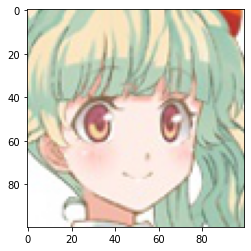

In [16]:
plt.imshow(data[10000])

In [17]:
data[100].shape

(100, 100, 3)

In [18]:
data.shape

(63565, 100, 100, 3)

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [27]:
class AnimeGan(object):
    def __init__(self, data = data, noise_shape = 1000, batch_size = 256, buffer_size = 60000, generator_loss = generator_loss, discriminator_loss = discriminator_loss):
        self.generator = tf.keras.models.Sequential()
        self.discriminator = tf.keras.models.Sequential()
        self.data = data
        
        self.noise_shape = noise_shape
        self.BUFFER_SIZE = buffer_size
        self.BATCH_SIZE = batch_size
        self.data = tf.data.Dataset.from_tensor_slices(self.data).shuffle(self.BUFFER_SIZE).batch(self.BATCH_SIZE)
        
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        
        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)
        self.num_examples_to_generate = 16

        # We will reuse this seed overtime (so it's easier)
        # to visualize progress in the animated GIF)
        self.seed = tf.random.normal([self.num_examples_to_generate, self.noise_shape])
    
    def create_generator(self):
        self.generator.add(tf.keras.layers.Dense(512*5*5, use_bias=False, input_shape=(1000,)))
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())
        self.generator.add(tf.keras.layers.Reshape((5, 5, 512)))
        #assert self.generator.output_shape == (None, 7, 7, 512)
        
        self.generator.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        assert self.generator.output_shape == (None, 5, 5, 256)
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        self.generator.add(tf.keras.layers.Conv2DTranspose(192, (5, 5), strides=(5, 5), padding='same', use_bias=False))
        assert self.generator.output_shape == (None, 25, 25, 192)
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        
        self.generator.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        assert self.generator.output_shape == (None, 50, 50, 128)
        self.generator.add(tf.keras.layers.BatchNormalization())
        self.generator.add(tf.keras.layers.LeakyReLU())

        self.generator.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        assert self.generator.output_shape == (None, 100, 100, 3)
        tf.keras.utils.plot_model(self.generator, to_file = 'generator.png')
        
    def create_discriminator(self):
        self.discriminator.add(tf.keras.layers.Conv2D(200, (5, 5), strides=(2, 2), padding='same',
                                         input_shape=[100, 100, 3]))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))

        self.discriminator.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))

        self.discriminator.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))

        
        self.discriminator.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))
        
        self.discriminator.add(tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
        self.discriminator.add(tf.keras.layers.LeakyReLU())
        self.discriminator.add(tf.keras.layers.Dropout(0.3))

        self.discriminator.add(tf.keras.layers.Flatten())
        self.discriminator.add(tf.keras.layers.Dense(1))
        tf.keras.utils.plot_model(self.discriminator, to_file = 'discriminator.png')
    @tf.function
    def train_step(images):
        noise = tf.random.normal([self.BATCH_SIZE, self.noise_shape])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
    def train(self, epochs):
        for epoch in range(epochs):
            start = time.time()

            for image_batch in self.data:
                train_step(image_batch)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(self.generator,
                                     epoch + 1,
                                     self.seed)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                checkpoint.save(file_prefix = self.checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_images(self.generator,
                               epochs,
                               self.seed)

In [28]:
gan = AnimeGan()

In [29]:
gan.create_generator()
gan.create_discriminator()

(1, 100, 100, 3)


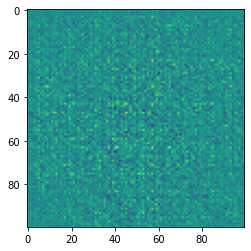

In [30]:
noise = tf.random.normal([1, 1000])
generated_image = gan.generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0])


In [31]:
decision = gan.discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00013753]], shape=(1, 1), dtype=float32)


In [32]:
gan.train(50)

NameError: name 'train_step' is not defined